In [13]:
import os
import re
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision

# --- Import necessary classes from your framework ---
# NOTE: You may need to adjust these imports based on your file structure.
from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.sae import SparseAutoencoder
from vit_prisma.sae import SparsecoderEval
from vit_prisma.sae.config import VisionModelSAERunnerConfig # Assuming this is where your config class is
from vit.preprocessing import get_processor_for_precached_224_images

# --- 1. Setup the Base Model and Validation Dataloader (do this once) ---

print("Setting up base model and dataloader...")

# --- Load Model (same as your training script) ---
model_name = "vit_base_patch16_224"
hooked_model = HookedSAEViT.from_pretrained(model_name, load_pretrained_model=False)
hooked_model.head = torch.nn.Linear(hooked_model.cfg.d_model, 6) # Your num_classes
checkpoint = torch.load("./model/vit_b-ImageNet_class_init-frozen_False-dataset_Hyperkvasir_anatomical.pth", weights_only=False)
state_dict = checkpoint.get('model_state_dict', checkpoint)
# ... your weight conversion logic ...
hooked_model.load_state_dict(state_dict, strict=False)
hooked_model.to('cuda')
hooked_model.eval()

# --- Load Validation Data ---
val_path = "./hyper-kvasir_imagefolder/val"
transform = get_processor_for_precached_224_images()
val_dataset = torchvision.datasets.ImageFolder(val_path, transform)
# Use a smaller batch size for evaluation if memory is a concern
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Setup complete.")

# --- 2. Find and Evaluate Each Trained SAE (UPDATED LOGIC) ---

sweep_root_dir = './models/sweep/'
all_results = []

# Find all the top-level run directories (e.g., 'sae_k128_exp32_lr0.0005')
sae_run_dirs = [d for d in os.listdir(sweep_root_dir) if os.path.isdir(os.path.join(sweep_root_dir, d))]

print(f"Found {len(sae_run_dirs)} SAE configurations to evaluate in {sweep_root_dir}")

for run_config_dir_name in tqdm(sae_run_dirs, desc="Evaluating SAE Configs"):
    run_config_path = os.path.join(sweep_root_dir, run_config_dir_name)
    
    # Inside each config dir, there's another directory with the wandb run ID
    try:
        wandb_run_id_dir = os.listdir(run_config_path)[0]
        run_path = os.path.join(run_config_path, wandb_run_id_dir)
    except IndexError:
        print(f"Skipping empty directory {run_config_dir_name}")
        continue
        
    # --- UPDATED: Automatically find the final SAE checkpoint and config file ---
    try:
        # Correct path for the config file
        config_path = os.path.join(run_path, 'config.json')
        
        # Find all .pt files that are SAE checkpoints
        checkpoint_files = [f for f in os.listdir(run_path) if f.endswith('.pt') and 'log_feature_sparsity' not in f]
        
        if not checkpoint_files:
            raise FileNotFoundError("No SAE checkpoint files (.pt) found.")
            
        # Parse the 'n_images' number from filenames to find the last checkpoint
        latest_checkpoint_file = ""
        max_images = -1
        for f in checkpoint_files:
            match = re.search(r'n_images_(\d+)', f)
            if match:
                num_images = int(match.group(1))
                if num_images > max_images:
                    max_images = num_images
                    latest_checkpoint_file = f
                    
        if not latest_checkpoint_file:
            raise FileNotFoundError("Could not determine the latest checkpoint file.")
        
        sae_path = os.path.join(run_path, latest_checkpoint_file)
        print(f"Found final SAE for {run_config_dir_name}: {latest_checkpoint_file}")

        # Load the SAE and its Config
        sae_run_config = VisionModelSAERunnerConfig()
        sae_run_config = sae_run_config.load_config(config_path)
        print(sae_run_config)
        sae = SparseAutoencoder.load_from_pretrained(sae_path)
        sae.to('cuda')
        sae.eval()

    except Exception as e:
        print(f"Skipping directory {run_config_dir_name}: Error during loading. Details: {e}")
        continue

    # --- Run the Evaluator ---
    print(f"Evaluating: {run_config_dir_name}")
    evaluator = SparsecoderEval(sae, hooked_model, val_dataset)
    
    # Evaluate and handle potential missing keys gracefully
    eval_metrics = evaluator.run_eval()
    
    k_value = sae_run_config.activation_fn_kwargs.get('k', 'N/A')
    all_results.append({
        'k': k_value,
        'CE_recovered': eval_metrics.get('CE_recovered'),
        'avg_l0': eval_metrics.get('avg_l0'),
        'avg_cosine_similarity': eval_metrics.get('avg_cosine_similarity'),
        'avg_recons_CE': eval_metrics.get('avg_recons_CE'),
        'avg_CE_baseline': eval_metrics.get('avg_CE'), # The model's original loss
    })

# --- 3. Display the Comparison Table ---
print("\n" + "="*90)
print("                           S W E E P   E V A L U A T I O N   R E S U L T S")
print("="*90)

if all_results:
    df = pd.DataFrame(all_results)
    
    # Select and reorder columns for the clearest view
    display_columns = [
        'k', 'CE_recovered', 'avg_l0', 'avg_cosine_similarity',
        'avg_recons_CE', 'avg_CE_baseline'
    ]
    df_display = df.reindex(columns=display_columns).sort_values(by='k').set_index('k')
    
    print(df_display.to_string(float_format="%.4f"))
else:
    print("No evaluation results were collected. Please check paths and file names.")

print("="*90)


2025-06-18 17:36:55 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


Setting up base model and dataloader...


2025-06-18 17:36:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-18 17:36:56 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-18 17:36:56 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-18 17:36:56 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-18 17:36:56 INFO:root: Filling in 2 missing keys with default initialization
2025-06-18 17:36:56 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-18 17:36:56 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Setup complete.
Found 3 SAE configurations to evaluate in ./models/sweep/


Evaluating SAE Configs:   0%|          | 0/3 [00:00<?, ?it/s]2025-06-18 17:36:56 INFO:root: n_tokens_per_buffer (millions): 0.032
2025-06-18 17:36:56 INFO:root: Lower bound: n_contexts_per_buffer (millions): 0.00064
2025-06-18 17:36:56 INFO:root: Total training steps: 15869
2025-06-18 17:36:56 INFO:root: Total training images: 1300000
2025-06-18 17:36:56 INFO:root: Total wandb updates: 1586
2025-06-18 17:36:56 INFO:root: Expansion factor: 16
2025-06-18 17:36:56 INFO:root: n_tokens_per_feature_sampling_window (millions): 204.8
2025-06-18 17:36:56 INFO:root: n_tokens_per_dead_feature_window (millions): 1024.0
2025-06-18 17:36:56 INFO:root: We will reset the sparsity calculation 15 times.
2025-06-18 17:36:56 INFO:root: Number tokens in sparsity calculation window: 4.10e+06
2025-06-18 17:36:56 INFO:root: Gradient clipping with max_norm=1.0
2025-06-18 17:36:56 INFO:root: Using SAE initialization method: independent
2025-06-18 17:36:56 INFO:root: n_tokens_per_buffer (millions): 0.12608
2025-

Found final SAE for sae_k128_exp32_lr0.0005: n_images_32840.pt
VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='vit_base_patch16_224', vit_model_cfg=None, model_path=None, hook_point_layer=10, layer_subtype='hook_resid_post', hook_point_head_index=None, context_size=197, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/vit_base_patch16_224/blocks.10.hook_resid_post', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=32, from_pretrained_path=None, is_transcoder=False, transcoder_with_skip_connection=True, out_hook_point_layer=9, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=768, activation_fn_str='topk', activation_fn_kwargs={'k': 128}, cls_token_only=False, max_grad_norm=1.0, initialization_method='independent', normalize_activations='layer_norm', n_batches_in_buffer=20, store_

/home/piragi/projects/ViT-Prisma/src/vit_prisma/sae/evals/model_eval.py:153: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Evaluating: 100%|██████████| 103/103 [00:05<00:00, 18.43it/s, L0=1568.5, Cosine Sim=0.926582]
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Finished running through validation dataset...
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Computing metrics...
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated): 128.000000
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per CLS token: 128.000000
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per image: 1515.402439
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Average Cosine Similarity: 0.9375
2025-06-18 17:37:02 INFO:vit_prisma.sae.evals.model_eval: Average Loss: 1.930944
2025-06-18 17:37

Found final SAE for sae_k32_exp32_lr0.0005: n_images_32840.pt
VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='vit_base_patch16_224', vit_model_cfg=None, model_path=None, hook_point_layer=10, layer_subtype='hook_resid_post', hook_point_head_index=None, context_size=197, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/vit_base_patch16_224/blocks.10.hook_resid_post', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=32, from_pretrained_path=None, is_transcoder=False, transcoder_with_skip_connection=True, out_hook_point_layer=9, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=768, activation_fn_str='topk', activation_fn_kwargs={'k': 32}, cls_token_only=False, max_grad_norm=1.0, initialization_method='independent', normalize_activations='layer_norm', n_batches_in_buffer=20, store_ba

Evaluating: 100%|██████████| 103/103 [00:05<00:00, 18.40it/s, L0=456, Cosine Sim=0.883883]
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Finished running through validation dataset...
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Computing metrics...
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated): 32.000000
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per CLS token: 32.000000
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per image: 442.326829
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average Cosine Similarity: 0.8802
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average Loss: 1.933613
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average Reconstruction Loss: 1.941748
2025-06-18 17:37:08 INFO:vit_prisma.sae.evals.model_eval: Average Zero Ablation Loss: 1.944950
2025-06-18 17:37:08 INFO:vit_pris

Found final SAE for sae_k64_exp32_lr0.0005: n_images_32840.pt
VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='vit_base_patch16_224', vit_model_cfg=None, model_path=None, hook_point_layer=10, layer_subtype='hook_resid_post', hook_point_head_index=None, context_size=197, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/vit_base_patch16_224/blocks.10.hook_resid_post', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=32, from_pretrained_path=None, is_transcoder=False, transcoder_with_skip_connection=True, out_hook_point_layer=9, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=768, activation_fn_str='topk', activation_fn_kwargs={'k': 64}, cls_token_only=False, max_grad_norm=1.0, initialization_method='independent', normalize_activations='layer_norm', n_batches_in_buffer=20, store_ba

Evaluating: 100%|██████████| 103/103 [00:05<00:00, 18.31it/s, L0=856, Cosine Sim=0.915855]
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Finished running through validation dataset...
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Computing metrics...
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated): 64.000000
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per CLS token: 64.000000
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per image: 873.334146
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average Cosine Similarity: 0.9128
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average Loss: 1.933824
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average Reconstruction Loss: 1.927149
2025-06-18 17:37:13 INFO:vit_prisma.sae.evals.model_eval: Average Zero Ablation Loss: 1.944950
2025-06-18 17:37:13 INFO:vit_pris


                           S W E E P   E V A L U A T I O N   R E S U L T S
     CE_recovered   avg_l0  avg_cosine_similarity  avg_recons_CE  avg_CE_baseline
k                                                                                
32        28.2434  32.0000                 0.8802         1.9417           1.9336
64       159.9771  64.0000                 0.9128         1.9271           1.9338
128      145.1198 128.0000                 0.9375         1.9260           1.9309


In [7]:
import torch
import torchvision
import torch.nn.functional as F
from vit.preprocessing import get_processor_for_precached_224_images
from tqdm import tqdm

class SteerabilityCalculator:
    def __init__(self, model, sae, n_classes, device='cuda'):
        self.model = model
        self.sae = sae
        self.n_classes = n_classes
        self.device = device
        
    def compute_steerability_per_class(self, dataloader, n_samples=1000, steering_strength=150):
        """
        Compute steerability scores for each feature towards each class.
        
        Returns:
            steerability_matrix: [n_features, n_classes] tensor where entry (i,j) 
                                is the steerability of feature i towards class j
        """
        n_features = self.sae.cfg.d_sae
        
        # Initialize steerability matrix
        steerability_matrix = torch.zeros(n_features, self.n_classes).to(self.device)
        
        # Only test active features to save computation
        feature_acts_sum = torch.zeros(n_features).to(self.device)
        
        # First pass: identify active features
        with torch.no_grad():
            for imgs, _ in dataloader:
                imgs = imgs.to(self.device)
                _, cache = self.model.run_with_cache(imgs, names_filter=self.sae.cfg.hook_point)
                acts = cache[self.sae.cfg.hook_point]
                feature_acts = self.sae.encode(acts)[1]
                feature_acts_sum += (feature_acts > 0).float().sum(dim=[0, 1])
                
        active_features = torch.where(feature_acts_sum > 0)[0]
        print(f"Testing {len(active_features)} active features out of {n_features}")
        
        # Process samples
        samples_processed = 0
        
        for imgs, _ in tqdm(dataloader, desc="Computing steerability"):
            if samples_processed >= n_samples:
                break
                
            batch_size = min(imgs.shape[0], n_samples - samples_processed)
            imgs = imgs[:batch_size].to(self.device)
            
            with torch.no_grad():
                # Get baseline predictions
                baseline_logits = self.model(imgs)
                baseline_probs = F.softmax(baseline_logits, dim=-1)
                
                # Test each active feature
                for feat_idx in active_features:
                    # Define steering hook
                    def steering_hook(resid, hook):
                        # Get SAE encoding
                        sae_encoded = self.sae.encode(resid)[1]
                        # Steer only CLS token (for classification)
                        sae_encoded[:, 0, feat_idx] = steering_strength
                        # Decode back
                        return self.sae.decode(sae_encoded)
                    
                    # Run with steering
                    with self.model.hooks(fwd_hooks=[(self.sae.cfg.hook_point, steering_hook)]):
                        steered_logits = self.model(imgs)
                        steered_probs = F.softmax(steered_logits, dim=-1)
                    
                    # Compute steerability per class
                    # This measures how much probability increases for each class
                    prob_changes = steered_probs - baseline_probs  # [batch, n_classes]
                    
                    # Square to match paper's metric (squared changes)
                    squared_changes = prob_changes ** 2
                    
                    # Accumulate per-class effects
                    steerability_matrix[feat_idx] += squared_changes.sum(dim=0) * batch_size
                    
            samples_processed += batch_size
            
        # Normalize by number of samples
        steerability_matrix /= samples_processed
        
        return steerability_matrix
    
    def get_top_features_per_class(self, steerability_matrix, top_k=10):
        """
        Get the top-k most steerable features for each class.
        
        Returns:
            Dict[int, List[Tuple[int, float]]]: class_idx -> [(feature_idx, steerability_score), ...]
        """
        top_features = {}
        
        for class_idx in range(self.n_classes):
            class_steerability = steerability_matrix[:, class_idx]
            values, indices = torch.topk(class_steerability, k=min(top_k, len(class_steerability)))
            
            top_features[class_idx] = [
                (idx.item(), val.item()) 
                for idx, val in zip(indices, values)
            ]
            
        return top_features


# Example usage
if __name__ == "__main__":
    # Assuming you have loaded your models and dataloader
    from prisma_transmm import load_models
    
    sae, model = load_models()
    label_map = {2: 3, 3: 2}

    def custom_target_transform(target):
        return label_map.get(target, target)

    train_path = "./hyper-kvasir_imagefolder/train"
    train_dataset = torchvision.datasets.ImageFolder(
        train_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform
    )
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    
    # Create calculator
    calculator = SteerabilityCalculator(model, sae, n_classes=6)
    
    # Compute steerability matrix
    steerability_matrix = calculator.compute_steerability_per_class(
        dataloader, 
        n_samples=150,
        steering_strength=5
    )
    
    # Get top features per class
    top_features = calculator.get_top_features_per_class(steerability_matrix, top_k=10)
    
    # Print results
    for class_idx, features in top_features.items():
        print(f"\nClass {class_idx} - Top steerable features:")
        feature_list = [feat_idx for feat_idx, score in features[:10]]
        print(f"Class {class_idx} - Top steerable features: {feature_list}")
        score_list = [score for feat_idx, score in features[:10]]
        print(f"Class {class_idx} - Steerability: {score_list}")

2025-06-22 18:57:36 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-22 18:57:36 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-06-22 18:57:36 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-06-22 18:57:37 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-22 18:57:37 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-22 18:57:37 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-22 18:57:37 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-22 18:57:37 INFO:root: Filling in 2 missing keys with default initialization
2025-06-22 18:57:37 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-22 18:57:38 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Testing 5235 active features out of 6144


Computing steerability:   1%|          | 5/514 [47:35<80:44:12, 571.03s/it]


Class 0 - Top steerable features:
Class 0 - Top steerable features: [2159, 1333, 4796, 4279, 2838, 717, 4897, 3, 5818, 2908]
Class 0 - Steerability: [0.22191022336483002, 0.1988079696893692, 0.19796188175678253, 0.18925566971302032, 0.18605196475982666, 0.18590377271175385, 0.18528573215007782, 0.1824003905057907, 0.181175097823143, 0.18067993223667145]

Class 1 - Top steerable features:
Class 1 - Top steerable features: [4730, 1353, 2194, 954, 1829, 5124, 3590, 3824, 5548, 1143]
Class 1 - Steerability: [0.02301003597676754, 0.022527337074279785, 0.022244896739721298, 0.022212959825992584, 0.021898552775382996, 0.021845219656825066, 0.02139381505548954, 0.021246496587991714, 0.021242814138531685, 0.021088426932692528]

Class 2 - Top steerable features:
Class 2 - Top steerable features: [5654, 1052, 6089, 2129, 124, 5155, 1657, 3992, 3423, 3383]
Class 2 - Steerability: [0.9050507545471191, 0.7614328265190125, 0.6916378736495972, 0.6889796257019043, 0.6858638525009155, 0.685009717941284

In [4]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

class EnhancedSteerabilityCalculator:
    def __init__(self, model, sae, n_classes, device='cuda'):
        self.model = model
        self.sae = sae
        self.n_classes = n_classes
        self.device = device
        
    def compute_steerability_with_coverage(self, dataloader, n_samples=1000, 
                                          steering_strength=150, activation_threshold=0.1,
                                          min_activation_freq=0.1):
        """
        Compute both steerability scores and activation frequency for each feature.
        
        Args:
            dataloader: PyTorch dataloader
            n_samples: Total number of samples to process
            steering_strength: Strength of feature activation when steering
            activation_threshold: Threshold for considering a feature "active"
            min_activation_freq: Minimum frequency (0-1) a feature must activate to be tested
        
        Returns:
            steerability_matrix: [n_features, n_classes] - steerability per feature per class
            activation_freq: [n_features, n_classes] - how often feature activates for each class
            coverage_score: [n_features, n_classes] - combined metric (steerability * frequency)
        """
        n_features = self.sae.cfg.d_sae
        
        # Initialize matrices
        steerability_matrix = torch.zeros(n_features, self.n_classes).to(self.device)
        activation_counts = torch.zeros(n_features, self.n_classes).to(self.device)
        class_sample_counts = torch.zeros(self.n_classes).to(self.device)
        
        # First pass: identify frequently active features
        print("First pass: identifying frequently active features...")
        samples_for_frequency = min(n_samples // 2, 500)  # Use subset for frequency check
        
        for i, (imgs, labels) in enumerate(dataloader):
            if i * imgs.shape[0] >= samples_for_frequency:
                break
            
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            
            with torch.no_grad():
                _, cache = self.model.run_with_cache(imgs, names_filter=self.sae.cfg.hook_point)
                acts = cache[self.sae.cfg.hook_point]
                feature_acts = self.sae.encode(acts)[1]
                cls_features = feature_acts[:, 0, :]  # CLS token features
                active_mask = cls_features > activation_threshold
                
                for j in range(imgs.shape[0]):
                    label = labels[j].item()
                    if label < self.n_classes:
                        activation_counts[:, label] += active_mask[j].float()
                        class_sample_counts[label] += 1
        
        # Identify features that meet minimum frequency threshold
        feature_frequency = activation_counts / (class_sample_counts.unsqueeze(0) + 1e-8)
        frequently_active = (feature_frequency > min_activation_freq).any(dim=1)
        candidate_features = torch.where(frequently_active)[0]
        
        print(f"Found {len(candidate_features)} features active in >{min_activation_freq*100:.0f}% of samples")
        print(f"Skipping {n_features - len(candidate_features)} rarely active features")
        
        # Reset counters for full pass
        activation_counts.zero_()
        class_sample_counts.zero_()
        
        # Second pass: compute steerability only for frequently active features
        samples_processed = 0
        
        for imgs, labels in tqdm(dataloader, desc="Computing steerability for frequent features"):
            if samples_processed >= n_samples:
                break
                
            batch_size = min(imgs.shape[0], n_samples - samples_processed)
            imgs = imgs[:batch_size].to(self.device)
            labels = labels[:batch_size].to(self.device)
            
            with torch.no_grad():
                # Get baseline predictions
                baseline_logits = self.model(imgs)
                baseline_probs = F.softmax(baseline_logits, dim=-1)
                
                # Get SAE features for this batch
                _, cache = self.model.run_with_cache(imgs, names_filter=self.sae.cfg.hook_point)
                acts = cache[self.sae.cfg.hook_point]
                feature_acts = self.sae.encode(acts)[1]
                cls_features = feature_acts[:, 0, :]  # [batch, features]
                active_mask = cls_features > activation_threshold
                
                # Update activation counts per class
                for j in range(batch_size):
                    label = labels[j].item()
                    if label < self.n_classes:
                        activation_counts[:, label] += active_mask[j].float()
                        class_sample_counts[label] += 1
                
                # Test only frequently active features that are also active in this batch
                batch_active = torch.where(active_mask.any(dim=0))[0]
                features_to_test = [f.item() for f in batch_active if f in candidate_features]
                
                for feat_idx in features_to_test:
                    # Define steering hook
                    def steering_hook(resid, hook):
                        sae_encoded = self.sae.encode(resid)[1]
                        sae_encoded[:, 0, feat_idx] = steering_strength
                        return self.sae.decode(sae_encoded)
                    
                    # Run with steering
                    with self.model.hooks(fwd_hooks=[(self.sae.cfg.hook_point, steering_hook)]):
                        steered_logits = self.model(imgs)
                        steered_probs = F.softmax(steered_logits, dim=-1)
                    
                    # Compute steerability per class
                    prob_changes = steered_probs - baseline_probs
                    squared_changes = prob_changes ** 2
                    
                    # Accumulate per-class effects weighted by whether feature was active
                    for j in range(batch_size):
                        if active_mask[j, feat_idx]:
                            label = labels[j].item()
                            if label < self.n_classes:
                                # Add steerability only for samples where feature was active
                                steerability_matrix[feat_idx, label] += squared_changes[j, label]
                    
            samples_processed += batch_size
        
        # Normalize steerability by number of active samples per feature per class
        activation_freq = torch.zeros_like(activation_counts)
        for c in range(self.n_classes):
            if class_sample_counts[c] > 0:
                activation_freq[:, c] = activation_counts[:, c] / class_sample_counts[c]
                # Only normalize steerability by samples where feature was actually active
                active_sample_counts = activation_counts[:, c]
                mask = active_sample_counts > 0
                steerability_matrix[mask, c] /= active_sample_counts[mask]
        
        # Compute coverage score: steerability * frequency
        # This rewards features that are both steerable AND frequently active
        coverage_score = steerability_matrix * activation_freq
        
        return steerability_matrix, activation_freq, coverage_score
    
    def get_coverage_optimized_features(self, coverage_score, target_coverage=0.8, top_k_per_feature=10):
        """
        Select a minimal set of features that together cover most samples.
        Uses a greedy algorithm to maximize coverage while minimizing feature count.
        
        Args:
            coverage_score: [n_features, n_classes] tensor from compute_steerability_with_coverage
            target_coverage: Target coverage fraction (0-1)
            top_k_per_feature: Maximum features to select per class
        
        Returns:
            Dict[int, List[int]]: class_idx -> list of feature indices
        """
        selected_features = {}
        
        for class_idx in range(self.n_classes):
            class_scores = coverage_score[:, class_idx]
            
            # Sort features by coverage score
            sorted_indices = torch.argsort(class_scores, descending=True)
            
            # Greedy selection: keep adding features until we reach target coverage
            selected = []
            cumulative_coverage = 0.0
            
            for idx in sorted_indices:
                if cumulative_coverage >= target_coverage:
                    break
                if class_scores[idx] > 0:
                    selected.append(idx.item())
                    # Approximate coverage addition (assumes independence)
                    cumulative_coverage += class_scores[idx].item()
                    if len(selected) >= top_k_per_feature:
                        break
            
            selected_features[class_idx] = selected
            
        return selected_features

In [ ]:
# Analysis script for steerability with coverage optimization
import torch
import time
from prisma_transmm import load_models
import torchvision
from vit.preprocessing import get_processor_for_precached_224_images

# Load models
sae, model = load_models()

# Setup dataloader
label_map = {2: 3, 3: 2}
def custom_target_transform(target):
    return label_map.get(target, target)

train_path = "./hyper-kvasir_imagefolder/train"
train_dataset = torchvision.datasets.ImageFolder(
    train_path, 
    get_processor_for_precached_224_images(), 
    target_transform=custom_target_transform
)
dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4
)

# Create enhanced calculator
calculator = EnhancedSteerabilityCalculator(model, sae, n_classes=6)

# Test different frequency thresholds
print("=" * 70)
print("TESTING DIFFERENT FREQUENCY THRESHOLDS")
print("=" * 70)

thresholds = [0.10]
results = {}

for min_freq in thresholds:
    print(f"\n\nTesting with min_activation_freq = {min_freq}")
    start_time = time.time()
    
    # Compute metrics
    steerability, frequency, coverage = calculator.compute_steerability_with_coverage(
        dataloader, 
        n_samples=500,
        steering_strength=5,
        activation_threshold=0.1,
        min_activation_freq=min_freq
    )
    
    elapsed = time.time() - start_time
    print(f"Computation time: {elapsed:.1f} seconds")
    
    # Get optimized feature sets
    feature_sets = calculator.get_coverage_optimized_features(
        coverage, 
        target_coverage=0.8,
        top_k_per_feature=10
    )
    
    results[min_freq] = {
        'time': elapsed,
        'feature_sets': feature_sets,
        'steerability': steerability,
        'frequency': frequency,
        'coverage': coverage
    }

# Summary comparison
print("\n\n" + "=" * 70)
print("FREQUENCY THRESHOLD COMPARISON")
print("=" * 70)
print("Threshold | Time (s) | Avg Features/Class | Estimated Coverage")
print("-" * 70)

for min_freq in thresholds:
    res = results[min_freq]
    avg_features = sum(len(res['feature_sets'][c]) for c in range(6)) / 6
    
    # Estimate total coverage per class
    total_coverage = []
    for c in range(6):
        if res['feature_sets'][c]:
            class_coverage = sum(res['coverage'][f, c].item() for f in res['feature_sets'][c])
            total_coverage.append(min(class_coverage, 1.0))  # Cap at 100%
        else:
            total_coverage.append(0.0)
    avg_coverage = sum(total_coverage) / 6
    
    print(f"{min_freq:8.2f} | {res['time']:8.1f} | {avg_features:17.1f} | {avg_coverage:.1%}")

# Detailed analysis for chosen threshold
chosen_threshold = 0.10
chosen_results = results[chosen_threshold]

print("\n\n" + "=" * 70)
print(f"DETAILED ANALYSIS (min_activation_freq = {chosen_threshold})")
print("=" * 70)

# Per-class analysis
for class_idx in range(6):
    selected = chosen_results['feature_sets'][class_idx]
    steer = chosen_results['steerability']
    freq = chosen_results['frequency']
    cov = chosen_results['coverage']
    
    print(f"\n\nClass {class_idx}:")
    print(f"  Selected {len(selected)} features for 80% coverage target")
    
    if selected:
        # Show top 5 features
        print(f"\n  Top Features (showing up to 5):")
        print(f"  {'Feature':<10} {'Steerability':<15} {'Frequency':<12} {'Coverage':<12}")
        print("  " + "-" * 50)
        
        for i, feat_idx in enumerate(selected[:5]):
            print(f"  {feat_idx:<10} {steer[feat_idx, class_idx]:>13.4f} "
                  f"{freq[feat_idx, class_idx]:>10.1%} {cov[feat_idx, class_idx]:>10.4f}")
        
        # Total coverage estimate
        total_freq = sum(freq[f, class_idx].item() for f in selected)
        print(f"\n  Combined frequency coverage: ~{total_freq:.1%}")

# Compare with single-feature approach
print("\n\n" + "=" * 70)
print("COMPARISON: SINGLE FEATURE VS COVERAGE-OPTIMIZED")
print("=" * 70)

for class_idx in range(6):
    steer = chosen_results['steerability']
    freq = chosen_results['frequency']
    
    # Find single most steerable feature
    top_steerable_idx = torch.topk(steer[:, class_idx], k=1).indices[0].item()
    
    # Coverage-optimized features
    coverage_features = chosen_results['feature_sets'][class_idx]
    
    print(f"\nClass {class_idx}:")
    print(f"  Single most steerable feature: {top_steerable_idx}")
    print(f"    - Steerability: {steer[top_steerable_idx, class_idx]:.4f}")
    print(f"    - Frequency: {freq[top_steerable_idx, class_idx]:.1%}")
    
    print(f"  Coverage-optimized set: {len(coverage_features)} features")
    if coverage_features:
        combined_freq = sum(freq[f, class_idx].item() for f in coverage_features)
        print(f"    - Combined frequency: ~{combined_freq:.1%}")
        print(f"    - Feature indices: {coverage_features[:5]}{'...' if len(coverage_features) > 5 else ''}")

# Generate class feature map for attribution
print("\n\n" + "=" * 70)
print("CLASS FEATURE MAP FOR ATTRIBUTION")
print("=" * 70)

class_feature_map = {}
for class_idx in range(6):
    # Use top 5 coverage-optimized features
    features = chosen_results['feature_sets'][class_idx][:5]
    class_feature_map[class_idx] = features
    print(f"Class {class_idx}: {features}")

print("\n\nThis class_feature_map can be used in your attribution generation!")

2025-06-22 21:06:09 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-22 21:06:09 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-06-22 21:06:10 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-22 21:06:11 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-22 21:06:11 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-22 21:06:11 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-22 21:06:11 INFO:root: Filling in 2 missing keys with default initialization
2025-06-22 21:06:11 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-22 21:06:11 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
TESTING DIFFERENT FREQUENCY THRESHOLDS


Testing with min_activation_freq = 0.05
First pass: identifying frequently active features...
Found 713 features active in >5% of samples
Skipping 5431 rarely active features


Computing steerability for frequent features:   3%|▎         | 16/514 [17:42<9:11:25, 66.44s/it]

Computation time: 1064.1 seconds


Testing with min_activation_freq = 0.1
First pass: identifying frequently active features...


Found 598 features active in >10% of samples
Skipping 5546 rarely active features


Computing steerability for frequent features:   0%|          | 2/514 [03:05<13:12:34, 92.88s/it]


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

class DeconstructivistFeatureCalculator:
    def __init__(self, model, sae, n_classes, device='cuda'):
        self.model = model
        self.sae = sae
        self.n_classes = n_classes
        self.device = device
        
    def compute_feature_importance_via_ablation(self, dataloader, n_samples=1000, 
                                               activation_threshold=0.1,
                                               min_activation_freq=0.1,
                                               ablation_value=0.0):
        """
        Compute feature importance by measuring classification drop when features are ablated.
        
        Args:
            dataloader: PyTorch dataloader
            n_samples: Total number of samples to process
            activation_threshold: Threshold for considering a feature "active"
            min_activation_freq: Minimum frequency a feature must activate to be tested
            ablation_value: Value to set feature to when ablating (typically 0)
        
        Returns:
            importance_matrix: [n_features, n_classes] - drop in correct class prob when ablated
            activation_freq: [n_features, n_classes] - how often feature activates for each class
            faithfulness_score: [n_features, n_classes] - combined metric (importance * frequency)
        """
        n_features = self.sae.cfg.d_sae
        
        # Initialize matrices
        importance_matrix = torch.zeros(n_features, self.n_classes).to(self.device)
        activation_counts = torch.zeros(n_features, self.n_classes).to(self.device)
        class_sample_counts = torch.zeros(self.n_classes).to(self.device)
        
        # First pass: identify frequently active features (same as before)
        print("First pass: identifying frequently active features...")
        samples_for_frequency = min(n_samples // 2, 500)
        
        for i, (imgs, labels) in enumerate(dataloader):
            if i * imgs.shape[0] >= samples_for_frequency:
                break
            
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            
            with torch.no_grad():
                _, cache = self.model.run_with_cache(imgs, names_filter=self.sae.cfg.hook_point)
                acts = cache[self.sae.cfg.hook_point]
                feature_acts = self.sae.encode(acts)[1]
                cls_features = feature_acts[:, 0, :]  # CLS token
                active_mask = cls_features > activation_threshold
                
                for j in range(imgs.shape[0]):
                    label = labels[j].item()
                    if label < self.n_classes:
                        activation_counts[:, label] += active_mask[j].float()
                        class_sample_counts[label] += 1
        
        # Identify frequently active features
        feature_frequency = activation_counts / (class_sample_counts.unsqueeze(0) + 1e-8)
        frequently_active = (feature_frequency > min_activation_freq).any(dim=1)
        candidate_features = torch.where(frequently_active)[0]
        
        print(f"Found {len(candidate_features)} features active in >{min_activation_freq*100:.0f}% of samples")
        print(f"Skipping {n_features - len(candidate_features)} rarely active features")
        
        # Reset counters
        activation_counts.zero_()
        class_sample_counts.zero_()
        
        # Second pass: measure importance via ablation
        samples_processed = 0
        
        for imgs, labels in tqdm(dataloader, desc="Computing feature importance via ablation"):
            if samples_processed >= n_samples:
                break
                
            batch_size = min(imgs.shape[0], n_samples - samples_processed)
            imgs = imgs[:batch_size].to(self.device)
            labels = labels[:batch_size].to(self.device)
            
            with torch.no_grad():
                # Get baseline predictions
                baseline_logits = self.model(imgs)
                baseline_probs = F.softmax(baseline_logits, dim=-1)
                
                # Get correct class probabilities
                correct_class_probs = baseline_probs[range(batch_size), labels]
                
                # Get SAE features
                _, cache = self.model.run_with_cache(imgs, names_filter=self.sae.cfg.hook_point)
                acts = cache[self.sae.cfg.hook_point]
                feature_acts = self.sae.encode(acts)[1]
                cls_features = feature_acts[:, 0, :]
                active_mask = cls_features > activation_threshold
                
                # Update activation counts
                for j in range(batch_size):
                    label = labels[j].item()
                    if label < self.n_classes:
                        activation_counts[:, label] += active_mask[j].float()
                        class_sample_counts[label] += 1
                
                # Test ablation for frequently active features in this batch
                batch_active = torch.where(active_mask.any(dim=0))[0]
                features_to_test = [f.item() for f in batch_active if f in candidate_features]
                
                for feat_idx in features_to_test:
                    # Define ablation hook
                    def ablation_hook(resid, hook):
                        sae_encoded = self.sae.encode(resid)[1]
                        # Ablate the feature (set to zero or specified value)
                        sae_encoded[:, 0, feat_idx] = ablation_value
                        return self.sae.decode(sae_encoded)
                    
                    # Run with ablation
                    with self.model.hooks(fwd_hooks=[(self.sae.cfg.hook_point, ablation_hook)]):
                        ablated_logits = self.model(imgs)
                        ablated_probs = F.softmax(ablated_logits, dim=-1)
                    
                    # Measure drop in correct class probability
                    ablated_correct_probs = ablated_probs[range(batch_size), labels]
                    prob_drops = correct_class_probs - ablated_correct_probs  # Positive = importance
                    
                    # Accumulate importance for samples where feature was active
                    for j in range(batch_size):
                        if active_mask[j, feat_idx] and prob_drops[j] > 0:  # Only count drops
                            label = labels[j].item()
                            if label < self.n_classes:
                                importance_matrix[feat_idx, label] += prob_drops[j]
                    
            samples_processed += batch_size
        
        # Normalize importance by number of active samples
        activation_freq = torch.zeros_like(activation_counts)
        for c in range(self.n_classes):
            if class_sample_counts[c] > 0:
                activation_freq[:, c] = activation_counts[:, c] / class_sample_counts[c]
                # Normalize importance by samples where feature was active
                active_sample_counts = activation_counts[:, c]
                mask = active_sample_counts > 0
                importance_matrix[mask, c] /= active_sample_counts[mask]
        
        # Faithfulness score: importance * frequency
        # High score = feature that often activates AND causes big drops when removed
        faithfulness_score = importance_matrix * activation_freq
        
        return importance_matrix, activation_freq, faithfulness_score
    
    def get_critical_features(self, faithfulness_score, importance_matrix, 
                             min_importance=0.05, top_k=10):
        """
        Select features that are critical for classification (cause biggest drops).
        
        Args:
            faithfulness_score: Combined importance * frequency metric
            importance_matrix: Raw importance scores (probability drops)
            min_importance: Minimum importance threshold
            top_k: Maximum features per class
        
        Returns:
            Dict[int, List[Tuple[int, float]]]: class -> [(feature_idx, importance), ...]
        """
        critical_features = {}
        
        for class_idx in range(self.n_classes):
            # Filter by minimum importance threshold
            class_importance = importance_matrix[:, class_idx]
            class_faithfulness = faithfulness_score[:, class_idx]
            
            # Get features that cause meaningful drops
            valid_mask = class_importance > min_importance
            valid_indices = torch.where(valid_mask)[0]
            
            if len(valid_indices) > 0:
                # Sort by faithfulness score among valid features
                valid_scores = class_faithfulness[valid_indices]
                sorted_order = torch.argsort(valid_scores, descending=True)
                
                # Select top-k
                selected = []
                for i in range(min(top_k, len(sorted_order))):
                    idx = valid_indices[sorted_order[i]]
                    selected.append((
                        idx.item(), 
                        class_importance[idx].item()
                    ))
                
                critical_features[class_idx] = selected
            else:
                critical_features[class_idx] = []
                
        return critical_features
    
    def analyze_feature_interactions(self, dataloader, feature_sets, n_samples=100):
        """
        Quick analysis to check if features work independently or in groups.
        Tests pairwise ablations to find complementary features.
        """
        interaction_scores = {}
        
        for class_idx, features in feature_sets.items():
            if len(features) < 2:
                continue
                
            print(f"\nAnalyzing interactions for class {class_idx}...")
            feature_indices = [f[0] for f in features[:5]]  # Top 5 features
            
            # Test pairwise ablations
            pair_effects = {}
            
            for imgs, labels in dataloader:
                # Get samples of this class
                class_mask = labels == class_idx
                if not class_mask.any():
                    continue
                    
                class_imgs = imgs[class_mask][:10]  # Small batch
                if len(class_imgs) == 0:
                    continue
                    
                with torch.no_grad():
                    # Baseline
                    baseline_logits = self.model(class_imgs.to(self.device))
                    baseline_probs = F.softmax(baseline_logits, dim=-1)[:, class_idx]
                    
                    # Test pairs
                    for i, feat1 in enumerate(feature_indices):
                        for feat2 in feature_indices[i+1:]:
                            def double_ablation_hook(resid, hook):
                                sae_encoded = self.sae.encode(resid)[1]
                                sae_encoded[:, 0, feat1] = 0
                                sae_encoded[:, 0, feat2] = 0
                                return self.sae.decode(sae_encoded)
                            
                            with self.model.hooks(fwd_hooks=[(self.sae.cfg.hook_point, double_ablation_hook)]):
                                ablated_logits = self.model(class_imgs.to(self.device))
                                ablated_probs = F.softmax(ablated_logits, dim=-1)[:, class_idx]
                            
                            pair_drop = (baseline_probs - ablated_probs).mean().item()
                            pair_effects[(feat1, feat2)] = pair_drop
                
            
            interaction_scores[class_idx] = pair_effects
            
        return interaction_scores

In [1]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

class DeconstructivistFeatureCalculator:
    def __init__(self, model, sae, n_classes, device='cuda'):
        self.model = model
        self.sae = sae
        self.n_classes = n_classes
        self.device = device
        
    # ---------- helper ----------------------------------------------------------
    def ablate_codes(codes, features, value=0.0):
        """
        codes       : (B, T, F)  – SAE codes for one batch
        features    : list[int]  – feature indices to ablate
        value       : usually 0
        returns     : (B, T, F) codes with selected features set to `value`
        """
        if len(features) == 0:
            return codes
        # Build a mask and use inplace fill_
        mask = torch.zeros_like(codes[..., 0], dtype=torch.bool)  # (B, T)
        mask = mask.unsqueeze(-1).repeat(1, 1, len(features))     # (B, T, k)
        codes = codes.clone()
        codes[..., features] = value
        return codes
    # ---------------------------------------------------------------------------


    def compute_feature_importance_via_ablation(
            self,
            dataloader,
            n_samples=20_000,
            activation_threshold=0.10,
            min_activation_freq=0.01,
    ):
        """
        Re-implementation that
        – uses Δlogit
        – keeps negative contributions
        – does one extra forward per batch
        – exact, encode-free ablation
        """

        device = self.device
        n_features = self.sae.cfg.d_sae
        hook_point = self.sae.cfg.hook_point

        # -------------------------------------------------
        # Pass 0 – quick scan to find frequent features
        # -------------------------------------------------
        act_cnt   = torch.zeros(n_features, self.n_classes, device=device)
        class_cnt = torch.zeros(self.n_classes,          device=device)

        with torch.no_grad():
            for imgs, labels in dataloader:
                if class_cnt.sum() >= n_samples: break
                imgs   = imgs.to(device)
                labels = labels.to(device)

                # SAE codes
                _, cache  = self.model.run_with_cache(imgs, names_filter=hook_point)
                codes_all = self.sae.encode(cache[hook_point])[1]   # (B, T, F)
                cls_codes = codes_all[:, 0]                         # (B, F)

                active = cls_codes > activation_threshold          # (B, F)

                for c in range(self.n_classes):
                    mask = labels == c
                    if mask.any():
                        class_cnt[c]           += mask.sum()
                        act_cnt[:, c]          += active[mask].sum(0)

        # ---------- after the quick pass that produces `freq` -----------------
        freq           = act_cnt / (class_cnt + 1e-8)    # (F,C)
        frequent_mask  = (freq > min_activation_freq).any(1)   # (F,)
        thresh         = activation_threshold                    # scalar

        print(f"→ keeping {(frequent_mask).sum().item()}/{n_features} frequent features")

        # -------------------------------------------------
        # Buffers for final stats
        # -------------------------------------------------
        importance   = torch.zeros(n_features, self.n_classes, device=device)
        active_cnt   = torch.zeros(n_features, self.n_classes, device=device)
        class_cnt.zero_()                                        # reuse

        # -------------------------------------------------
        # Pass 1 – ablate feature sets batch-wise
        # -------------------------------------------------
        W_dec = self.sae.W_dec.to(device)        # (F, Dmodel)

        samples_done = 0
        with torch.no_grad():                                # 0. disable autograd
            for imgs, labels in tqdm(dataloader):
                if samples_done >= n_samples:
                    break

                imgs   = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                b      = imgs.size(0)

                # -------- baseline logits (no hooks, minimal memory) -----------
                logits_base = self.model(imgs)

                # -------- get residual stream of *one* layer only --------------
                _, cache = self.model.run_with_cache(
                        imgs,
                        names_filter        = hook_point,
                        return_cache_object = False)         # <-- works in Prisma
                resid = cache.pop(hook_point)                # tensor (B,T,D)
                del cache                                    # free immediately

                codes_full = self.sae.encode(resid)[1]       # (B,T,F)

                # any-token activation mask
                active_mask = (codes_full > thresh).any(dim=1)     # (B,F)
                feats_here  = torch.nonzero(
                    active_mask.any(0) & frequent_mask,
                    as_tuple=False).squeeze(-1)                   # (k,)

                # ---- accumulate activation counts -----------------------------
                for c in range(self.n_classes):
                    mask_c = labels == c
                    if mask_c.any():
                        class_cnt[c] += mask_c.sum()
                        active_cnt[active_mask[mask_c].sum(0).bool(), c] += 1

                if feats_here.numel() == 0:
                    samples_done += b
                    continue

                # -------- in-place ablation (no extra (B,T,D) buffer) ----------
                code_sel = codes_full[..., feats_here]        # (B,T,k)
                resid   -= torch.einsum('btk,kd->btd',
                                        code_sel,
                                        W_dec[feats_here])   # subtract contribution

                # -------- second forward pass with tiny overwrite-hook ---------
                def overwrite(_, *, hook=None):              # accept kw arg
                    return resid
                with self.model.hooks([(hook_point, overwrite)]):
                    logits_abl = self.model(imgs)

                # -------- Δlogit & bookkeeping --------------------------------
                dlogit = logits_base[range(b), labels] - logits_abl[range(b), labels]

                for feat in feats_here.tolist():
                    mask_j = active_mask[:, feat]
                    if mask_j.any():
                        importance[feat, labels[mask_j]] += dlogit[mask_j]

                # explicit clean-up
                del resid, codes_full, code_sel, logits_base, logits_abl
                torch.cuda.empty_cache()
                samples_done += b



        # -------------------------------------------------
        # Normalise
        # -------------------------------------------------
        importance /= (active_cnt + 1e-8)
        activation_freq = active_cnt / (class_cnt + 1e-8)      # (F,C)

        faithfulness = importance * activation_freq            # keep frequency
        return importance, activation_freq, faithfulness
        
    def get_critical_features(self, faithfulness_score, importance_matrix, 
                            min_importance=0.05, top_k=10):
        """
        Select features that are critical for classification (cause biggest drops).
        
        Args:
            faithfulness_score: Combined importance * frequency metric
            importance_matrix: Raw importance scores (probability drops)
            min_importance: Minimum importance threshold
            top_k: Maximum features per class
        
        Returns:
            Dict[int, List[Tuple[int, float]]]: class -> [(feature_idx, importance), ...]
        """
        critical_features = {}
        
        for class_idx in range(self.n_classes):
            # Filter by minimum importance threshold
            class_importance = importance_matrix[:, class_idx]
            class_faithfulness = faithfulness_score[:, class_idx]
            
            # Get features that cause meaningful drops
            valid_mask = class_importance > min_importance
            valid_indices = torch.where(valid_mask)[0]
            
            if len(valid_indices) > 0:
                # Sort by faithfulness score among valid features
                valid_scores = class_faithfulness[valid_indices]
                sorted_order = torch.argsort(valid_scores, descending=True)
                
                # Select top-k
                selected = []
                for i in range(min(top_k, len(sorted_order))):
                    idx = valid_indices[sorted_order[i]]
                    selected.append((
                        idx.item(), 
                        class_importance[idx].item()
                    ))
                
                critical_features[class_idx] = selected
            else:
                critical_features[class_idx] = []
                
        return critical_features
    
    def analyze_feature_interactions(self, dataloader, feature_sets, n_samples=100):
        """
        Quick analysis to check if features work independently or in groups.
        Tests pairwise ablations to find complementary features.
        """
        interaction_scores = {}
        
        for class_idx, features in feature_sets.items():
            if len(features) < 2:
                continue
                
            print(f"\nAnalyzing interactions for class {class_idx}...")
            feature_indices = [f[0] for f in features[:5]]  # Top 5 features
            
            # Test pairwise ablations
            pair_effects = {}
            
            for imgs, labels in dataloader:
                # Get samples of this class
                class_mask = labels == class_idx
                if not class_mask.any():
                    continue
                    
                class_imgs = imgs[class_mask][:10]  # Small batch
                if len(class_imgs) == 0:
                    continue
                    
                with torch.no_grad():
                    # Baseline
                    baseline_logits = self.model(class_imgs.to(self.device))
                    baseline_probs = F.softmax(baseline_logits, dim=-1)[:, class_idx]
                    
                    # Test pairs
                    for i, feat1 in enumerate(feature_indices):
                        for feat2 in feature_indices[i+1:]:
                            def double_ablation_hook(resid, hook):
                                sae_encoded = self.sae.encode(resid)[1]
                                sae_encoded[:, 0, feat1] = 0
                                sae_encoded[:, 0, feat2] = 0
                                return self.sae.decode(sae_encoded)
                            
                            with self.model.hooks(fwd_hooks=[(self.sae.cfg.hook_point, double_ablation_hook)]):
                                ablated_logits = self.model(class_imgs.to(self.device))
                                ablated_probs = F.softmax(ablated_logits, dim=-1)[:, class_idx]
                            
                            pair_drop = (baseline_probs - ablated_probs).mean().item()
                            pair_effects[(feat1, feat2)] = pair_drop
                
            
            interaction_scores[class_idx] = pair_effects
            
        return interaction_scores

In [3]:
# Analysis script for deconstructivist feature importance
import torch
import time
from prisma_transmm import load_models
import torchvision
from vit.preprocessing import get_processor_for_precached_224_images

# Load models
sae, model = load_models()

# Setup dataloader
label_map = {2: 3, 3: 2}
def custom_target_transform(target):
    return label_map.get(target, target)

train_path = "./hyper-kvasir_imagefolder/train"
train_dataset = torchvision.datasets.ImageFolder(
    train_path, 
    get_processor_for_precached_224_images(), 
    target_transform=custom_target_transform
)
dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4
)

# Create deconstructivist calculator
calculator = DeconstructivistFeatureCalculator(model, sae, n_classes=6)

print("=" * 70)
print("DECONSTRUCTIVIST FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Compute feature importance via ablation
start_time = time.time()

importance, frequency, faithfulness = calculator.compute_feature_importance_via_ablation(
    dataloader,
    n_samples=20000,
    activation_threshold=0.1,
    min_activation_freq=0.01,  # 10% threshold as discussed
)

elapsed = time.time() - start_time
print(f"\nTotal computation time: {elapsed:.1f} seconds")

# Get critical features
critical_features = calculator.get_critical_features(
    faithfulness, 
    importance,
    min_importance=0.05,  # At least 5% drop in probability
    top_k=50
)

# Detailed analysis
print("\n\n" + "=" * 70)
print("CRITICAL FEATURES PER CLASS (Deconstructivist Approach)")
print("=" * 70)

for class_idx in range(6):
    features = critical_features[class_idx]
    
    print(f"\n\nClass {class_idx}:")
    print(f"  Found {len(features)} critical features")
    
    if features:
        print(f"\n  Top Critical Features:")
        print(f"  {'Feature':<10} {'Avg Prob Drop':<15} {'Frequency':<12} {'Faithfulness':<15}")
        print("  " + "-" * 55)
        
        for feat_idx, importance_val in features[:20]:
            freq_val = frequency[feat_idx, class_idx].item()
            faith_val = faithfulness[feat_idx, class_idx].item()
            print(f"  {feat_idx:<10} {importance_val:>13.3f} "
                  f"{freq_val:>10.1%} {faith_val:>13.4f}")

# Compare with steering approach
print("\n\n" + "=" * 70)
print("COMPARISON: STEERING VS DECONSTRUCTIVIST")
print("=" * 70)
print("\nNote: These are conceptually opposite approaches!")
print("- Steering: Features that INCREASE class probability when boosted")
print("- Deconstructivist: Features that DECREASE class probability when removed")
print("\nFor attribution faithfulness, deconstructivist is more appropriate.")

# Quick interaction analysis
print("\n\n" + "=" * 70)
print("FEATURE INTERACTION ANALYSIS")
print("=" * 70)

critical_feature_map = {}
for class_idx in range(6):
    # Use top 5 critical features
    features = critical_features[class_idx][:5]
    critical_feature_map[class_idx] = [f[0] for f in features]  # Just indices
    print(f"Class {class_idx}: {critical_feature_map[class_idx]}")

print("\n\nThese critical features should produce more faithful attribution maps!")

# Additional insight: which features are universally important?
print("\n\n" + "=" * 70)
print("UNIVERSALLY CRITICAL FEATURES")
print("=" * 70)

# Find features that are critical across multiple classes
feature_class_count = {}
for class_idx, features in critical_features.items():
    for feat_idx, _ in features:
        if feat_idx not in feature_class_count:
            feature_class_count[feat_idx] = []
        feature_class_count[feat_idx].append(class_idx)

universal_features = [(feat, classes) for feat, classes in feature_class_count.items() 
                     if len(classes) >= 2]
universal_features.sort(key=lambda x: len(x[1]), reverse=True)

print("\nFeatures critical for multiple classes:")
for feat_idx, classes in universal_features[:5]:
    avg_importance = sum(importance[feat_idx, c].item() for c in classes) / len(classes)
    print(f"  Feature {feat_idx}: critical for classes {classes} (avg drop: {avg_importance:.3f})")

2025-06-24 16:26:30 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-24 16:26:30 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-06-24 16:26:30 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-24 16:26:31 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-24 16:26:31 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-24 16:26:31 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-24 16:26:31 INFO:root: Filling in 2 missing keys with default initialization
2025-06-24 16:26:31 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-24 16:26:31 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
DECONSTRUCTIVIST FEATURE IMPORTANCE ANALYSIS
→ keeping 1474/6144 frequent features


100%|██████████| 514/514 [03:57<00:00,  2.17it/s]


Total computation time: 296.7 seconds


CRITICAL FEATURES PER CLASS (Deconstructivist Approach)


Class 0:
  Found 50 critical features

  Top Critical Features:
  Feature    Avg Prob Drop   Frequency    Faithfulness   
  -------------------------------------------------------
  3380               1.823      12.9%        0.2347
  1909               1.928      12.2%        0.2345
  887                1.846      12.6%        0.2334
  1648               1.799      12.9%        0.2325
  6047               1.805      12.9%        0.2323
  4369               1.806      12.8%        0.2320
  4355               1.811      12.8%        0.2312
  1201               1.788      12.9%        0.2306
  4049               1.773      12.9%        0.2295
  772                1.773      12.9%        0.2290
  2004               1.772      12.9%        0.2289
  4351               1.785      12.8%        0.2289
  3102               1.771      12.9%        0.2284
  5927               1.773      12.9%        

In [ ]:
for class_idx in range(6):
    features = critical_features[class_idx]
    
    print(f"\n\nClass {class_idx}:")
    print(f"  Found {len(features)} critical features")
    
    if features:
        print(f"\n  Top Critical Features:")
        print("  " + "-" * 55)
        
        for feat_idx, importance_val in features[:20]:
            freq_val = frequency[feat_idx, class_idx].item()
            faith_val = faithfulness[feat_idx, class_idx].item()
            print(f"  {feat_idx:<10} {importance_val:>13.3f} "
                  f"{freq_val:>10.1%} {faith_val:>13.4f}")

In [6]:
# Generate feature map for attribution
print("\n\n" + "=" * 70)
print("CRITICAL FEATURE MAP FOR ATTRIBUTION")
print("=" * 70)

critical_feature_map = {}
for class_idx in range(6):
    # Use top 5 critical features
    features = critical_features[class_idx][:50]
    critical_feature_map[class_idx] = [f[0] for f in features]  # Just indices
    print(f"{class_idx}: {critical_feature_map[class_idx]},")



CRITICAL FEATURE MAP FOR ATTRIBUTION
0: [3380, 1909, 887, 1648, 6047, 4369, 4355, 1201, 4049, 772, 2004, 4351, 3102, 5927, 5446, 2939, 1499, 985, 5249, 5228, 3741, 108, 888, 242, 1631, 698, 3133, 430, 3874, 6033, 3580, 4833, 231, 3359, 1013, 1920, 168, 3403, 5391, 129, 443, 3651, 2157, 3792, 5096, 4735, 5526, 2905, 4852, 620],
1: [3184, 1564, 5357, 3575, 3809, 48, 3882, 1730, 39, 529, 1199, 1451, 2188, 2189, 2198, 3047, 4409, 5280, 974, 1725, 2054, 2252, 2586, 2618, 4765, 4857, 5088, 5101, 5780, 374, 1981, 2949, 1769, 2678, 5391, 2721, 4808, 2766, 334, 3646, 5310, 5527, 5916, 207, 4635, 5586, 5618, 3794, 3442, 1695],
2: [2155, 3298, 1976, 175, 3572, 2811, 4123, 3874, 3557, 5234, 174, 1872, 1366, 378, 1320, 2426, 36, 4260, 2499, 1924, 4137, 4945, 3325, 728, 1155, 2282, 585, 5526, 3802, 5691, 4417, 2905, 3102, 3594, 1114, 3637, 5665, 1868, 5859, 1911, 2581, 1395, 484, 2937, 374, 430, 168, 2766, 3294, 3786],
3: [15, 4468, 4355, 231, 3129, 787, 5840, 3217, 4015, 4762, 1361, 3559, 5455, 4

In [7]:
interactions = calculator.analyze_feature_interactions(dataloader, critical_features, n_samples=500)

# Generate feature map for attribution
print("\n\n" + "=" * 70)
print("CRITICAL FEATURE MAP FOR ATTRIBUTION")
print("=" * 70)

critical_feature_map = {}
for class_idx in range(6):
    # Use top 5 critical features
    features = critical_features[class_idx][:20]
    critical_feature_map[class_idx] = [f[0] for f in features]  # Just indices
    print(f"{class_idx}: {critical_feature_map[class_idx]},")

print("\n\nThese critical features should produce more faithful attribution maps!")

# Additional insight: which features are universally important?
print("\n\n" + "=" * 70)
print("UNIVERSALLY CRITICAL FEATURES")
print("=" * 70)

# Find features that are critical across multiple classes
feature_class_count = {}
for class_idx, features in critical_features.items():
    for feat_idx, _ in features:
        if feat_idx not in feature_class_count:
            feature_class_count[feat_idx] = []
        feature_class_count[feat_idx].append(class_idx)

universal_features = [(feat, classes) for feat, classes in feature_class_count.items() 
                     if len(classes) >= 2]
universal_features.sort(key=lambda x: len(x[1]), reverse=True)

print("\nFeatures critical for multiple classes:")
for feat_idx, classes in universal_features[:5]:
    avg_importance = sum(importance[feat_idx, c].item() for c in classes) / len(classes)
    print(f"  Feature {feat_idx}: critical for classes {classes} (avg drop: {avg_importance:.3f})")

NameError: name 'calculator' is not defined

In [6]:
from transmm_sfaf import load_or_build_sf_af_dictionary, load_models

sae, vit_model = load_models()
dict = load_or_build_sf_af_dictionary(vit_model, sae, dict_path="./results/val_weighted/sfaf_dir.pt")
print(dict["S_f"].shape)

2025-06-25 15:20:04 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-25 15:20:04 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-06-25 15:20:04 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-06-25 15:20:04 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-25 15:20:05 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-25 15:20:05 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-25 15:20:05 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-25 15:20:05 INFO:root: Filling in 2 missing keys with default initialization
2025-06-25 15:20:05 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-25 15:20:05 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./results/val_weighted/sfaf_dir.pt
torch.Size([6144, 6])


In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from transmm_sfaf import load_or_build_sf_af_dictionary, load_models
sae, vit_model = load_models()
dict_data = load_or_build_sf_af_dictionary(vit_model, sae, dict_path="./results/val_weighted/sfaf_dir.pt")

# Basic info
print("="*60)
print("DICTIONARY OVERVIEW")
print("="*60)
print(f"S_f shape: {dict_data['S_f'].shape}")
print(f"A_f shape: {dict_data['A_f'].shape}")
print(f"Layer: {dict_data['layer_idx']}")
print(f"Samples used: {dict_data['n_samples']}")

# 1. Check S_f distribution (should have both positive and negative values)
print("\n" + "="*60)
print("S_f DISTRIBUTION (Steerability)")
print("="*60)
S_f = dict_data['S_f']
print(f"S_f range: [{S_f.min():.4f}, {S_f.max():.4f}]")
print(f"Positive S_f: {(S_f > 0).sum().item()} ({(S_f > 0).float().mean()*100:.1f}%)")
print(f"Negative S_f: {(S_f < 0).sum().item()} ({(S_f < 0).float().mean()*100:.1f}%)")
print(f"Near-zero S_f (|S_f| < 0.001): {(S_f.abs() < 0.001).sum().item()}")

# 2. Check A_f distribution (should be mostly positive or zero)
print("\n" + "="*60)
print("A_f DISTRIBUTION (Attention Relevance)")
print("="*60)
A_f = dict_data['A_f']
print(f"A_f range: [{A_f.min():.4f}, {A_f.max():.4f}]")
print(f"Zero A_f: {(A_f == 0).sum().item()} ({(A_f == 0).float().mean()*100:.1f}%)")
print(f"Active features per class:")
for c in range(6):
    active = (A_f[:, c] > 0).sum().item()
    print(f"  Class {c}: {active} features")



2025-06-27 17:19:50 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-27 17:19:50 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-06-27 17:19:50 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-06-27 17:19:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-06-27 17:19:50 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-27 17:19:51 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-27 17:19:51 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-27 17:19:51 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-27 17:19:51 INFO:root: Filling in 2 missing keys with default initialization
2025-06-27 17:19:51 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-27 17:19:51 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./results/val_weighted/sfaf_dir.pt
DICTIONARY OVERVIEW
S_f shape: torch.Size([6144, 6])
A_f shape: torch.Size([6144, 6])
Layer: 6
Samples used: 128

S_f DISTRIBUTION (Steerability)
S_f range: [-0.1054, 0.1328]
Positive S_f: 13532 (36.7%)
Negative S_f: 13489 (36.6%)
Near-zero S_f (|S_f| < 0.001): 14610

A_f DISTRIBUTION (Attention Relevance)
A_f range: [0.0000, 0.5433]
Zero A_f: 9843 (26.7%)
Active features per class:
  Class 0: 5448 features
  Class 1: 0 features
  Class 2: 5545 features
  Class 3: 5312 features
  Class 4: 5709 features
  Class 5: 5007 features


2025-06-27 18:12:59 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-27 18:12:59 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-06-27 18:13:00 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443
2025-06-27 18:13:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-06-27 18:13:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-27 18:13:01 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-27 18:13:01 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-27 18:13:01 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-27 18:13:01 INFO:root: Filling in 2 missing keys with default initialization
2025-06-27 18:13:01 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-27 18:13:01 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream


2025-06-27 18:13:01 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-27 18:13:01 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique',

Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./results/train/sfaf_dir.pt
Dictionary info:
- S_f shape: torch.Size([6144, 6])
- Layer: 9
- Samples used: tensor([[170474.,   1007., 105557., 233384., 196642., 298106.],
        [176516.,      0., 108840., 258711., 197486., 250598.],
        [177180.,   1050., 122927., 227509., 213634., 255839.],
        ...,
        [     0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.]])


S_f Statistics (Steerability):
- Min: -0.0834
- Max: 0.1014
- Mean: -0.0000
- Std: 0.0028
- % Positive (constructive): 0.1%
- % Negative (contradictory): 0.1%

A_f Statistics (Attention):
- Min: 0.0000
- Max: 0.1309
- Mean: 0.0002
- Std: 0.0043


Per-Class Analysis:

Class 0:
  - Active features: 16
  - Mean S_f (active): 0.1000
  - Mean A_f (active): 0.1288

Class 1:
  - Active features: 13
  

2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-27 18:13:01 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site

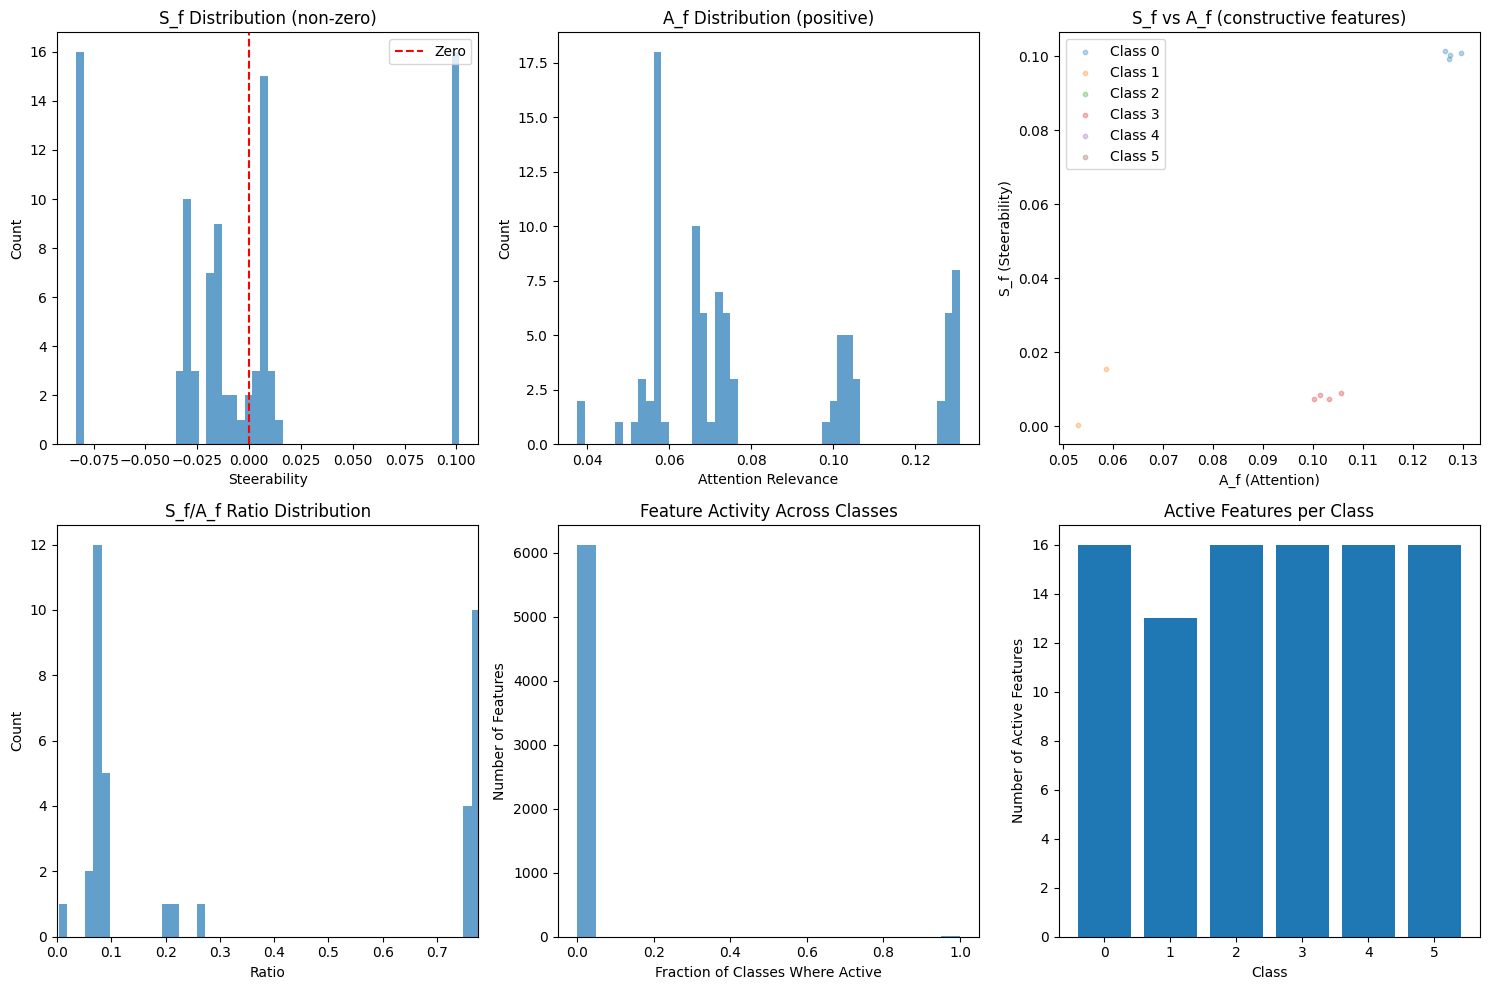



Sanity Checks:
✓ No features with suspiciously high attention but low steerability
✓ Total constructive features: 39 / 36864 (0.1%)
✓ Features that activated at least once: 16 / 6144 (0.3%)


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transmm_sfaf import load_or_build_sf_af_dictionary, load_models

# Load dictionary
sae, vit_model = load_models()
dict_data = load_or_build_sf_af_dictionary(vit_model, sae, dict_path="./results/train/sfaf_dir.pt")

S_f = dict_data["S_f"]
A_f = dict_data["A_f"] 
feature_counts = dict_data["feature_counts"]

print(f"Dictionary info:")
print(f"- S_f shape: {S_f.shape}")
print(f"- Layer: {dict_data['layer_idx']}")
print(f"- Samples used: {dict_data['feature_counts']}")
print("\n" + "="*50 + "\n")

# 1. Basic Statistics
print("S_f Statistics (Steerability):")
print(f"- Min: {S_f.min().item():.4f}")
print(f"- Max: {S_f.max().item():.4f}")
print(f"- Mean: {S_f.mean().item():.4f}")
print(f"- Std: {S_f.std().item():.4f}")
print(f"- % Positive (constructive): {(S_f > 0).float().mean().item()*100:.1f}%")
print(f"- % Negative (contradictory): {(S_f < 0).float().mean().item()*100:.1f}%")

print("\nA_f Statistics (Attention):")
print(f"- Min: {A_f.min().item():.4f}")
print(f"- Max: {A_f.max().item():.4f}")
print(f"- Mean: {A_f.mean().item():.4f}")
print(f"- Std: {A_f.std().item():.4f}")

# 2. Per-class analysis
print("\n" + "="*50 + "\n")
print("Per-Class Analysis:")
for c in range(6):
    s_class = S_f[:, c]
    a_class = A_f[:, c]
    counts = feature_counts[:, c]
    
    # Active features (appeared at least once)
    active_mask = counts > 0
    n_active = active_mask.sum().item()
    
    # Constructive features
    constructive_mask = (s_class > 0) & active_mask
    n_constructive = constructive_mask.sum().item()
    
    print(f"\nClass {c}:")
    print(f"  - Active features: {n_active}")
    print(f"  - Mean S_f (active): {s_class[active_mask].mean().item():.4f}")
    print(f"  - Mean A_f (active): {a_class[active_mask].mean().item():.4f}")

# 3. Find features with high S_f/A_f ratio
print("\n" + "="*50 + "\n")
print("Top Features by S_f/A_f Ratio (for each class):")

epsilon = 1e-3
for c in range(6):
    s_class = S_f[:, c]
    a_class = A_f[:, c]
    
    # Only constructive features
    constructive_mask = (s_class > 0) & (feature_counts[:, c] > 0)
    constructive_indices = constructive_mask.nonzero(as_tuple=True)[0]
    
    if len(constructive_indices) > 0:
        ratios = s_class[constructive_indices] / (a_class[constructive_indices] + epsilon)
        top_indices = ratios.topk(min(5, len(ratios))).indices
        
        print(f"\nClass {c} top features:")
        for i, idx in enumerate(top_indices):
            feat_id = constructive_indices[idx].item()
            print(f"  Feature {feat_id}: S_f={s_class[feat_id]:.4f}, "
                  f"A_f={a_class[feat_id]:.4f}, ratio={ratios[idx]:.2f}")

# 4. Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# S_f distribution
ax = axes[0, 0]
s_flat = S_f[S_f != 0].flatten()  # Exclude zeros
ax.hist(s_flat.detach().numpy(), bins=50, alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', label='Zero')
ax.set_title('S_f Distribution (non-zero)')
ax.set_xlabel('Steerability')
ax.set_ylabel('Count')
ax.legend()

# A_f distribution
ax = axes[0, 1]
a_flat = A_f[A_f > 0].flatten()  # Only positive
ax.hist(a_flat.numpy(), bins=50, alpha=0.7)
ax.set_title('A_f Distribution (positive)')
ax.set_xlabel('Attention Relevance')
ax.set_ylabel('Count')

# S_f vs A_f scatter
ax = axes[0, 2]
# Sample random features for visualization
n_samples = 1000
sample_indices = torch.randperm(S_f.shape[0])[:n_samples]
for c in range(6):
    mask = (S_f[sample_indices, c] > 0) & (feature_counts[sample_indices, c] > 0)
    ax.scatter(A_f[sample_indices, c][mask].detach(), S_f[sample_indices, c][mask], 
               alpha=0.3, s=10, label=f'Class {c}')
ax.set_xlabel('A_f (Attention)')
ax.set_ylabel('S_f (Steerability)')
ax.set_title('S_f vs A_f (constructive features)')
ax.legend()

# Ratio distribution
ax = axes[1, 0]
all_ratios = []
for c in range(6):
    mask = (S_f[:, c] > 0) & (feature_counts[:, c] > 0)
    if mask.any():
        ratios = S_f[:, c][mask] / (A_f[:, c][mask] + epsilon)
        all_ratios.extend(ratios.numpy())
ax.hist(all_ratios, bins=50, alpha=0.7)
ax.set_title('S_f/A_f Ratio Distribution')
ax.set_xlabel('Ratio')
ax.set_ylabel('Count')
ax.set_xlim(0, np.percentile(all_ratios, 95))  # Clip outliers

# Feature activity heatmap
ax = axes[1, 1]
activity = (feature_counts > 0).float().mean(dim=1)  # Fraction of classes where active
ax.hist(activity.numpy(), bins=20, alpha=0.7)
ax.set_title('Feature Activity Across Classes')
ax.set_xlabel('Fraction of Classes Where Active')
ax.set_ylabel('Number of Features')

# Class balance
ax = axes[1, 2]
class_feature_counts = (feature_counts > 0).sum(dim=0).numpy()
ax.bar(range(6), class_feature_counts)
ax.set_title('Active Features per Class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Active Features')

plt.tight_layout()
plt.savefig('./results/val_weighted/sfaf_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 5. Sanity checks
print("\n" + "="*50 + "\n")
print("Sanity Checks:")

# Check if any features have very high A_f but low S_f (might indicate dead features)
low_ratio_mask = (S_f > 0) & (A_f > 0.5) & (S_f / (A_f + epsilon) < 0.1)
if low_ratio_mask.any():
    print(f"⚠️  Found {low_ratio_mask.sum().item()} features with high attention but low steerability")
else:
    print("✓ No features with suspiciously high attention but low steerability")

# Check if we have enough constructive features
total_constructive = (S_f > 0).sum().item()
print(f"✓ Total constructive features: {total_constructive} / {S_f.numel()} ({total_constructive/S_f.numel()*100:.1f}%)")

# Check feature coverage
features_used = (feature_counts > 0).any(dim=1).sum().item()
print(f"✓ Features that activated at least once: {features_used} / {S_f.shape[0]} ({features_used/S_f.shape[0]*100:.1f}%)")

In [2]:
# Quick diagnostic on your dictionary
dict_data = torch.load("./results/train/sfaf_dir.pt")
S_f = dict_data["S_f"]

# Check S_f magnitudes
print("S_f stats:")
print(f"Mean abs(S_f): {S_f.abs().mean():.6f}")
print(f"Max abs(S_f): {S_f.abs().max():.6f}")
print(f"% near zero: {(S_f.abs() < 1e-6).float().mean()*100:.1f}%")

# Check A_f distribution
print("\nA_f stats:")
print(f"Mean A_f (where S_f > 0): {A_f[S_f > 0].mean():.4f}")
print(f"% with A_f > 0.1: {(A_f > 0.1).float().mean()*100:.1f}%")

# Look at ratio distribution
ratios = S_f / (A_f + 1e-3)
print(f"\nRatio stats (constructive only):")
print(f"Max ratio: {ratios[S_f > 0].max():.2f}")
print(f"% ratios > 1.0: {(ratios[S_f > 0] > 1.0).float().mean()*100:.1f}%")

S_f stats:
Mean abs(S_f): 0.000105
Max abs(S_f): 0.101422
% near zero: 99.7%

A_f stats:
Mean A_f (where S_f > 0): 0.1044
% with A_f > 0.1: 0.1%

Ratio stats (constructive only):
Max ratio: 0.80
% ratios > 1.0: 0.0%


In [12]:
w_dec_norms = torch.norm(sae.W_dec, dim=1)
print(f"Mean W_dec norm: {w_dec_norms.mean().item()}")
print(f"Std W_dec norm: {w_dec_norms.std().item()}")

Mean W_dec norm: 1.0
Std W_dec norm: 5.101478794955483e-09


In [14]:
def debug_ln_final_autograd(model: 'HookedSAEViT'):
    """
    A minimal test to verify if the autograd computation graph is preserved
    across the final LayerNorm and Head.
    """
    print("\n--- Running Minimal `ln_final` Autograd Sanity Check ---")
    
    device = next(model.parameters()).device
    d_model = model.cfg.d_model
    batch_size = 4
    n_tokens = 197 # Standard for ViT-B/16
    n_classes = model.head.out_features

    # --- 1. Create a simple input tensor ---
    # This tensor simulates the output of the final transformer block.
    # It MUST have requires_grad=True from the start.
    x = torch.randn(batch_size, n_tokens, d_model, device=device, requires_grad=True)
    
    # Create some dummy labels
    labels = torch.randint(0, n_classes, (batch_size,), device=device)

    # --- 2. Pass through the suspect components ---
    print(f"Input tensor shape: {x.shape}")
    print(f"Input requires_grad: {x.requires_grad}")

    y = model.ln_final(x)
    print(f"\nAfter ln_final, shape: {y.shape}")
    print(f"After ln_final, requires_grad: {y.requires_grad}")
    
    # We only care about the CLS token for the head
    cls_token = y[:, 0]
    print(f"\nCLS token shape: {cls_token.shape}")
    print(f"CLS token requires_grad: {cls_token.requires_grad}")
    
    logits = model.head(cls_token)
    print(f"\nAfter head, shape: {logits.shape}")
    print(f"After head, requires_grad: {logits.requires_grad}")

    # If requires_grad is False at any step, the graph is broken.
    if not logits.requires_grad:
        print("\n\n!!! FAILURE: The computation graph was broken. `logits` does not require a gradient.")
        return

    # --- 3. Calculate the gradient ---
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).float()
    target_loss = (logits * one_hot_labels).sum()
    
    # This is the crucial step. If the graph is intact, this will succeed.
    try:
        grad = torch.autograd.grad(target_loss, x)[0]
    except Exception as e:
        print(f"\n\n!!! FAILURE: `torch.autograd.grad` call failed with error: {e}")
        return
        
    # --- 4. Analyze the gradient ---
    print("\n\n--- Gradient Analysis ---")
    print(f"Gradient shape: {grad.shape}")
    grad_norm = torch.norm(grad)
    print(f"Gradient L2 Norm: {grad_norm.item():.6f}")

    if grad_norm > 1e-6:
        print("\n\n>>> SUCCESS: The autograd graph is INTACT through `ln_final` and `head`.")
        print(">>> The gradient is non-zero. The small magnitude is a real property of the network, not a bug in autograd.")
    else:
        print("\n\n!!! FAILURE: The autograd graph is intact, but the gradient is numerically zero.")
        print("!!! This points to a mathematical vanishing issue, not a graph-break issue.")

debug_ln_final_autograd(vit_model)


--- Running Minimal `ln_final` Autograd Sanity Check ---
Input tensor shape: torch.Size([4, 197, 768])
Input requires_grad: True

After ln_final, shape: torch.Size([4, 197, 768])
After ln_final, requires_grad: True

CLS token shape: torch.Size([4, 768])
CLS token requires_grad: True

After head, shape: torch.Size([4, 6])
After head, requires_grad: True


--- Gradient Analysis ---
Gradient shape: torch.Size([4, 197, 768])
Gradient L2 Norm: 3.282413


>>> SUCCESS: The autograd graph is INTACT through `ln_final` and `head`.
>>> The gradient is non-zero. The small magnitude is a real property of the network, not a bug in autograd.


In [19]:
from vit_prisma.sae import SparsecoderEval
import torchvision
from vit.preprocessing import get_processor_for_precached_224_images

label_map = {2: 3, 3: 2}  # original label 0 -> new label 2, original label 1 -> new label 0

def custom_target_transform(target):
    return label_map.get(target, target)

val_path = "./hyper-kvasir_imagefolder/val"
val_dataset = torchvision.datasets.ImageFolder(val_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform)
dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
import torch

def debug_real_vs_random_input(
    model: 'HookedSAEViT',
    dataloader: torch.utils.data.DataLoader
):
    """
    The definitive test to prove that the vanishing gradient is a property
    of the real, learned activations, not the ln_final function itself.
    """
    print("\n--- Running Definitive 'Real vs. Random' Gradient Check ---")
    
    device = next(model.parameters()).device
    n_classes = model.head.out_features
    batch_size = 4
    
    # Get a single batch of images and labels
    imgs, labels = next(iter(dataloader))
    imgs, labels = imgs.to(device), la/bels.to(device)
    # Use only the first few samples for speed
    imgs, labels = imgs[:batch_size], labels[:batch_size]

    # --- 1. Get the REAL input to ln_final ---
    print("\n--- Part 1: Using REAL Activations from the Model ---")
    with torch.no_grad():
        # Run the model up to the final block to get the real activations
        x_real = model(imgs, stop_at_layer=model.cfg.n_layers)
    
    # Ensure it requires a gradient for the test
    x_real.requires_grad_(True)
    
    print(f"Shape of real activations: {x_real.shape}")
    print(f"L2 Norm of real activations: {torch.norm(x_real).item():.4f}")
    print(f"Mean of real activations: {x_real.mean().item():.4f}")
    print(f"Std of real activations: {x_real.std().item():.4f}")

    # Pass x_real through the final layers
    y_real = model.ln_final(x_real)
    logits_real = model.head(y_real[:, 0])
    
    # Calculate loss and gradient
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).float()
    loss_real = (logits_real * one_hot_labels).sum()
    grad_real = torch.autograd.grad(loss_real, x_real)[0]
    
    print(f"\nResulting Gradient Norm (from REAL input): {torch.norm(grad_real).item():.6f}")

    # --- 2. Get the RANDOM input, normalized to match the REAL one ---
    print("\n--- Part 2: Using RANDOM Activations of the Same Magnitude ---")
    
    # Create random noise with the same shape
    x_random = torch.randn_like(x_real)
    
    # CRITICAL: Rescale the random noise to have the exact same L2 norm as the real activations.
    # This makes the comparison perfectly fair.
    x_random = x_random / torch.norm(x_random) * torch.norm(x_real)
    x_random.requires_grad_(True)
    
    print(f"Shape of random activations: {x_random.shape}")
    print(f"L2 Norm of random activations: {torch.norm(x_random).item():.4f} (matched to real)")
    
    # Pass x_random through the final layers
    y_random = model.ln_final(x_random)
    logits_random = model.head(y_random[:, 0])
    
    # Calculate loss and gradient
    loss_random = (logits_random * one_hot_labels).sum()
    grad_random = torch.autograd.grad(loss_random, x_random)[0]
    
    print(f"\nResulting Gradient Norm (from RANDOM input): {torch.norm(grad_random).item():.6f}")
    
    # --- 3. Conclusion ---
    print("\n\n--- Conclusion ---")
    if torch.norm(grad_random) > torch.norm(grad_real) * 2:
        print(">>> SUCCESS: The test confirms the hypothesis.")
        print(">>> The gradient for REAL, structured input is significantly smaller than for RANDOM input of the same magnitude.")
        print(">>> This proves the vanishing gradient is a LEARNED PROPERTY of the network's activations, not a bug.")
    else:
        print("!!! The test is inconclusive or refutes the hypothesis. Something else is going on.")

debug_real_vs_random_input(vit_model, dataloader)


--- Running Definitive 'Real vs. Random' Gradient Check ---

--- Part 1: Using REAL Activations from the Model ---
Shape of real activations: torch.Size([4, 197, 768])
L2 Norm of real activations: 4935.4448
Mean of real activations: -0.1181
Std of real activations: 6.3432

Resulting Gradient Norm (from REAL input): 0.442236

--- Part 2: Using RANDOM Activations of the Same Magnitude ---
Shape of random activations: torch.Size([4, 197, 768])
L2 Norm of random activations: 4935.4448 (matched to real)

Resulting Gradient Norm (from RANDOM input): 0.514212


--- Conclusion ---
!!! The test is inconclusive or refutes the hypothesis. Something else is going on.


2025-06-27 19:22:09 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-27 19:22:09 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-06-27 19:22:09 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-06-27 19:22:10 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-06-27 19:22:10 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-27 19:22:10 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-27 19:22:11 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-27 19:22:11 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-27 19:22:11 INFO:root: Filling in 2 missing keys with default initialization
2025-06-27 19:22:11 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-27 19:22:11 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream


2025-06-27 19:22:11 INFO:matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-27 19:22:11 INFO:matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./results/train/sfaf_dir.pt

Dictionary layer 9  –  features 6144  classes 6
879 features never fired in the build set

Global |S_f| percentiles:
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0063e-03, 2.1321e-02, 7.4809e-02,
        5.6931e-01, 1.0118e+01])
class 0 |S_f| percentiles: [0.0, 0.0, 0.0, 0.0, 0.011498956009745598, 0.03821474313735962, 0.4138137102127075, 7.931657314300537]
class 1 |S_f| percentiles: [0.0, 0.0, 0.0, 0.0, 0.01583019830286503, 0.0831933468580246, 0.4186689555644989, 3.9779815673828125]
class 2 |S_f| percentiles: [0.0, 0.0, 0.0, 0.008053993806242943, 0.02808072790503502, 0.09091521054506302, 0.5951763987541199, 10.117779731750488]
class 3 |S_f| percentiles: [0.0, 0.0, 0.0, 0.004839962348341942, 0.019861038774251938, 0.06438198685646057, 0.5892320871353149, 6.600679397583008]
class 4 |S_f| percentiles: [0.0, 0.0, 0.0, 0.007549495901912451, 0.024911271408200264, 0.077

2025-06-27 19:22:11 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x72648005f910>



Most constructive per class (|z| based)
class 0  feat 3092  S=4.7711  A=0.7043  ratio=6.77
class 0  feat 3821  S=3.8558  A=0.5537  ratio=6.96
class 0  feat 2251  S=3.4955  A=0.6154  ratio=5.68
class 0  feat 5155  S=3.4191  A=0.6009  ratio=5.69
class 0  feat 4244  S=3.3777  A=0.6051  ratio=5.58
class 1  feat 5715  S=3.1600  A=0.3343  ratio=9.45
class 1  feat 3809  S=3.0046  A=0.2493  ratio=12.05
class 1  feat  815  S=2.9156  A=0.3193  ratio=9.13
class 1  feat 2006  S=2.8776  A=0.3517  ratio=8.18
class 1  feat 1234  S=2.5713  A=0.3035  ratio=8.47
class 2  feat 3092  S=5.8011  A=0.6334  ratio=9.16
class 2  feat 2248  S=3.7926  A=0.3611  ratio=10.50
class 2  feat 5838  S=3.7005  A=0.3606  ratio=10.26
class 2  feat 5239  S=3.5517  A=0.4743  ratio=7.49
class 2  feat  574  S=2.9696  A=0.4062  ratio=7.31
class 3  feat 1234  S=4.9861  A=0.3563  ratio=13.99
class 3  feat 1735  S=4.0653  A=0.2154  ratio=18.87
class 3  feat 1771  S=4.0213  A=0.4327  ratio=9.29
class 3  feat 2746  S=3.2529  A=0.36

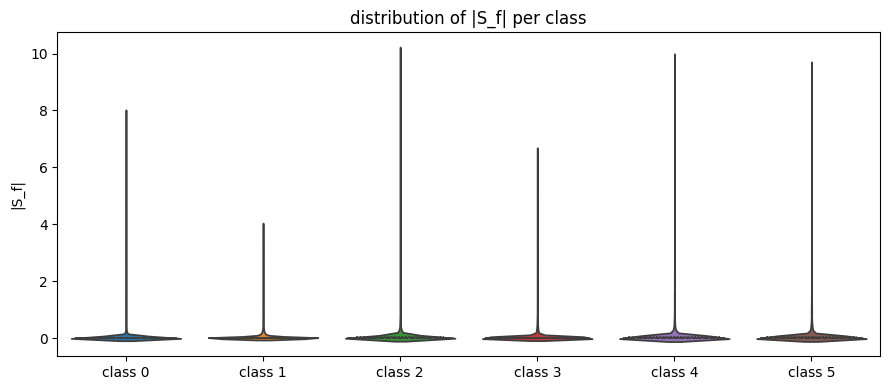

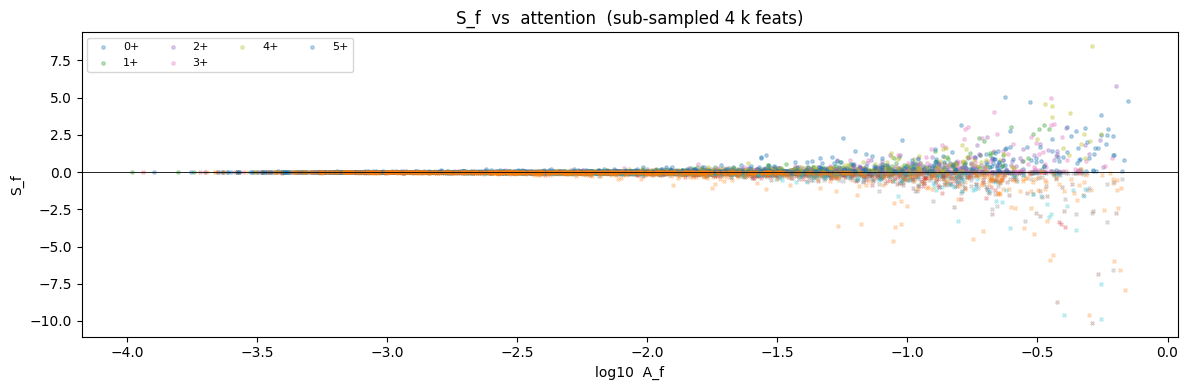

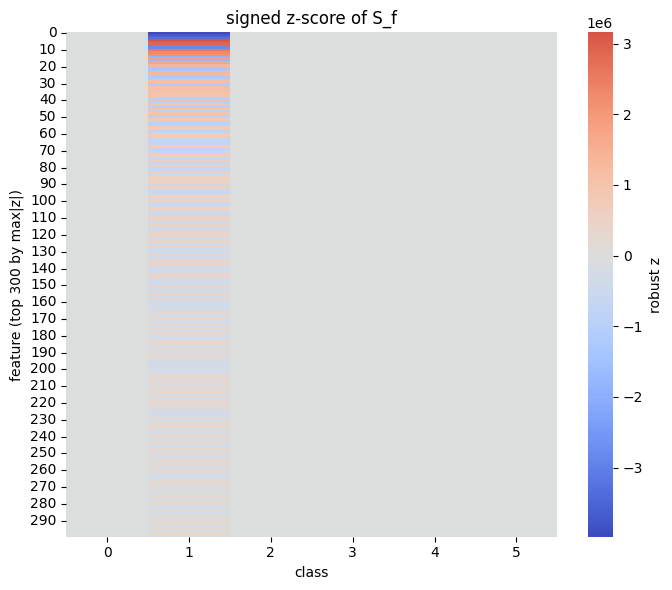

In [2]:
# dict_debug.py
import torch, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from transmm_sfaf import load_or_build_sf_af_dictionary, load_models

# ------------------------------------------------------------------
# 0. load data
# ------------------------------------------------------------------
sae, vit = load_models()
sfaf_path = "./results/train/sfaf_dir.pt"
d = load_or_build_sf_af_dictionary(vit, sae, dict_path=sfaf_path)

S, A, N = d["S_f"], d["A_f"] + 1e-9, d["feature_counts"]      # (F, C)
F, C = S.shape

print(f"\nDictionary layer {d['layer_idx']}  –  features {F}  classes {C}")

# ------------------------------------------------------------------
# 1. basic sanity
# ------------------------------------------------------------------
assert torch.isfinite(S).all() and torch.isfinite(A).all(), "NaNs detected"
dead_feats = (N.sum(1) == 0).sum().item()
print(f"{dead_feats} features never fired in the build set")

# ------------------------------------------------------------------
# 2. percentiles (global + per class)
# ------------------------------------------------------------------
def pct(x):   # tiny helper
    return torch.quantile(x, torch.tensor([.0,.1,.25,.5,.75,.9,.98,1.]))

print("\nGlobal |S_f| percentiles:")
print(pct(S.abs()))

for c in range(C):
    s_c = S[:, c].abs()
    print(f"class {c} |S_f| percentiles:", pct(s_c).tolist())

# ------------------------------------------------------------------
# 3. per-class violin of |S_f|
# ------------------------------------------------------------------
plt.figure(figsize=(9,4))
sns.violinplot(data=[S[:,c].abs().cpu().numpy() for c in range(C)],
               inner="quartile")
plt.xticks(range(C), [f"class {c}" for c in range(C)])
plt.ylabel("|S_f|")
plt.title("distribution of |S_f| per class")
plt.tight_layout()

# ------------------------------------------------------------------
# 4. scatter   log A_f  vs  S_f
# ------------------------------------------------------------------
sample = torch.randperm(F)[:4000]            # subsample for clarity
logA = A[sample].log10()                     # (F,C)
S_s  = S[sample]

plt.figure(figsize=(12,4))
for c in range(C):
    pos = S_s[:,c] > 0
    neg = S_s[:,c] < 0
    plt.scatter(logA[:,c][pos], S_s[:,c][pos], s=6, alpha=.3, label=f"{c}+")
    plt.scatter(logA[:,c][neg], S_s[:,c][neg], s=6, alpha=.3, marker='x')

plt.xlabel("log10  A_f")
plt.ylabel("S_f")
plt.axhline(0,c='k',lw=.6)
plt.legend(ncol=4, fontsize=8)
plt.title("S_f  vs  attention  (sub-sampled 4 k feats)")
plt.tight_layout()

# ------------------------------------------------------------------
# 5. heat-map  of  z-scores  per feature / class
# ------------------------------------------------------------------
# robust z-score so classes are comparable
z = torch.empty_like(S)
for c in range(C):
    med = S[:,c].median()
    iqr = (S[:,c].quantile(.75) - S[:,c].quantile(.25)).clamp_(1e-6)
    z[:,c] = (S[:,c] - med) / iqr

plt.figure(figsize=(7,6))
# show only the most extreme 300 features for readability
top = torch.topk(z.abs().max(1).values, 300).indices
sns.heatmap(z[top].cpu(), cmap="coolwarm", center=0, cbar_kws=dict(label="robust z"))
plt.xlabel("class")
plt.ylabel("feature (top 300 by max|z|)")
plt.title("signed z-score of S_f")
plt.tight_layout()

# ------------------------------------------------------------------
# 6. report “interesting” features
# ------------------------------------------------------------------
print("\nMost constructive per class (|z| based)")
for c in range(C):
    s = z[:,c]
    best = torch.topk(s, 5).indices
    for f in best:
        print(f"class {c}  feat {f.item():4d}  S={S[f,c]:.4f}  A={A[f,c]:.4f}  "
              f"ratio={S[f,c].abs()/(A[f,c]):.2f}")

print("\nMost contradictory per class")
for c in range(C):
    s = z[:,c]
    worst = torch.topk(-s, 5).indices
    for f in worst:
        print(f"class {c}  feat {f.item():4d}  S={S[f,c]:.4f}  A={A[f,c]:.4f}  "
              f"ratio={(S[f,c].abs()/A[f,c]):.2f}")

# ------------------------------------------------------------------
# 7. save figures
# ------------------------------------------------------------------
out_dir = Path("./results/debug").mkdir(exist_ok=True, parents=True)
for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(f"./results/debug/dict_diag_{i}.png", dpi=150, bbox_inches='tight')

print("\nFigures written to  ./results/debug/")


2025-06-28 13:51:53 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-28 13:51:53 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


Loading models (required for dictionary build if not found)...


2025-06-28 13:51:54 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-06-28 13:51:54 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-06-28 13:51:54 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-28 13:51:55 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-28 13:51:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-28 13:51:55 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-28 13:51:55 INFO:root: Filling in 2 missing keys with default initialization
2025-06-28 13:51:55 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-28 13:51:55 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream


2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([], dtype=float64)
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:5

Converting the weights of a timm model to a Prisma ViT
Attempting to load dictionary from: ./results/train/sfaf_dir.pt
Loading existing S_f/A_f dictionary from ./results/train/sfaf_dir.pt

--- Analysis of Dictionary for Layer 9 ---
Features: 6144, Classes: 6, Samples: 16420

[1] Sanity Check: 879 of 6144 features (14.3%) never fired.

[2] Percentiles for S_f (Steerability):
    0%: -10.1178
    1%: -0.6475
   10%: -0.0361
   25%: -0.0076
   50%: 0.0000
   75%: 0.0074
   90%: 0.0358
   99%: 0.6928
  100%: 8.4595

[2] Percentiles for A_f (Attention Relevance):
    0%: 0.0000
    1%: 0.0000
   10%: 0.0000
   25%: 0.0000
   50%: 0.0042
   75%: 0.0149
   90%: 0.0508
   99%: 0.3246
  100%: 0.7043

[3] Generating joint scatter plot...

[4] Performing rank-based analysis...


2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([], dtype=float64)
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:55 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:5


[5] Reporting most interesting features per class (High Impact, Low Attention)
--------------------------------------------------------------------------------

Class 0: Top 5 'High Impact, Low Attention' Features
Original Idx        S_f          A_f   |S_f| Rank   A_f Rank
        1548     0.0465   3.7558e-03      89.95%    49.45%
        3530     0.0439   3.0147e-03      89.49%    47.64%
        5806     0.0412   2.4645e-03      88.89%    46.18%
        4017    -0.0412   3.1863e-03      88.87%    47.93%
        3427    -0.0398   2.4494e-03      88.62%    46.16%

Class 2: Top 5 'High Impact, Low Attention' Features
Original Idx        S_f          A_f   |S_f| Rank   A_f Rank
        4536    -0.1997   6.0161e-03      93.50%    47.42%
        1121     0.1129   5.0737e-03      90.41%    42.57%
        6134     0.1114   5.6583e-03      90.25%    45.71%
         344     0.0951   3.9723e-03      89.10%    36.30%
        3005     0.0918   4.9791e-03      88.54%    42.15%

Class 3: Top 5 'Hi

2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([], dtype=float64)
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:5


[6] Analysis complete. Figures saved to results/debug/


2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([], dtype=float64)
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: vmin 3.610866410385118e-10 vmax 1.9505625512491864
2025-06-28 13:51:56 DEBUG:matplotlib.ticker: ticklocs array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02,
       1.e+04])


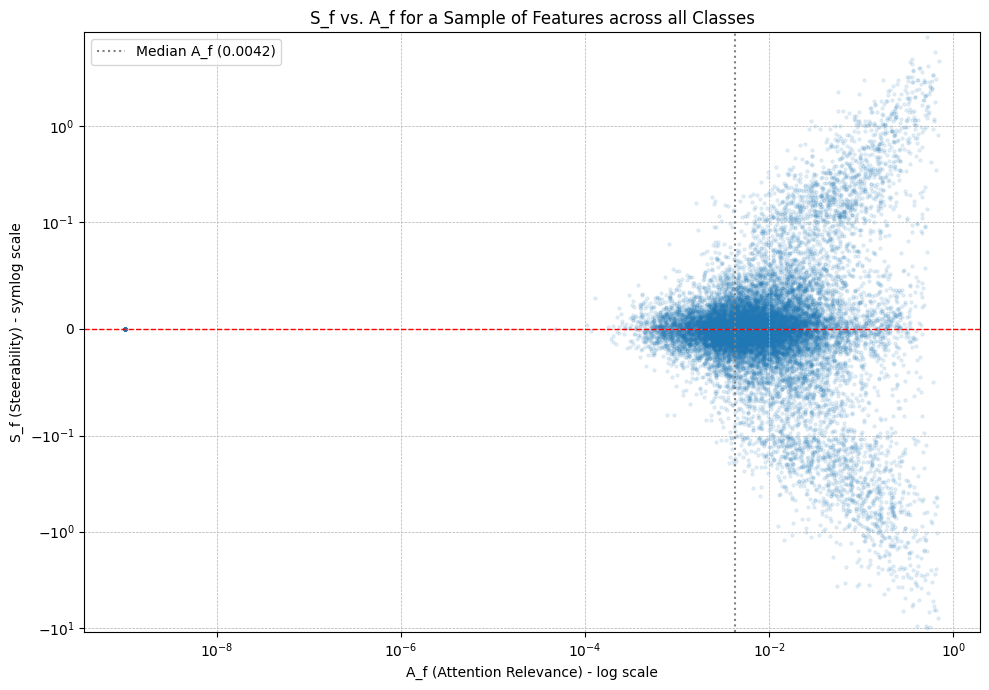

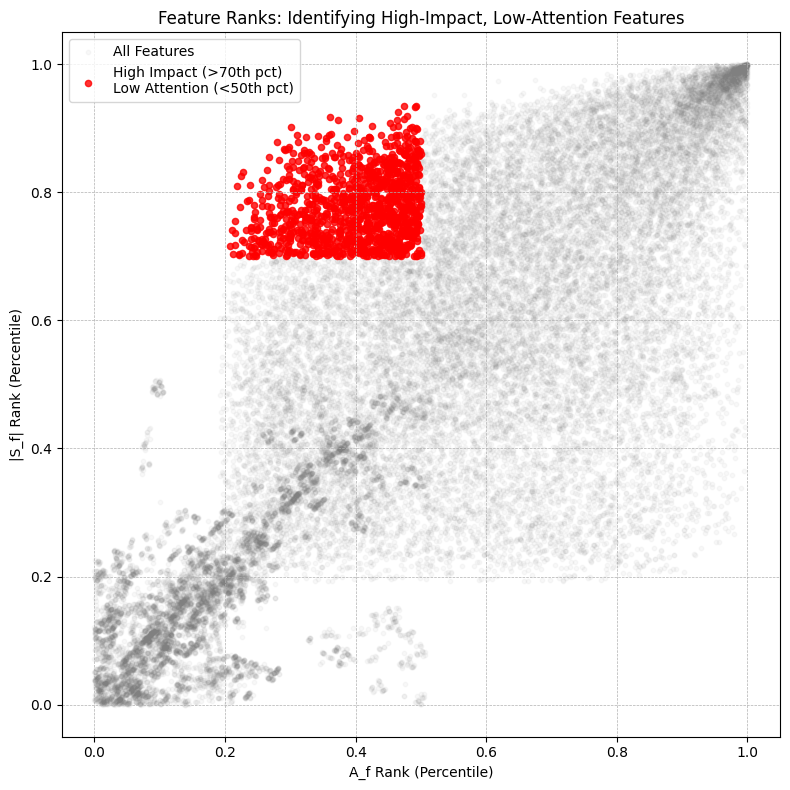

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

# ------------------------------------------------------------------
# 0. Load Data
# ------------------------------------------------------------------
# This section is now configured to use your real data loading functions.
# It assumes 'transmm_sfaf.py' is in your path.

from transmm_sfaf import load_or_build_sf_af_dictionary, load_models

print("Loading models (required for dictionary build if not found)...")
sae, vit = load_models()

sfaf_path = "./results/train/sfaf_dir.pt"
print(f"Attempting to load dictionary from: {sfaf_path}")
# This function should load the dictionary if it exists, or build it if it doesn't.
d = load_or_build_sf_af_dictionary(vit, sae, dict_path=sfaf_path)


S, A, N = d["S_f"], d["A_f"] + 1e-9, d["feature_counts"]  # (F, C), add epsilon to A
F, C = S.shape

print(f"\n--- Analysis of Dictionary for Layer {d['layer_idx']} ---")
print(f"Features: {F}, Classes: {C}, Samples: {d.get('n_samples', 'N/A')}")

# ------------------------------------------------------------------
# 1. Basic Sanity Checks
# ------------------------------------------------------------------
assert torch.isfinite(S).all() and torch.isfinite(A).all(), "NaNs or Infs detected in S_f or A_f"
live_mask = N.sum(1) > 0
dead_feats = (~live_mask).sum().item()
print(f"\n[1] Sanity Check: {dead_feats} of {F} features ({dead_feats/F:.1%}) never fired.")

# Filter out dead features for cleaner analysis
S, A, N = S[live_mask], A[live_mask], N[live_mask]
F_live = S.shape[0]

# ------------------------------------------------------------------
# 2. Distribution Analysis (Global Percentiles)
# ------------------------------------------------------------------
def pct_summary(tensor, name):
    p = torch.tensor([0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1.0])
    q = torch.quantile(tensor.flatten(), p)
    print(f"\n[2] Percentiles for {name}:")
    for i, val in zip(p, q):
        print(f"  {i*100:3.0f}%: {val:.4f}")

pct_summary(S, "S_f (Steerability)")
pct_summary(A, "A_f (Attention Relevance)")
# This will clearly show the different scales, e.g., S_f might range from -50 to 50,
# while A_f might be mostly between 0 and 0.1.

# ------------------------------------------------------------------
# 3. Visualization: Joint Scatter Plot of S_f vs A_f
# ------------------------------------------------------------------
print("\n[3] Generating joint scatter plot...")
sample_size = min(4000, F_live)
sample_indices = torch.randperm(F_live)[:sample_size]
S_sample, A_sample = S[sample_indices], A[sample_indices]

# Flatten for plotting
S_flat, A_flat = S_sample.flatten(), A_sample.flatten()

fig, ax = plt.subplots(figsize=(10, 7))
# Use log scale for A_f as it's likely skewed towards zero
# Use symlog for S_f to handle positive and negative values gracefully
ax.scatter(A_flat, S_flat, alpha=0.1, s=5, rasterized=True)
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=0.1) # Symlog is good for values around zero
ax.set_xlabel("A_f (Attention Relevance) - log scale")
ax.set_ylabel("S_f (Steerability) - symlog scale")
ax.set_title("S_f vs. A_f for a Sample of Features across all Classes")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axhline(0, color='r', linestyle='--', linewidth=1)
ax.axvline(A.median(), color='gray', linestyle=':', label=f'Median A_f ({A.median():.4f})')
ax.legend()
plt.tight_layout()


# ------------------------------------------------------------------
# 4. Rank-based Normalization and Analysis
# ------------------------------------------------------------------
print("\n[4] Performing rank-based analysis...")
# Convert values to percentiles (ranks from 0 to 1) for robust comparison
S_rank = S.abs().argsort(dim=0).argsort(dim=0).float() / (F_live - 1)
A_rank = A.argsort(dim=0).argsort(dim=0).float() / (F_live - 1)

# Define our categories of interest
high_S_thresh = 0.7  # Top 5% S_f magnitude
low_A_thresh = 0.50   # Bottom 50% A_f

# Our main target: High Impact, Low Attention
high_impact_low_attention_mask = (S_rank > high_S_thresh) & (A_rank < low_A_thresh)

# Other interesting categories
high_impact_high_attention_mask = (S_rank > high_S_thresh) & (A_rank > high_S_thresh)

# Visualize the ranks
fig_rank, ax_rank = plt.subplots(figsize=(8, 8))
s_rank_flat = S_rank.flatten()
a_rank_flat = A_rank.flatten()
hila_flat = high_impact_low_attention_mask.flatten()

# Plot all points in gray
ax_rank.scatter(a_rank_flat, s_rank_flat, c='gray', alpha=0.05, s=10, rasterized=True, label='All Features')
# Highlight the interesting points
ax_rank.scatter(a_rank_flat[hila_flat], s_rank_flat[hila_flat], c='red', alpha=0.8, s=20, label=f'High Impact (>{high_S_thresh*100:.0f}th pct)\nLow Attention (<{low_A_thresh*100:.0f}th pct)')
ax_rank.set_xlabel("A_f Rank (Percentile)")
ax_rank.set_ylabel("|S_f| Rank (Percentile)")
ax_rank.set_title("Feature Ranks: Identifying High-Impact, Low-Attention Features")
ax_rank.legend()
ax_rank.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()


# ------------------------------------------------------------------
# 5. Report Top "Interesting" Features per Class
# ------------------------------------------------------------------
print("\n[5] Reporting most interesting features per class (High Impact, Low Attention)")
print("-" * 80)
original_indices = torch.arange(d["S_f"].shape[0])[live_mask] # Map filtered index back to original

for c in range(C):
    # Find features in this class that satisfy the condition
    class_mask = high_impact_low_attention_mask[:, c]
    if class_mask.sum() == 0:
        continue
        
    # Get the indices of these features
    feature_indices_in_filtered_tensor = torch.where(class_mask)[0]
    
    # Get their S_f values to find the most impactful among them
    s_values = S[feature_indices_in_filtered_tensor, c]
    
    # Sort by descending S_f magnitude and take top 5
    top_k = min(5, len(s_values))
    top_indices_in_subset = s_values.abs().topk(top_k).indices
    
    final_indices = feature_indices_in_filtered_tensor[top_indices_in_subset]
    
    print(f"\nClass {c}: Top {top_k} 'High Impact, Low Attention' Features")
    print(f"{'Original Idx':>12s} {'S_f':>10s} {'A_f':>12s} {'|S_f| Rank':>12s} {'A_f Rank':>10s}")

    for idx in final_indices:
        original_idx = original_indices[idx].item()
        s_val = S[idx, c].item()
        a_val = A[idx, c].item()
        s_rk = S_rank[idx, c].item()
        a_rk = A_rank[idx, c].item()
        print(f"{original_idx:12d} {s_val:10.4f} {a_val:12.4e} {s_rk:11.2%} {a_rk:9.2%}")

# ------------------------------------------------------------------
# 6. Save Figures
# ------------------------------------------------------------------
out_dir = Path("./results/debug")
out_dir.mkdir(exist_ok=True, parents=True)
for i in plt.get_fignums():
    fig = plt.figure(i)
    # Use a high DPI and tight bounding box for quality
    fig.savefig(out_dir / f"dict_diag_{i}.png", dpi=200, bbox_inches='tight')

print(f"\n[6] Analysis complete. Figures saved to {out_dir}/")

2025-06-28 13:57:40 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-06-28 13:57:40 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


Loading models (required for dictionary build if not found)...


2025-06-28 13:57:40 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-06-28 13:57:40 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-06-28 13:57:40 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-06-28 13:57:41 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-06-28 13:57:41 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-06-28 13:57:41 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-28 13:57:41 INFO:root: Filling in 2 missing keys with default initialization
2025-06-28 13:57:41 WARNING:root: Missing key for weight matrix: head.W_H
2025-06-28 13:57:41 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Attempting to load dictionary from: ./results/train/sfaf_dir.pt
Loading existing S_f/A_f dictionary from ./results/train/sfaf_dir.pt

--- Analysis of Dictionary for Layer 9 ---
Features: 6144, Classes: 6, Samples: 16420
Sanity Check: 879 of 6144 features (14.3%) never fired.

[1] Performing rank-based analysis...

[2] Summary of 'Unseen' Features per Class
(Thresholds: S_f > 90%, S_f < 10%, A_f < 50%)
 Class  Live Feats  Constructive (+) % Constr.  Destructive (-) % Destr.
     0        2990                 6     0.20%               20    0.67%
     1        2594                 0     0.00%                0    0.00%
     2        4251                26     0.61%               38    0.89%
     3        3873                55     1.42%               46    1.19%
     4        4153                33     0.79%            

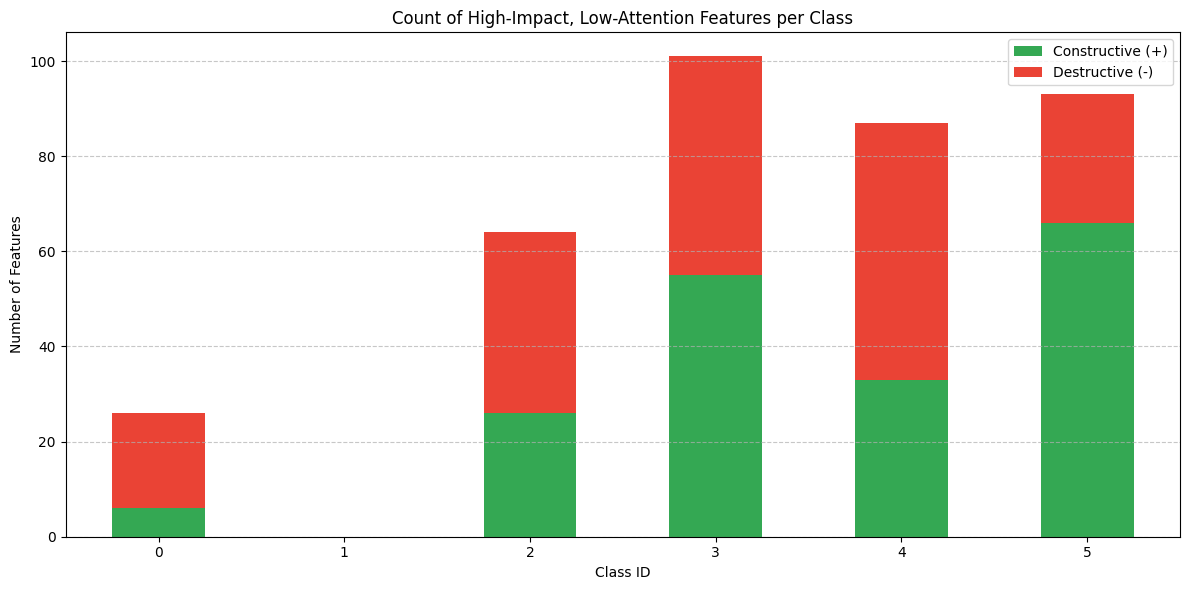

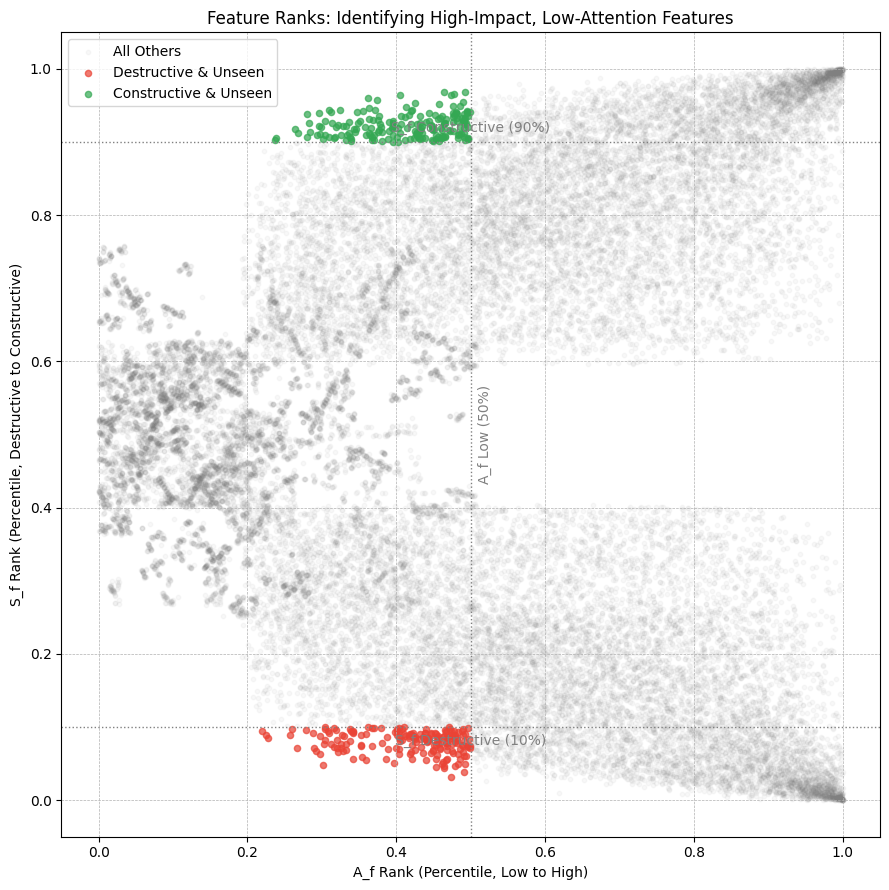

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import logging

# ------------------------------------------------------------------
# SETUP
# ------------------------------------------------------------------

# 1. Suppress noisy matplotlib debug logs
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# 2. Define flexible thresholds for analysis
# An S_f rank > 0.9 means the feature is in the top 10% most *positive* (constructive)
S_POS_THRESH = 0.90
# An S_f rank < 0.1 means the feature is in the bottom 10% most *negative* (destructive)
S_NEG_THRESH = 0.10
# An A_f rank < 0.5 means the feature has below-median attention relevance
A_LOW_THRESH = 0.50


# ------------------------------------------------------------------
# 0. Load Data
# ------------------------------------------------------------------
try:
    from transmm_sfaf import load_or_build_sf_af_dictionary, load_models
    print("Loading models (required for dictionary build if not found)...")
    sae, vit = load_models()
    sfaf_path = "./results/train/sfaf_dir_l6.pt"
    print(f"Attempting to load dictionary from: {sfaf_path}")
    d = load_or_build_sf_af_dictionary(vit, sae, dict_path=sfaf_path)
except ImportError:
    print("Could not import from 'transmm_sfaf'. Aborting.")
    exit()

S, A, N = d["S_f"], d["A_f"] + 1e-9, d["feature_counts"]
F, C = S.shape

print(f"\n--- Analysis of Dictionary for Layer {d['layer_idx']} ---")
print(f"Features: {F}, Classes: {C}, Samples: {d.get('n_samples', 'N/A')}")

# Filter out dead features for cleaner analysis
live_mask = N.sum(1) > 0
dead_feats = (~live_mask).sum().item()
print(f"Sanity Check: {dead_feats} of {F} features ({dead_feats/F:.1%}) never fired.")

S, A, N = S[live_mask], A[live_mask], N[live_mask]
F_live = S.shape[0]

# ------------------------------------------------------------------
# 1. Rank-based Normalization & Masking
# ------------------------------------------------------------------
print("\n[1] Performing rank-based analysis...")
# Rank S_f directly to preserve sign. High rank = highly positive. Low rank = highly negative.
S_rank = S.argsort(dim=0).argsort(dim=0).float() / (F_live - 1)
A_rank = A.argsort(dim=0).argsort(dim=0).float() / (F_live - 1)

# Main categories of interest: High Impact, Low Attention
constructive_unseen_mask = (S_rank > S_POS_THRESH) & (A_rank < A_LOW_THRESH)
destructive_unseen_mask = (S_rank < S_NEG_THRESH) & (A_rank < A_LOW_THRESH)

# ------------------------------------------------------------------
# 2. Summary Overview: Table
# ------------------------------------------------------------------
print(f"\n[2] Summary of 'Unseen' Features per Class")
print(f"(Thresholds: S_f > {S_POS_THRESH:.0%}, S_f < {S_NEG_THRESH:.0%}, A_f < {A_LOW_THRESH:.0%})")

summary_data = []
for c in range(C):
    live_in_class = (N[:, c] > 0).sum().item()
    const_count = constructive_unseen_mask[:, c].sum().item()
    destr_count = destructive_unseen_mask[:, c].sum().item()
    summary_data.append({
        "Class": c,
        "Live Feats": live_in_class,
        "Constructive (+)": const_count,
        "% Constr.": f"{const_count / live_in_class:.2%}" if live_in_class > 0 else "N/A",
        "Destructive (-)": destr_count,
        "% Destr.": f"{destr_count / live_in_class:.2%}" if live_in_class > 0 else "N/A",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# ------------------------------------------------------------------
# 3. Summary Overview: Visualization
# ------------------------------------------------------------------
print("\n[3] Generating summary bar chart...")
fig, ax = plt.subplots(figsize=(12, 6))
summary_df.plot(
    x="Class",
    y=["Constructive (+)", "Destructive (-)"],
    kind="bar",
    stacked=True,
    color=["#34a853", "#ea4335"], # Green for constructive, Red for destructive
    ax=ax
)
ax.set_title(f"Count of High-Impact, Low-Attention Features per Class")
ax.set_ylabel("Number of Features")
ax.set_xlabel("Class ID")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()


# ------------------------------------------------------------------
# 4. Detailed Rank Visualization (Updated Scatter)
# ------------------------------------------------------------------
print("\n[4] Generating detailed rank scatter plot...")
fig_rank, ax_rank = plt.subplots(figsize=(9, 9))
s_rank_flat = S_rank.flatten()
a_rank_flat = A_rank.flatten()
const_unseen_flat = constructive_unseen_mask.flatten()
destr_unseen_flat = destructive_unseen_mask.flatten()

# Plot all points in gray
ax_rank.scatter(a_rank_flat, s_rank_flat, c='gray', alpha=0.05, s=10, rasterized=True, label='All Others')
# Highlight the interesting points
ax_rank.scatter(a_rank_flat[destr_unseen_flat], s_rank_flat[destr_unseen_flat], c='#ea4335', alpha=0.7, s=20, label=f'Destructive & Unseen')
ax_rank.scatter(a_rank_flat[const_unseen_flat], s_rank_flat[const_unseen_flat], c='#34a853', alpha=0.7, s=20, label=f'Constructive & Unseen')

ax_rank.set_xlabel(f"A_f Rank (Percentile, Low to High)")
ax_rank.set_ylabel(f"S_f Rank (Percentile, Destructive to Constructive)")
ax_rank.set_title("Feature Ranks: Identifying High-Impact, Low-Attention Features")

# Add threshold lines for clarity
ax_rank.axhline(S_POS_THRESH, color='gray', linestyle=':', lw=1)
ax_rank.axhline(S_NEG_THRESH, color='gray', linestyle=':', lw=1)
ax_rank.axvline(A_LOW_THRESH, color='gray', linestyle=':', lw=1)
ax_rank.text(A_LOW_THRESH + 0.01, 0.5, f'A_f Low ({A_LOW_THRESH:.0%})', rotation=90, va='center', ha='left', color='gray')
ax_rank.text(0.5, S_POS_THRESH + 0.01, f'S_f Constructive ({S_POS_THRESH:.0%})', ha='center', va='bottom', color='gray')
ax_rank.text(0.5, S_NEG_THRESH - 0.01, f'S_f Destructive ({S_NEG_THRESH:.0%})', ha='center', va='top', color='gray')

ax_rank.legend()
ax_rank.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# ------------------------------------------------------------------
# 5. Report Top "Interesting" Features per Class
# ------------------------------------------------------------------
print("\n[5] Reporting most interesting features per class...")
original_indices = torch.arange(d["S_f"].shape[0])[live_mask]

# --- Report Constructive & Unseen ---
print("\n" + "="*30 + " Most CONSTRUCTIVE & Unseen " + "="*30)
for c in range(C):
    mask = constructive_unseen_mask[:, c]
    if mask.sum() == 0: continue
    
    indices_in_filtered = torch.where(mask)[0]
    s_values = S[indices_in_filtered, c]
    top_k = min(5, len(s_values))
    top_indices_in_subset = s_values.topk(top_k).indices
    final_indices = indices_in_filtered[top_indices_in_subset]
    
    print(f"\nClass {c}: Top {top_k} features")
    print(f"{'Original Idx':>12s} {'S_f':>10s} {'A_f':>12s} {'S_f Rank':>10s} {'A_f Rank':>10s}")
    for idx in final_indices:
        print(f"{original_indices[idx].item():12d} {S[idx, c]:10.4f} {A[idx, c]:12.4e} "
              f"{S_rank[idx, c]:9.2%} {A_rank[idx, c]:9.2%}")

# --- Report Destructive & Unseen ---
print("\n" + "="*30 + " Most DESTRUCTIVE & Unseen " + "="*30)
for c in range(C):
    mask = destructive_unseen_mask[:, c]
    if mask.sum() == 0: continue
        
    indices_in_filtered = torch.where(mask)[0]
    s_values = S[indices_in_filtered, c]
    top_k = min(5, len(s_values))
    # For destructive, we want the most negative, so we sort ascending
    top_indices_in_subset = s_values.topk(top_k, largest=False).indices
    final_indices = indices_in_filtered[top_indices_in_subset]
    
    print(f"\nClass {c}: Top {top_k} features")
    print(f"{'Original Idx':>12s} {'S_f':>10s} {'A_f':>12s} {'S_f Rank':>10s} {'A_f Rank':>10s}")
    for idx in final_indices:
        print(f"{original_indices[idx].item():12d} {S[idx, c]:10.4f} {A[idx, c]:12.4e} "
              f"{S_rank[idx, c]:9.2%} {A_rank[idx, c]:9.2%}")

# ------------------------------------------------------------------
# 6. Save Figures
# ------------------------------------------------------------------
out_dir = Path("./results/debug")
out_dir.mkdir(exist_ok=True, parents=True)
for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.savefig(out_dir / f"dict_diag_enhanced_{i}.png", dpi=200, bbox_inches='tight')

print(f"\n[6] Analysis complete. Enhanced figures saved to {out_dir}/")

2025-07-01 14:41:36 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-01 14:41:36 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


Loading models...


2025-07-01 14:41:36 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-01 14:41:36 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-01 14:41:37 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-01 14:41:37 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-01 14:41:37 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


2025-07-01 14:41:37 INFO:root: Filling in 2 missing keys with default initialization
2025-07-01 14:41:37 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-01 14:41:37 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./results/train/sfaf_dir_l6.pt

[1] Analyzing S_f and A_f distributions per class...
-> Saved S_f distribution plot. This shows why a fixed percentile is problematic.
-> Saved A_f distribution plot.

[2] Performing rank-based analysis...

[3] Summary of 'Unseen' Features per Class
            Class  Live Feats  Constr. Unseen  Avg S_f (+)  Destr. Unseen  Avg S_f (-)  Avg A_f (Unseen)
            cecum        6016             100       0.1422            177      -0.0964            0.0082
            ileum        5257              67       0.1344            109      -0.1168            0.0077
 retroflex-rectum        6065              89       0.1802            127      -0.1470            0.0099
          pylorus        6007              86       0.1837            123      -0.128

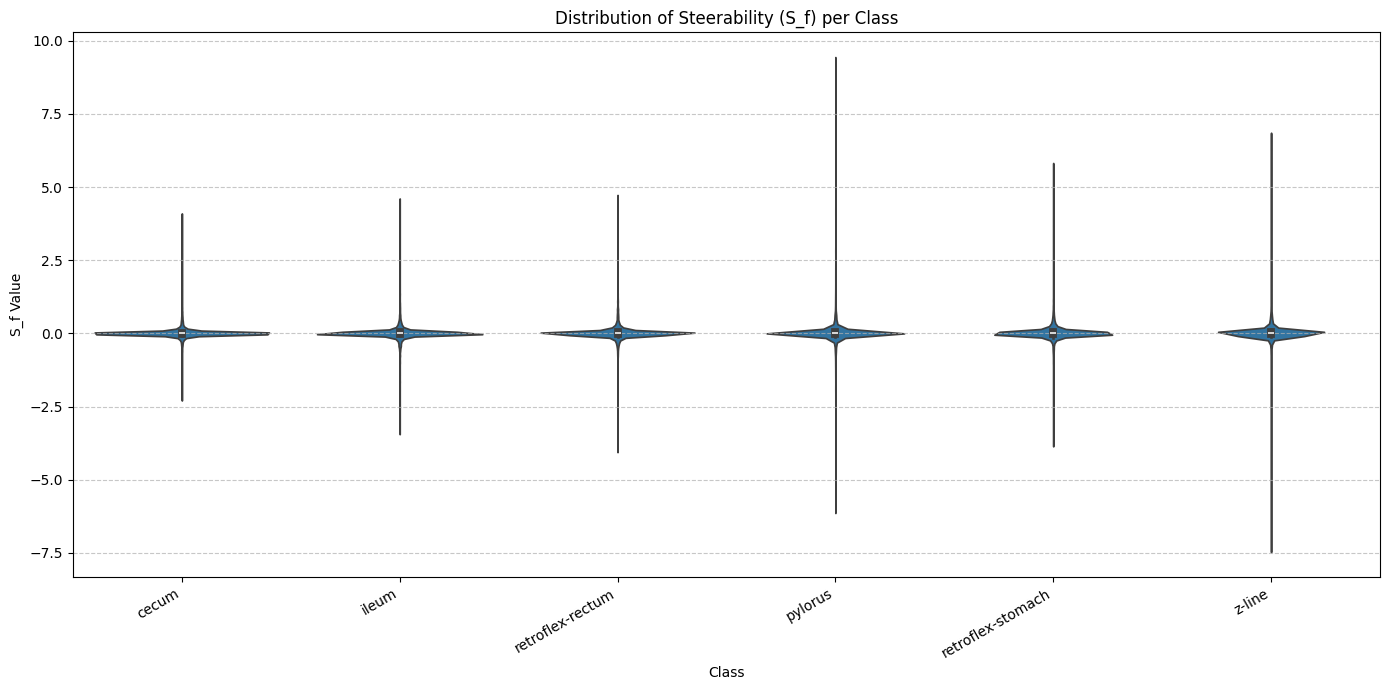

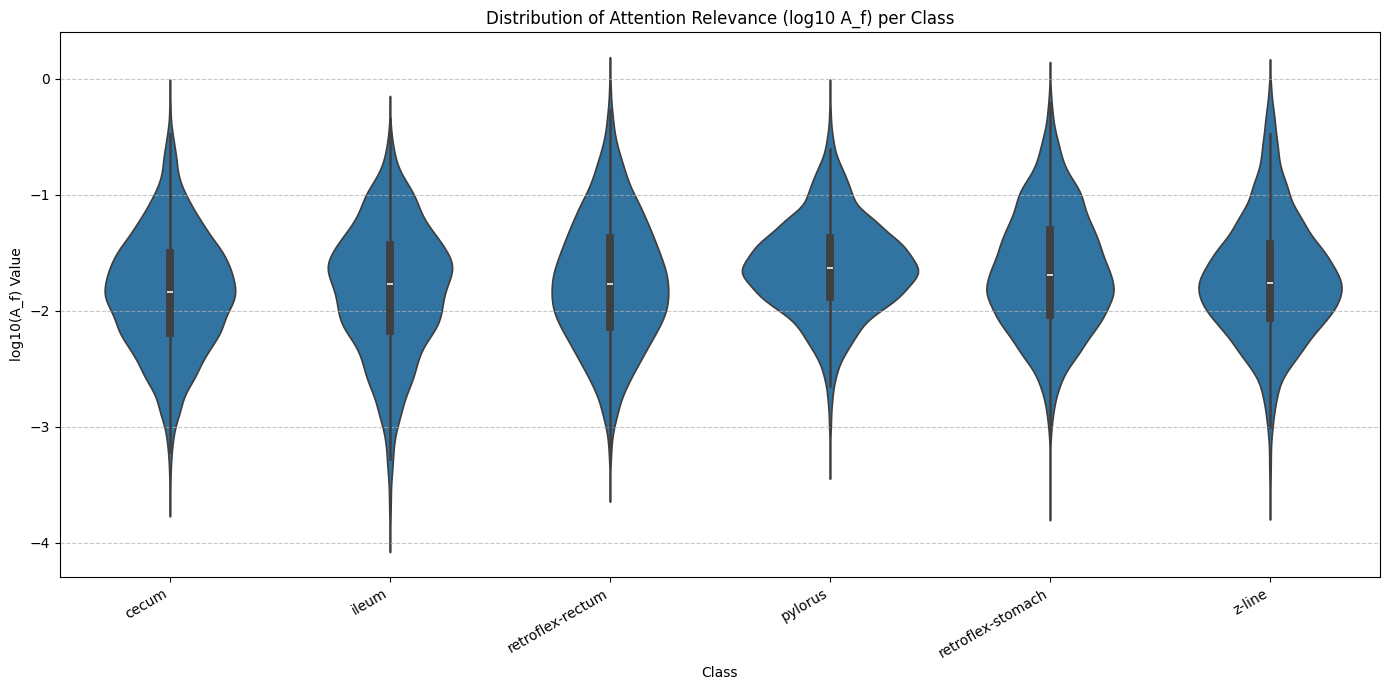

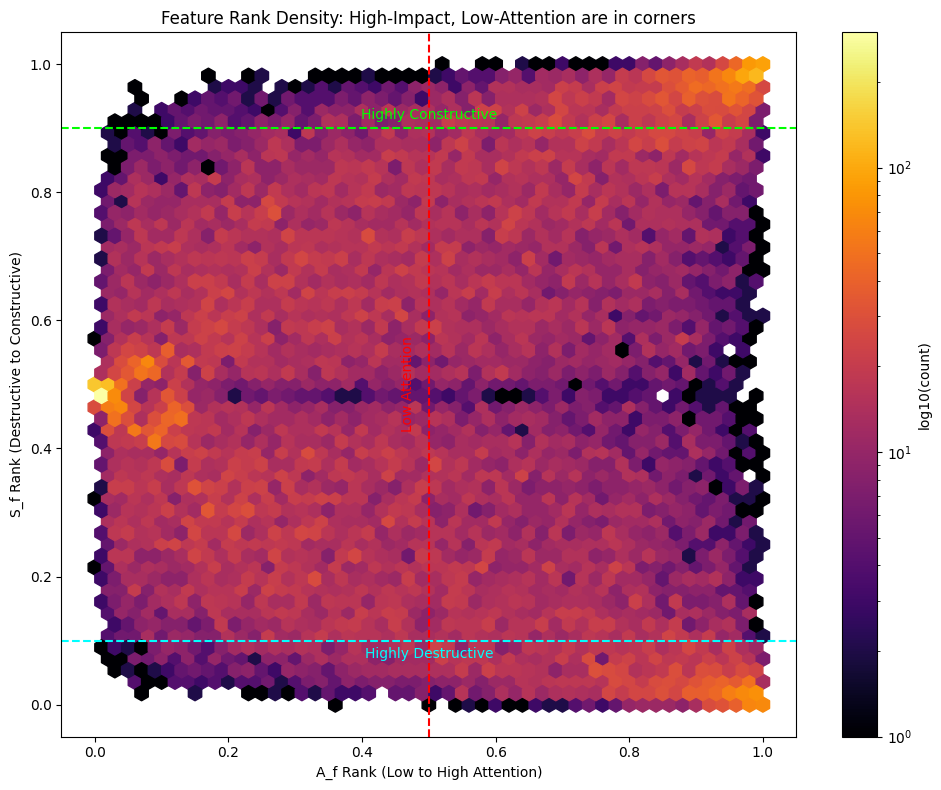

In [8]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import logging

# --- SETUP (Same as before) ---
logging.getLogger('matplotlib').setLevel(logging.WARNING)
S_POS_THRESH, S_NEG_THRESH, A_LOW_THRESH = 0.90, 0.10, 0.50
out_dir = Path("./results/analysis")
out_dir.mkdir(exist_ok=True, parents=True)
CLS_NAMES = ["cecum", "ileum", "retroflex-rectum", "pylorus", "retroflex-stomach", "z-line"]

# --- 0. Load Data (Same as before) ---
try:
    from transmm_sfaf import load_or_build_sf_af_dictionary, load_models
    print("Loading models...")
    sae, vit = load_models()
    sfaf_path = "./results/train/sfaf_dir_l6.pt"
    d = load_or_build_sf_af_dictionary(vit, sae, dict_path=sfaf_path, rebuild=False)
except ImportError:
    print("Could not import from 'transmm_sfaf'. Aborting."); exit()

S, A, N = d["S_f"], d["A_f"] + 1e-9, d["feature_counts"]
live_mask = N.sum(1) > 0
S, A, N = S[live_mask], A[live_mask], N[live_mask]
F_live, C = S.shape

# --- NEW: 1. Distribution Analysis (The "Why") ---
print("\n[1] Analyzing S_f and A_f distributions per class...")
df_list = []
for c in range(C):
    class_live_mask = N[:, c] > 0
    df_list.append(pd.DataFrame({
        'S_f': S[class_live_mask, c].numpy(),
        'A_f': A[class_live_mask, c].log10().numpy(), # Use log for better visualization
        'Class': CLS_NAMES[c]
    }))
dist_df = pd.concat(df_list)

# S_f Distribution
plt.figure(figsize=(14, 7))
sns.violinplot(data=dist_df, x='Class', y='S_f', cut=0)
plt.title('Distribution of Steerability (S_f) per Class')
plt.ylabel('S_f Value')
plt.xlabel('Class')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(out_dir / "dist_sf_per_class.png", dpi=200)
print("-> Saved S_f distribution plot. This shows why a fixed percentile is problematic.")

# A_f Distribution (Log Scale)
plt.figure(figsize=(14, 7))
sns.violinplot(data=dist_df, x='Class', y='A_f')
plt.title('Distribution of Attention Relevance (log10 A_f) per Class')
plt.ylabel('log10(A_f) Value')
plt.xlabel('Class')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(out_dir / "dist_af_per_class.png", dpi=200)
print("-> Saved A_f distribution plot.")

# --- 2. Rank-based Analysis (Same as before, but with clearer visuals) ---
print("\n[2] Performing rank-based analysis...")
S_rank = S.argsort(dim=0).argsort(dim=0).float() / (F_live - 1)
A_rank = A.argsort(dim=0).argsort(dim=0).float() / (F_live - 1)
constructive_unseen_mask = (S_rank > S_POS_THRESH) & (A_rank < A_LOW_THRESH)
destructive_unseen_mask = (S_rank < S_NEG_THRESH) & (A_rank < A_LOW_THRESH)

# --- 3. Summary Table (Enhanced with average values) ---
print(f"\n[3] Summary of 'Unseen' Features per Class")
summary_data = []
for c in range(C):
    live_in_class = (N[:, c] > 0).sum().item()
    const_mask = constructive_unseen_mask[:, c]
    destr_mask = destructive_unseen_mask[:, c]
    summary_data.append({
        "Class": CLS_NAMES[c],
        "Live Feats": live_in_class,
        "Constr. Unseen": const_mask.sum().item(),
        "Avg S_f (+)": S[const_mask, c].mean().item() if const_mask.any() else 0,
        "Destr. Unseen": destr_mask.sum().item(),
        "Avg S_f (-)": S[destr_mask, c].mean().item() if destr_mask.any() else 0,
        "Avg A_f (Unseen)": A[const_mask | destr_mask, c].mean().item() if (const_mask | destr_mask).any() else 0,
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format="%.4f"))

# --- 4. 2D Density Plot (Better than scatter for many points) ---
print("\n[4] Generating 2D density plot of feature ranks...")
fig_rank, ax_rank = plt.subplots(figsize=(10, 8))
s_rank_flat = S_rank.flatten().numpy()
a_rank_flat = A_rank.flatten().numpy()

# Use a 2D histogram / hexbin plot for density
hb = ax_rank.hexbin(a_rank_flat, s_rank_flat, gridsize=50, cmap='inferno', bins='log')
cb = fig_rank.colorbar(hb, ax=ax_rank, label='log10(count)')

ax_rank.set_xlabel(f"A_f Rank (Low to High Attention)")
ax_rank.set_ylabel(f"S_f Rank (Destructive to Constructive)")
ax_rank.set_title("Feature Rank Density: High-Impact, Low-Attention are in corners")
ax_rank.axhline(S_POS_THRESH, color='lime', linestyle='--', lw=1.5)
ax_rank.axhline(S_NEG_THRESH, color='cyan', linestyle='--', lw=1.5)
ax_rank.axvline(A_LOW_THRESH, color='red', linestyle='--', lw=1.5)
ax_rank.text(A_LOW_THRESH-0.02, 0.5, f'Low Attention', rotation=90, va='center', ha='right', color='red')
ax_rank.text(0.5, S_POS_THRESH+0.01, f'Highly Constructive', ha='center', va='bottom', color='lime')
ax_rank.text(0.5, S_NEG_THRESH-0.01, f'Highly Destructive', ha='center', va='top', color='cyan')
plt.tight_layout()
plt.savefig(out_dir / "rank_density_plot.png", dpi=200)

# --- 5 & 6. Reporting and Saving (Same as before) ---
# (Your code for reporting top features and saving is good)

In [2]:
import pickle
from pathlib import Path
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import Tuple

# --- 1. SETUP ---
logging.getLogger('matplotlib').setLevel(logging.WARNING)
out_dir = Path("./results/dist_analysis")
out_dir.mkdir(exist_ok=True, parents=True)
CLS_NAMES = ["cecum", "ileum", "retroflex-rectum", "pylorus", "retroflex-stomach", "z-line"]
# Define a consistent color palette
PALETTE = sns.color_palette("viridis", len(CLS_NAMES))


# --- 2. LOAD NEW DISTRIBUTIONAL DICTIONARY ---
# NOTE: This script assumes you have run the new `build_distributional_sa_dictionary`
dict_path = "./sae_dictionaries/dist_sf_af_dict_l6.pkl" # Note the .pkl extension
print(f"Loading distributional dictionary from: {dict_path}")
try:
    with open(dict_path, 'rb') as f:
        d = pickle.load(f)
except FileNotFoundError:
    print(f"Error: Dictionary not found at {dict_path}.")
    print("Please run `build_distributional_sa_dictionary` first.")
    exit()

n_features = d['n_features']
n_classes = d['n_classes']
print(f"Dictionary for layer {d['layer_idx']} loaded. Samples: {d['n_samples']}, Features: {n_features}")


# --- 3. PRE-COMPUTE FEATURE-LEVEL STATISTICS ---
# This is a crucial step. We process the raw distributions into useful stats
# that we'll use for the rest of the analysis.
print("\n[1] Pre-computing feature statistics (mean, var, quantiles)...")
stats_list = []
for f in tqdm(range(n_features), desc="Processing features"):
    for c in range(n_classes):
        s_dist = d['S_f_distributions'][f][c]
        a_dist = d['A_f_distributions'][f][c]
        count = len(s_dist)

        if count > 1: # Need at least 2 points for variance
            stats_list.append({
                'feature_id': f,
                'class_id': c,
                'class_name': CLS_NAMES[c],
                'count': count,
                's_mean': np.mean(s_dist),
                's_std': np.std(s_dist),
                's_median': np.median(s_dist),
                'a_mean': np.mean(a_dist),
                'a_std': np.std(a_dist),
                # Signal-to-noise ratio for S_f
                's_snr': np.abs(np.mean(s_dist)) / (np.std(s_dist) + 1e-9)
            })
stats_df = pd.DataFrame(stats_list)
print("Statistics pre-computation complete.")


# --- 4. GLOBAL LANDSCAPE ANALYSIS ---
# Plotting every single event to see the true structure.
print("\n[2] Generating global landscape plot of all S_f/A_f events...")
all_s_values = []
all_a_values = []
for f in range(n_features):
    for c in range(n_classes):
        all_s_values.extend(d['S_f_distributions'][f][c])
        all_a_values.extend(d['A_f_distributions'][f][c])

plt.figure(figsize=(12, 10))
hb = plt.hexbin(
    all_a_values, all_s_values, gridsize=100, cmap='inferno', bins='log',
    extent=(np.quantile(all_a_values, 0.01), np.quantile(all_a_values, 0.99),
            np.quantile(all_s_values, 0.01), np.quantile(all_s_values, 0.99))
)
cb = plt.colorbar(hb, label='log10(Event Count)')
plt.xlabel("Attention Relevance (A_f)")
plt.ylabel("Steerability (S_f)")
plt.title("Global Landscape of All S_f vs. A_f Events (Un-averaged)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='white', linestyle='--', alpha=0.7)
plt.savefig(out_dir / "global_event_density.png", dpi=200, bbox_inches='tight')
plt.close()
print("-> Saved global event density plot.")


# --- 5. ANALYSIS OF FEATURE TYPES (USING COMPUTED STATS) ---
print("\n[3] Analyzing feature types based on Mean vs. Standard Deviation...")

# Plot Mean S_f vs. Std Dev S_f to identify feature archetypes
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=stats_df, x='s_std', y='s_mean', hue='s_snr',
    size='count', sizes=(10, 200), palette='mako',
    alpha=0.7
)
plt.xlabel("S_f Standard Deviation (Context-Dependency)")
plt.ylabel("Mean S_f (Average Impact)")
plt.title("Feature Archetypes: Mean Impact vs. Context-Dependency")
plt.axhline(0, color='gray', linestyle='--')
plt.text(stats_df['s_std'].max()*0.6, stats_df['s_mean'].max()*0.8, "Reliable Heroes\n(High Mean, Low Std)", ha='center', color='blue')
plt.text(stats_df['s_std'].max()*0.6, stats_df['s_mean'].min()*0.8, "Reliable Villains\n(Low Mean, Low Std)", ha='center', color='red')
plt.text(stats_df['s_std'].max()*0.8, 0, "Contextual Specialists\n(Low Mean, High Std)", ha='center', rotation=90, color='green')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(out_dir / "feature_archetypes_mean_vs_std.png", dpi=200, bbox_inches='tight')
plt.close()
print("-> Saved feature archetypes plot.")

# Identify and report top features of each type
print("\n--- Top 5 Most Context-Dependent Features (High Std, Low |Mean|) ---")
contextual_features = stats_df.copy()
contextual_features['abs_mean'] = contextual_features['s_mean'].abs()
contextual_features = contextual_features.sort_values(by=['s_std', 'abs_mean'], ascending=[False, True])
print(contextual_features[['feature_id', 'class_name', 's_mean', 's_std', 'count']].head(5).to_string(index=False))

print("\n--- Top 5 Most Reliable Constructive Features (High SNR) ---")
reliable_heroes = stats_df[stats_df['s_mean'] > 0].sort_values(by='s_snr', ascending=False)
print(reliable_heroes[['feature_id', 'class_name', 's_mean', 's_std', 's_snr', 'count']].head(5).to_string(index=False))


# --- 6. DEEP DIVE: VISUALIZING A SINGLE CONTEXTUAL FEATURE ---
# This plot directly tests the "averaging out" hypothesis.
print("\n[4] Deep dive on a single 'contextual specialist' feature...")

# Select the most contextual feature we found
try:
    target_feature_id = contextual_features.iloc[0]['feature_id']
    target_class_id = contextual_features.iloc[0]['class_id']
    target_class_name = CLS_NAMES[target_class_id]

    s_dist_single = d['S_f_distributions'][target_feature_id][target_class_id]

    plt.figure(figsize=(10, 6))
    sns.histplot(s_dist_single, bins=50, kde=True)
    mean_val = np.mean(s_dist_single)
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
    plt.title(f"S_f Distribution for Feature {target_feature_id} on Class '{target_class_name}'")
    plt.xlabel("S_f Value (per image)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(out_dir / f"deep_dive_feature_{target_feature_id}_{target_class_name}.png", dpi=200, bbox_inches='tight')
    plt.close()
    print(f"-> Saved deep dive plot for feature {target_feature_id}. Check for bimodality!")
except IndexError:
    print("-> Could not perform deep dive, no contextual features found.")


print(f"\nAnalysis complete. All new plots saved to: {out_dir}")

Loading distributional dictionary from: ./sae_dictionaries/dist_sf_af_dict_l6.pkl


Dictionary for layer 6 loaded. Samples: 16420, Features: 6144

[1] Pre-computing feature statistics (mean, var, quantiles)...


Processing features:  77%|███████▋  | 4757/6144 [00:05<00:01, 922.98it/s]


KeyboardInterrupt: 

In [1]:
import pickle
from pathlib import Path
import logging
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy.stats import pearsonr
from tqdm import tqdm
from typing import Tuple
import torch.nn.functional as F

from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.sae import SparseAutoencoder
from transmm_sfaf import load_models, get_processor_for_precached_224_images, IDX2CLS
import glob
import torchvision


def calculate_per_image_sa(
    model: HookedSAEViT,
    sae: SparseAutoencoder,
    image: torch.Tensor,
    label: int,
    layer_idx: int = 6
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Calculates S_f and A_f for a SINGLE image instance.
    This is the core of the dynamic, on-the-go approach.
    """
    device = next(model.parameters()).device
    n_classes = model.head.out_features
    image = image.unsqueeze(0).to(device) # Add batch dimension

    # --- Hook setup ---
    resid_storage, attn_storage = {}, {}
    def save_resid_hook(tensor, hook):
        tensor.requires_grad_(True)
        resid_storage['resid'] = tensor
    def save_attn_hook(tensor, hook):
        tensor.requires_grad_(True)
        attn_storage['attn'] = tensor

    resid_hook_name = f"blocks.{layer_idx}.hook_resid_post"
    attn_hook_name = f"blocks.{layer_idx}.attn.hook_pattern"
    fwd_hooks = [(resid_hook_name, save_resid_hook), (attn_hook_name, save_attn_hook)]

    # --- Forward & Backward Pass ---
    model.zero_grad()
    with model.hooks(fwd_hooks=fwd_hooks):
        logits = model(image)
    resid, attn = resid_storage['resid'], attn_storage['attn']

    with torch.no_grad():
        _, codes = sae.encode(resid) # Shape (1, T, F)

    one_hot = F.one_hot(torch.tensor([label], device=device), num_classes=n_classes).float()
    target = (logits * one_hot).sum()
    resid_grad, attn_grad = torch.autograd.grad(outputs=target, inputs=[resid, attn])

    # --- Calculate S_f and A_f (for this one image) ---
    with torch.no_grad():
        grad_weighted_attn = (attn * attn_grad.abs()).sum(dim=1) # (1, T, T)
        cls_to_patch_attn = grad_weighted_attn[0, 0, 1:] # (T-1)

        active_codes_mask = codes[0, 1:, :] > 0.0 # (T-1, F)
        A_f_image = torch.einsum('t,tf->f', cls_to_patch_attn, active_codes_mask.float())

        dir_deriv = torch.einsum('d,fd->f', resid_grad[0, 0, :], sae.W_dec)
        codes_no_cls = codes[0, 1:, :] # (T-1, F)
        S_f_image = (codes_no_cls * dir_deriv.unsqueeze(0)).sum(0) # (F)
    
    return S_f_image.cpu(), A_f_image.cpu(), codes[0, 1:, :].cpu()


def run_attribution_alignment_analysis(
    n_samples: int = 100,
    layer_idx: int = 6,
    attribution_dir: str = "./results/train/attributions",
    save_path: str = "./results/alignment_analysis.pkl"
):
    """
    Main analysis function. Loops through data, calculates per-image S_f,
    loads attribution maps, and computes the correlation.
    """
    logging.info("Starting Attribution Alignment Analysis...")
    sae, model = load_models()
    n_features = sae.cfg.d_sae
    
    # --- Load Dataset ---
    label_map = {2: 3, 3: 2}
    def custom_target_transform(target): return label_map.get(target, target)
    train_path = "./hyper-kvasir_imagefolder/train"
    # Important: Use a dataset that returns image paths for loading attributions
    # We will wrap the ImageFolder dataset to also return the path.
    class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
        def __getitem__(self, index):
            path, target = self.samples[index]
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            return sample, target, path

    train_dataset = ImageFolderWithPaths(
        train_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform
    )
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    
    # --- Data storage ---
    # Store results for each feature
    results = []

    samples_processed = 0
    pbar = tqdm(dataloader, total=n_samples, desc="Analyzing image")
    for image, label, path in pbar:
        if samples_processed >= n_samples:
            break
        
        image = image.squeeze(0)
        label = label.item()
        
        # --- 1. Get Per-Image S_f and Activations ---
        print("per image s_f and activations")
        S_f_image, A_f_image, feature_activations = calculate_per_image_sa(model, sae, image, label, layer_idx)
        
        # --- 2. Load Attribution Map ---
        try:
            # Extract UUID and aug parts from image filename
            img_filename = Path(path[0]).stem
            # Split at the last underscore to separate aug part
            parts = img_filename.rsplit('_', 1)
            if len(parts) != 2:
                logging.warning(f"Could not parse filename pattern for {img_filename}, skipping.")
                continue
            
            uuid_part = parts[0]  # train_2cfd377a-a24f-40f2-8cda-c4a025de30e9
            aug_part = parts[1]   # aug1
            
            # Create pattern: train_uuid_*_aug_attribution.npy
            attr_pattern = str(Path(attribution_dir) / f"train_{uuid_part}_*_{aug_part}_attribution.npy")
            attr_files = glob.glob(attr_pattern)
            
            if not attr_files:
                logging.warning(f"No attribution found matching pattern {attr_pattern}, skipping.")
                continue
            elif len(attr_files) > 1:
                logging.warning(f"Multiple attributions found for {img_filename}: {attr_files}. Using first one.")
            
            attr_path = attr_files[0]
            attr_map_flat = np.load(attr_path).flatten()
            attr_map_tensor = torch.from_numpy(attr_map_flat)
            print("attribution map loaded")
        except Exception as e:
            logging.warning(f"Error loading attribution for {img_filename}: {e}, skipping.")
            continue

        # --- 3. Correlate for each feature ---
        #TODO: trim it down to active features only
        active_feature_indices = feature_activations.abs().sum(dim=0).nonzero(as_tuple=True)[0]
        
        print("start per feature correlation")
        for feat_idx in active_feature_indices:
            patch_activation_vec = feature_activations[:, feat_idx]
            
            # Ensure there is variance to compute correlation
            if patch_activation_vec.std() > 1e-6 and attr_map_tensor.std() > 1e-6:
                # Use scipy's pearsonr for robustness
                corr, p_value = pearsonr(attr_map_tensor.numpy(), patch_activation_vec.numpy())
                
                if not np.isnan(corr):
                    results.append({
                        'feature_id': feat_idx.item(),
                        'image_path': path[0],
                        's_f_image': S_f_image[feat_idx].item(),
                        'a_f_image': A_f_image[feat_idx].item(),
                        'pfac_corr': corr,
                        'p_value': p_value
                    })

        samples_processed += 1
        pbar.set_postfix({"Processed": samples_processed})
        gc.collect()

    # --- 4. Save Results ---
    results_df = pd.DataFrame(results)
    Path(save_path).parent.mkdir(exist_ok=True, parents=True)
    results_df.to_pickle(save_path)
    logging.info(f"Analysis complete. Results saved to {save_path}")
    
    return results_df


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    # Run the main analysis
    df = run_attribution_alignment_analysis(n_samples=5) # Use more samples for better stats
    
    # --- Example Post-Analysis ---
    if not df.empty:
        logging.info("\n--- Post-Analysis of Alignment Results ---")
        
        # Average PFAC per feature
        avg_pfac = df.groupby('feature_id')['pfac_corr'].mean()
        
        plt.figure(figsize=(10, 6))
        sns.histplot(avg_pfac, bins=50, kde=True)
        plt.title("Distribution of Average Alignment (PFAC) Across All Features")
        plt.xlabel("Mean Pearson Correlation (Attribution vs. Feature Activation)")
        plt.ylabel("Number of Features")
        plt.axvline(0, color='red', linestyle='--')
        plt.savefig("./results/analysis/pfac_distribution.png", dpi=200)
        logging.info("Saved PFAC distribution plot.")

        # Find the most and least aligned features
        logging.info("\n--- Top 5 Most Aligned Features (High PFAC) ---")
        print(avg_pfac.sort_values(ascending=False).head(5))
        
        logging.info("\n--- Top 5 Most Mis-aligned (Stealth) Features (Low/Negative PFAC) ---")
        print(avg_pfac.sort_values(ascending=True).head(5))

2025-07-04 13:10:28 INFO:root: Starting Attribution Alignment Analysis...
2025-07-04 13:10:28 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-04 13:10:28 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-07-04 13:10:28 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443
2025-07-04 13:10:28 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-04 13:10:29 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-04 13:10:29 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-04 13:10:29 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-04 13:10:30 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-04 13:10:30 INFO:root: Filling in 2 missing keys with default initialization
2025-07-04 13:10:30 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-04 13:10:30 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


Analyzing image:   0%|          | 0/5 [00:00<?, ?it/s]

per image s_f and activations


Analyzing image:   0%|          | 0/5 [00:00<?, ?it/s]

attribution map loaded
start per feature correlation


ValueError: `x` and `y` must have the same length along `axis`.

2025-07-04 13:12:18 INFO:root: Starting Attribution Alignment Analysis...
2025-07-04 13:12:18 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-04 13:12:18 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-07-04 13:12:18 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443
2025-07-04 13:12:19 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-04 13:12:19 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-04 13:12:19 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-04 13:12:20 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-04 13:12:20 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-04 13:12:20 INFO:root: Filling in 2 missing keys with default initialization
2025-07-04 13:12:20 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-04 13:12:20 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


Analyzing images: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s, Processed=100, Results=66197]
2025-07-04 13:12:44 INFO:root: Analysis complete. 66197 correlation pairs found. Results saved to ./results/alignment_analysis.pkl
2025-07-04 13:12:44 INFO:root: 
--- Post-Analysis of Alignment Results ---
2025-07-04 13:12:44 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-04 13:12:44 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-04 13:12:44 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-07-04 13:12:44 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='norm

feature_id
455     0.759147
404     0.597084
2111    0.538281
4040    0.529425
3839    0.529425
5245    0.529425
5484    0.518728
3567    0.494058
4104    0.473237
5040    0.469545
3505    0.445120
5573    0.437638
3491    0.395113
4614    0.373268
1823    0.354640
1644    0.352468
745     0.330880
4496    0.324825
4491    0.320006
3478    0.313013
4847    0.311632
3154    0.296642
5147    0.296556
1996    0.293317
5619    0.290778
1139    0.289204
5576    0.287555
1519    0.284072
380     0.283253
2734    0.281046
362     0.278315
489     0.276544
315     0.274599
4522    0.271108
2810    0.270344
4566    0.270344
3636    0.269454
225     0.269078
972     0.269011
4116    0.268811
3752    0.266766
3795    0.264030
1939    0.262788
3637    0.262788
254     0.262788
2090    0.259073
2387    0.258470
2016    0.258135
3257    0.254615
2034    0.252816
Name: pfac_corr, dtype: float32
feature_id
5352   -0.144008
5909   -0.114536
4432   -0.101657
2585   -0.098373
1041   -0.095872
1152   -0.0

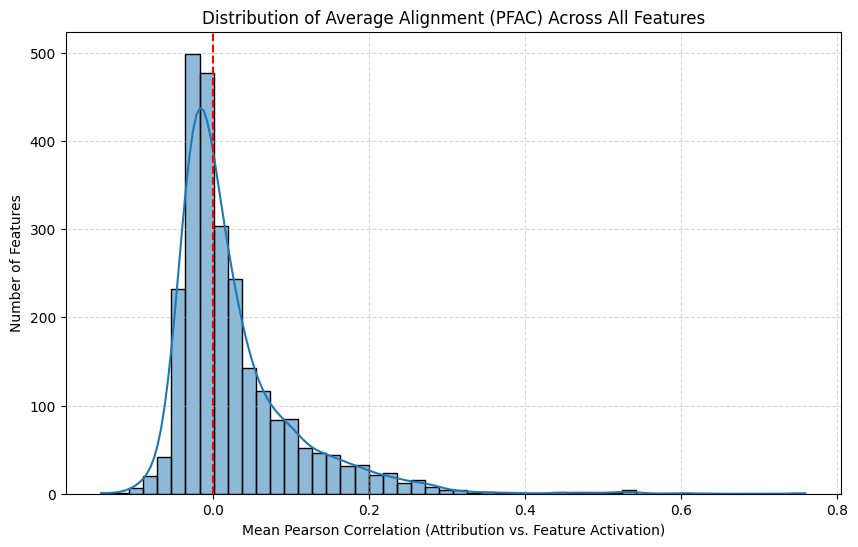

In [ ]:
import glob
import logging
import pickle
from pathlib import Path
from typing import Tuple
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision
from scipy.stats import pearsonr
from tqdm import tqdm

from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.sae import SparseAutoencoder
from transmm_sfaf import load_models, get_processor_for_precached_224_images, IDX2CLS

# calculate_per_image_sa function remains the same, no changes needed there.
# It is included here for completeness.
def calculate_per_image_sa(
    model: HookedSAEViT,
    sae: SparseAutoencoder,
    image: torch.Tensor,
    label: int,
    layer_idx: int = 9
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Calculates S_f and A_f for a SINGLE image instance.
    This is the core of the dynamic, on-the-go approach.
    """
    device = next(model.parameters()).device
    n_classes = model.head.out_features
    image = image.unsqueeze(0).to(device)

    resid_storage, attn_storage = {}, {}
    def save_resid_hook(tensor, hook):
        tensor.requires_grad_(True)
        resid_storage['resid'] = tensor
    def save_attn_hook(tensor, hook):
        tensor.requires_grad_(True)
        attn_storage['attn'] = tensor

    resid_hook_name = f"blocks.{layer_idx}.hook_resid_post"
    attn_hook_name = f"blocks.{layer_idx}.attn.hook_pattern"
    fwd_hooks = [(resid_hook_name, save_resid_hook), (attn_hook_name, save_attn_hook)]

    model.zero_grad()
    with model.hooks(fwd_hooks=fwd_hooks):
        logits = model(image)
    resid, attn = resid_storage['resid'], attn_storage['attn']

    with torch.no_grad():
        _, codes = sae.encode(resid)

    one_hot = F.one_hot(torch.tensor([label], device=device), num_classes=n_classes).float()
    target = (logits * one_hot).sum()
    resid_grad, attn_grad = torch.autograd.grad(outputs=target, inputs=[resid, attn])

    with torch.no_grad():
        grad_weighted_attn = (attn * attn_grad.abs()).sum(dim=1)
        cls_to_patch_attn = grad_weighted_attn[0, 0, 1:]
        active_codes_mask = codes[0, 1:, :] > 0.0
        A_f_image = torch.einsum('t,tf->f', cls_to_patch_attn, active_codes_mask.float())
        dir_deriv = torch.einsum('d,fd->f', resid_grad[0, 0, :], sae.W_dec)
        codes_no_cls = codes[0, 1:, :]
        S_f_image = (codes_no_cls * dir_deriv.unsqueeze(0)).sum(0)
    
    return S_f_image.cpu(), A_f_image.cpu(), codes[0, 1:, :].cpu()


def run_attribution_alignment_analysis(
    n_samples: int = 100,
    layer_idx: int = 9,
    attribution_dir: str = "./results/train/attributions",
    save_path: str = "./results/alignment_analysis.pkl",
    patch_size: int = 16
):
    """
    Main analysis function. Loops through data, calculates per-image S_f,
    loads attribution maps, correctly downsamples them, and computes the
    correlation using a glob-based file search.
    """
    logging.info("Starting Attribution Alignment Analysis...")
    sae, model = load_models()
    
    # --- Load Dataset with paths ---
    class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
        def __getitem__(self, index):
            path, target = self.samples[index]
            sample = self.loader(path)
            if self.transform is not None: sample = self.transform(sample)
            # Assuming you have a target_transform defined elsewhere
            # if self.target_transform is not None: target = self.target_transform(target)
            return sample, target, path

    train_dataset = ImageFolderWithPaths(
        "./hyper-kvasir_imagefolder/train", 
        get_processor_for_precached_224_images()
    )
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    
    results = []
    samples_processed = 0
    pbar = tqdm(dataloader, total=min(n_samples, len(dataloader)), desc="Analyzing images")

    for image, label, path in pbar:
        if samples_processed >= n_samples:
            break
        
        image = image.squeeze(0)
        label = label.item()
        
        # --- 1. Get Per-Image S_f and Activations ---
        S_f_image, A_f_image, feature_activations = calculate_per_image_sa(model, sae, image, label, layer_idx)
        
        # --- 2. Load and DOWNSAMPLE Attribution Map ---
        attr_map_patch_level_flat = None
        try:
            # Your glob-based file search logic
            img_filename_stem = Path(path[0]).stem
            # This assumes format like: train_ffe66e45-bd2c-4b43-b449-6f18bd8e9e32_pylorus_aug4
            # We need to extract the core part to build the glob pattern.
            # A robust way is to find the first underscore after 'train_'
            # and the last underscore before '_aug'.
            base_name_parts = img_filename_stem.split('_')
            uuid_part = base_name_parts[0]
            aug_part = base_name_parts[1]
            
            attr_pattern = str(Path(attribution_dir) / f"train_{uuid_part}_*_{aug_part}_attribution.npy")
            attr_files = glob.glob(attr_pattern)
            
            if not attr_files:
                logging.warning(f"Attribution not found for pattern {attr_pattern}, skipping.")
                continue
            
            attr_path = attr_files[0]
            if len(attr_files) > 1:
                logging.warning(f"Multiple attributions for {img_filename_stem}, using first: {attr_path}")
            
            # Load high-res map
            attr_map_high_res = np.load(attr_path) # Expected shape (H, W), e.g., (224, 224)

            # *** THE FIX: Downsample to patch resolution ***
            attr_tensor_high_res = torch.from_numpy(attr_map_high_res).unsqueeze(0).unsqueeze(0).float()
            attr_tensor_patch_level_2d = F.avg_pool2d(
                attr_tensor_high_res,
                kernel_size=patch_size,
                stride=patch_size
            )
            attr_map_patch_level_flat = attr_tensor_patch_level_2d.flatten()
            
        except Exception as e:
            logging.error(f"Error processing {path[0]}: {e}")
            continue

        if attr_map_patch_level_flat is None:
            continue

        # --- 3. Correlate for each feature ---
        active_feature_indices = feature_activations.abs().sum(dim=0).nonzero(as_tuple=True)[0]
        
        for feat_idx in active_feature_indices:
            patch_activation_vec = feature_activations[:, feat_idx]
            
            # Now both vectors are guaranteed to have the same length (e.g., 196)
            if patch_activation_vec.std() > 1e-6 and attr_map_patch_level_flat.std() > 1e-6:
                corr, p_value = pearsonr(attr_map_patch_level_flat.numpy(), patch_activation_vec.numpy())
                
                if not np.isnan(corr):
                    results.append({
                        'feature_id': feat_idx.item(),
                        'image_path': path[0],
                        's_f_image': S_f_image[feat_idx].item(),
                        'a_f_image': A_f_image[feat_idx].item(),
                        'pfac_corr': corr,
                        'p_value': p_value
                    })

        samples_processed += 1
        pbar.set_postfix({"Processed": samples_processed, "Results": len(results)})
        gc.collect()

    # --- 4. Save Results ---
    if not results:
        logging.warning("No results were generated. Check attribution paths and file patterns.")
        return pd.DataFrame()

    results_df = pd.DataFrame(results)
    Path(save_path).parent.mkdir(exist_ok=True, parents=True)
    results_df.to_pickle(save_path)
    logging.info(f"Analysis complete. {len(results_df)} correlation pairs found. Results saved to {save_path}")
    
    return results_df


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    # Run the main analysis
    df = run_attribution_alignment_analysis(n_samples=100, layer_idx=10)
    
    # --- Example Post-Analysis ---
    if not df.empty:
        logging.info("\n--- Post-Analysis of Alignment Results ---")
        
        # Average PFAC per feature
        avg_pfac = df.groupby('feature_id')['pfac_corr'].mean()
        
        plt.figure(figsize=(10, 6))
        sns.histplot(avg_pfac, bins=50, kde=True)
        plt.title("Distribution of Average Alignment (PFAC) Across All Features")
        plt.xlabel("Mean Pearson Correlation (Attribution vs. Feature Activation)")
        plt.ylabel("Number of Features")
        plt.axvline(0, color='red', linestyle='--')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.savefig("./results/analysis/pfac_distribution.png", dpi=200)
        logging.info("Saved PFAC distribution plot.")

        # Find the most and least aligned features
        logging.info("\n--- Top 5 Most Aligned Features (High PFAC) ---")
        print(avg_pfac.sort_values(ascending=False).head(50))
        
        logging.info("\n--- Top 5 Most Mis-aligned (Stealth) Features (Low/Negative PFAC) ---")
        print(avg_pfac.sort_values(ascending=True).head(50))

In [2]:
# --- Numerical Distribution Analysis ---
print("\n" + "="*25 + " Numerical PFAC Distribution " + "="*25)

if 'avg_pfac' in locals() and not avg_pfac.empty:
    # Use pandas describe() for a quick statistical summary
    print("\n[1] Statistical Summary of Average PFAC Scores:")
    # Using to_string() for better formatting in notebooks
    print(avg_pfac.describe().to_string())

    # --- Quantile Analysis ---
    # This shows the PFAC value at different percentile thresholds
    print("\n[2] Quantile Analysis of Average PFAC Scores:")
    quantiles_to_check = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
    pfac_quantiles = avg_pfac.quantile(quantiles_to_check)
    
    # Format for readability
    quantile_df = pd.DataFrame(pfac_quantiles)
    quantile_df.index.name = 'Percentile'
    quantile_df.columns = ['PFAC Value']
    print(quantile_df.to_string(float_format="%.6f"))

    # --- Analysis of the "Tails" ---
    # How many features have a meaningful correlation?
    print("\n[3] Analysis of Meaningful Correlation Tails:")
    
    # Positive Tail (Aligned Features)
    aligned_threshold = 0.05  # Features with a correlation > 0.05
    num_aligned = (avg_pfac > aligned_threshold).sum()
    percent_aligned = 100 * num_aligned / len(avg_pfac)
    print(f"- Features with PFAC > {aligned_threshold:.2f} (Aligned): \t{num_aligned} ({percent_aligned:.2f}%)")

    aligned_threshold_strong = 0.10  # Features with a correlation > 0.10
    num_aligned_strong = (avg_pfac > aligned_threshold_strong).sum()
    percent_aligned_strong = 100 * num_aligned_strong / len(avg_pfac)
    print(f"- Features with PFAC > {aligned_threshold_strong:.2f} (Strongly Aligned): {num_aligned_strong} ({percent_aligned_strong:.2f}%)")
    
    # Negative Tail (Potentially "Stealth" Features)
    stealth_threshold = -0.02 # A more realistic threshold for the negative side
    num_stealth = (avg_pfac < stealth_threshold).sum()
    percent_stealth = 100 * num_stealth / len(avg_pfac)
    print(f"- Features with PFAC < {stealth_threshold:.2f} (Misaligned): \t{num_stealth} ({percent_stealth:.2f}%)")
    
else:
    print("\nCould not perform numerical analysis: 'avg_pfac' Series not found or is empty.")

print("\n" + "="*75)


========================= Numerical PFAC Distribution =========================

[1] Statistical Summary of Average PFAC Scores:
count    2566.000000
mean        0.025855
std         0.079021
min        -0.144008
25%        -0.023167
50%         0.000617
75%         0.048225
max         0.759147

[2] Quantile Analysis of Average PFAC Scores:
            PFAC Value
Percentile            
0.001        -0.099802
0.010        -0.073227
0.050        -0.046991
0.100        -0.037977
0.250        -0.023167
0.500         0.000617
0.750         0.048225
0.900         0.127842
0.950         0.187102
0.990         0.288133
0.999         0.533277

[3] Analysis of Meaningful Correlation Tails:
- Features with PFAC > 0.05 (Aligned): 	628 (24.47%)
- Features with PFAC > 0.10 (Strongly Aligned): 348 (13.56%)
- Features with PFAC < -0.02 (Misaligned): 	745 (29.03%)



2025-07-04 14:03:42 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-04 14:03:42 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-07-04 14:03:42 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-07-04 14:03:42 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-04 14:03:42 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-04 14:03:43 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-04 14:03:43 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-04 14:03:43 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-04 14:03:43 INFO:root: Filling in 2 missing keys with default initialization
2025-07-04 14:03:43 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-04 14:03:43 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


100%|██████████| 10000/10000 [14:45<00:00, 11.30it/s]


Images processed: 10000
Images with stealth features: 8206
Total stealth features tested: 42422
Mean logit change: 0.045
Features with >0.5 logit change: 6888


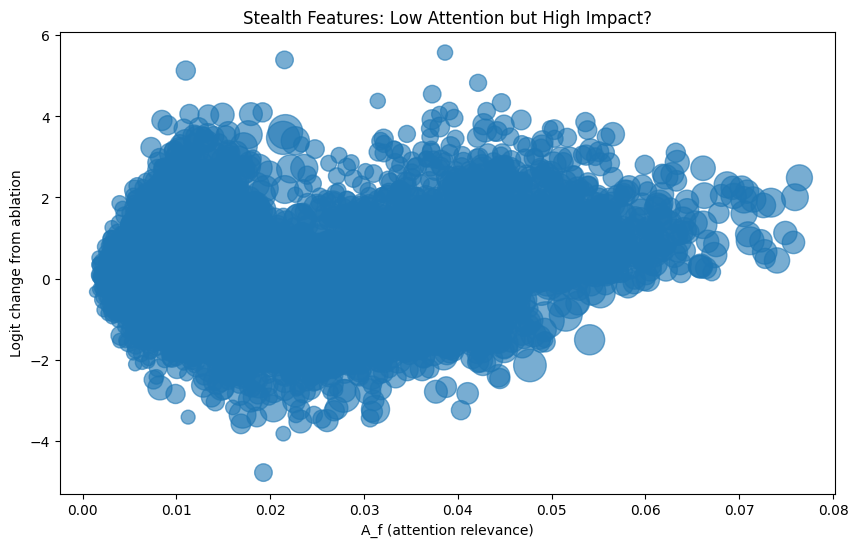

In [ ]:
# --- Load Dataset with paths ---
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None: sample = self.transform(sample)
        # Assuming you have a target_transform defined elsewhere
        # if self.target_transform is not None: target = self.target_transform(target)
        return sample, target, path

# Cell 1: Helper function to compute S_f and A_f for single image
def compute_image_sf_af(model, sae, image, label, layer_idx=9):
    """Compute S_f and A_f for a single image"""
    device = next(model.parameters()).device
    image = image.unsqueeze(0).to(device)
    
    resid_storage, attn_storage = {}, {}
    
    def save_resid_hook(tensor, hook):
        tensor.requires_grad_(True)
        resid_storage['resid'] = tensor
    
    def save_attn_hook(tensor, hook):
        tensor.requires_grad_(True)
        attn_storage['attn'] = tensor
    
    resid_hook_name = f"blocks.{layer_idx}.hook_resid_post"
    attn_hook_name = f"blocks.{layer_idx}.attn.hook_pattern"
    fwd_hooks = [(resid_hook_name, save_resid_hook), (attn_hook_name, save_attn_hook)]
    
    model.zero_grad()
    with model.hooks(fwd_hooks=fwd_hooks):
        logits = model(image)
    
    resid, attn = resid_storage['resid'], attn_storage['attn']
    
    with torch.no_grad():
        _, codes = sae.encode(resid)
    
    # Compute gradients
    target = logits[0, label]
    resid_grad, attn_grad = torch.autograd.grad(outputs=target, inputs=[resid, attn])
    
    with torch.no_grad():
        # A_f calculation
        grad_weighted_attn = (attn * attn_grad.abs()).sum(dim=1)
        cls_to_patch_attn = grad_weighted_attn[0, 0, 1:]
        active_codes_mask = codes[0, 1:, :] > 0.0
        A_f = torch.einsum('t,tf->f', cls_to_patch_attn, active_codes_mask.float())
        
        # S_f calculation
        dir_deriv = torch.einsum('d,fd->f', resid_grad[0, 0, :], sae.W_dec)
        codes_no_cls = codes[0, 1:, :]
        S_f = (codes_no_cls * dir_deriv.unsqueeze(0)).sum(0)
    
    return S_f, A_f, codes, logits

# Cell 2: Identify stealth features for this specific image
def identify_image_stealth_features(S_f, A_f, s_percentile=80, a_percentile=50):
    # Only consider features that are actually active
    active_mask = (S_f.abs() > 1e-6) | (A_f.abs() > 1e-6)
    
    if active_mask.sum() < 10:  # Not enough active features
        return torch.tensor([], dtype=torch.long)
    
    s_threshold = torch.quantile(S_f.abs()[active_mask], s_percentile / 100.0)
    a_threshold = torch.quantile(A_f[active_mask], a_percentile / 100.0)
    
    stealth_mask = active_mask & (S_f.abs() > s_threshold) & (A_f < a_threshold)
    stealth_indices = stealth_mask.nonzero(as_tuple=True)[0]
    return stealth_indices

# Cell 3: Test counterfactual impact
def test_stealth_counterfactual(model, sae, image, label, layer_idx=9, activation_threshold=0.1):
    """Full counterfactual test for one image"""
    device = next(model.parameters()).device
    
    # Get S_f, A_f and codes for this image
    S_f, A_f, codes, original_logits = compute_image_sf_af(model, sae, image, label, layer_idx)
    original_prob = F.softmax(original_logits, dim=-1)[0, label].item()
    
    # Find stealth features
    stealth_features = identify_image_stealth_features(S_f, A_f)
    
    if len(stealth_features) == 0:
        return pd.DataFrame()
    
    codes_patches = codes[0, 1:]  # (196, F)
    results = []
    
    for feat_idx in stealth_features[:10]:  # Test top 10 stealth features
        # Find active patches
        active_patches = (codes_patches[:, feat_idx] > activation_threshold).nonzero(as_tuple=True)[0]
        
        if len(active_patches) == 0:
            continue
        
        # Create masked image
        masked_image = image.unsqueeze(0).to(device).clone()
        patch_size = 16
        
        for patch_idx in active_patches:
            row = (patch_idx // 14) * patch_size
            col = (patch_idx % 14) * patch_size
            masked_image[0, :, row:row+patch_size, col:col+patch_size] = 0
        
        # Forward pass with mask
        with torch.no_grad():
            masked_logits = model(masked_image)
            masked_prob = F.softmax(masked_logits, dim=-1)[0, label].item()
        
        logit_change = (original_logits - masked_logits)[0, label].item()
        
        results.append({
            'feature_id': feat_idx.item(),
            'n_patches': len(active_patches),
            'logit_change': logit_change,
            'prob_change': original_prob - masked_prob,
            's_f': S_f[feat_idx].item(),
            'a_f': A_f[feat_idx].item()
        })
    
    return pd.DataFrame(results)

sae, model = load_models()
train_dataset = ImageFolderWithPaths(
    "./hyper-kvasir_imagefolder/train", 
    get_processor_for_precached_224_images()
)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

all_results = []
images_processed = 0
images_with_stealth = 0
num_samples = 50000

for i, (image, label, path) in enumerate(tqdm(dataloader, total=num_samples)):
    if i >= num_samples:
        break
    
    results = test_stealth_counterfactual(
        model, sae, image.squeeze(0), label.item()
    )
    
    images_processed += 1
    
    if not results.empty:
        results['image_idx'] = i
        results['true_label'] = label.item()
        all_results.append(results)
        images_with_stealth += 1

print(f"Images processed: {images_processed}")
print(f"Images with stealth features: {images_with_stealth}")

# Cell 5: Analyze (with empty check)
if all_results:
    results_df = pd.concat(all_results, ignore_index=True)
    
    print(f"Total stealth features tested: {len(results_df)}")
    print(f"Mean logit change: {results_df['logit_change'].mean():.3f}")
    print(f"Features with >0.5 logit change: {(results_df['logit_change'] > 0.5).sum()}")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['a_f'], results_df['logit_change'], 
               s=results_df['n_patches']*10, alpha=0.6)
    plt.xlabel('A_f (attention relevance)')
    plt.ylabel('Logit change from ablation')
    plt.title('Stealth Features: Low Attention but High Impact?')
    plt.show()
else:
    print("No stealth features found! Try adjusting percentile thresholds.")
    
    # Debug: Check S_f and A_f distributions for a single image
    image, label, _ = next(iter(dataloader))
    S_f, A_f, _, _ = compute_image_sf_af(model, sae, image.squeeze(0), label.item())
    
    print(f"\nS_f stats: min={S_f.min():.3f}, max={S_f.max():.3f}, mean={S_f.mean():.3f}")
    print(f"A_f stats: min={A_f.min():.3f}, max={A_f.max():.3f}, mean={A_f.mean():.3f}")
    print(f"Active features: {(S_f.abs() > 0).sum()} out of {len(S_f)}")

2025-07-04 14:26:10 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x749cd7d065c0>


STEALTH FEATURE ANALYSIS REPORT

📊 BASIC STATISTICS:
Total stealth features tested: 42422
Images processed: 10000
Images with stealth features: 8206
Average stealth features per image: 5.2

🎯 IMPACT DISTRIBUTION:
Mean logit change: 0.045
Median logit change: 0.010
Max logit change: 5.572
Features with >0.5 logit change: 6888
Features with >1.0 logit change: 2558
Features with >2.0 logit change: 533

🏷️  FEATURE CATEGORIES:
Low Impact + Very Low Attention: 35534 features (83.8%)
Medium Impact + Very Low Attention: 4330 features (10.2%)
High Impact + Very Low Attention: 2558 features (6.0%)

🏆 TOP 10 FEATURES BY LOGIT CHANGE:
Feature 2012.0: Logit Δ= 5.572, A_f= 0.039, S_f= 0.327, Patches=12.0
Feature 2533.0: Logit Δ= 5.392, A_f= 0.022, S_f=-0.500, Patches=16.0
Feature 1701.0: Logit Δ= 5.129, A_f= 0.011, S_f= 0.518, Patches=19.0
Feature 191.0: Logit Δ= 4.826, A_f= 0.042, S_f= 0.349, Patches=15.0
Feature 191.0: Logit Δ= 4.547, A_f= 0.037, S_f= 0.421, Patches=16.0
Feature 191.0: Logit Δ= 4

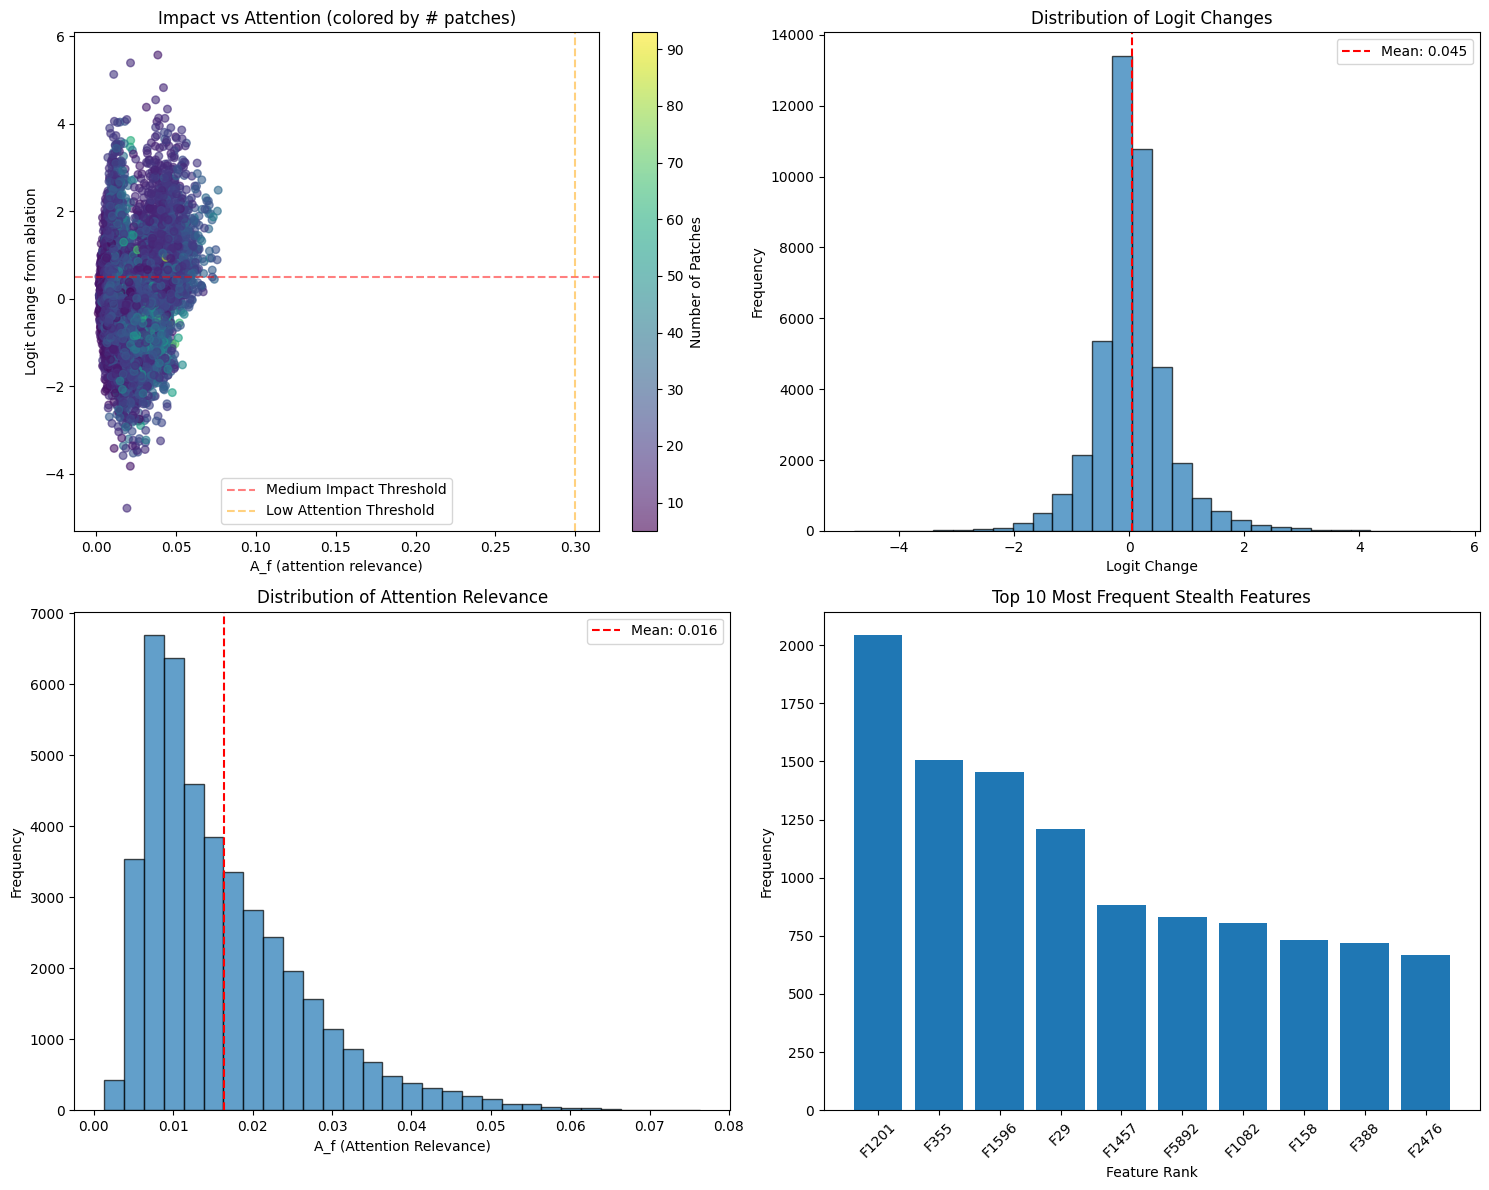


🎯 BEHAVIORAL CONSISTENCY ANALYSIS:


2025-07-04 14:26:11 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x749d23436c80>



🏅 MOST CONSISTENT STEALTH FEATURES:
Feature Count  Mean Δ  Std Δ     CV Hit Rate  Score Mean A_f
-----------------------------------------------------------------
   5051     2   2.281  0.265   0.12   100.0%  2.044    0.011
   1052     2   2.144  0.122   0.06   100.0%  2.028    0.016
   1598     9   2.399  1.022   0.43   100.0%  1.682    0.042
   4243     2   2.516  1.249   0.50   100.0%  1.681    0.019
   2061     6   1.861  0.261   0.14   100.0%  1.633    0.050
    311     2   1.630  0.151   0.09   100.0%  1.492    0.011
   3640     4   2.184  1.016   0.46   100.0%  1.491    0.014
   1835     2   1.598  0.381   0.24   100.0%  1.291    0.015
    564     4   1.471  0.233   0.16   100.0%  1.270    0.011
   1932     2   1.638  0.491   0.30   100.0%  1.260    0.011
    486    25   1.689  0.619   0.37   100.0%  1.236    0.048
   5882     8   1.679  0.668   0.40   100.0%  1.201    0.052
    537     2   1.433  0.280   0.20   100.0%  1.199    0.029
    191   342   1.847  0.926   0.50    97.1

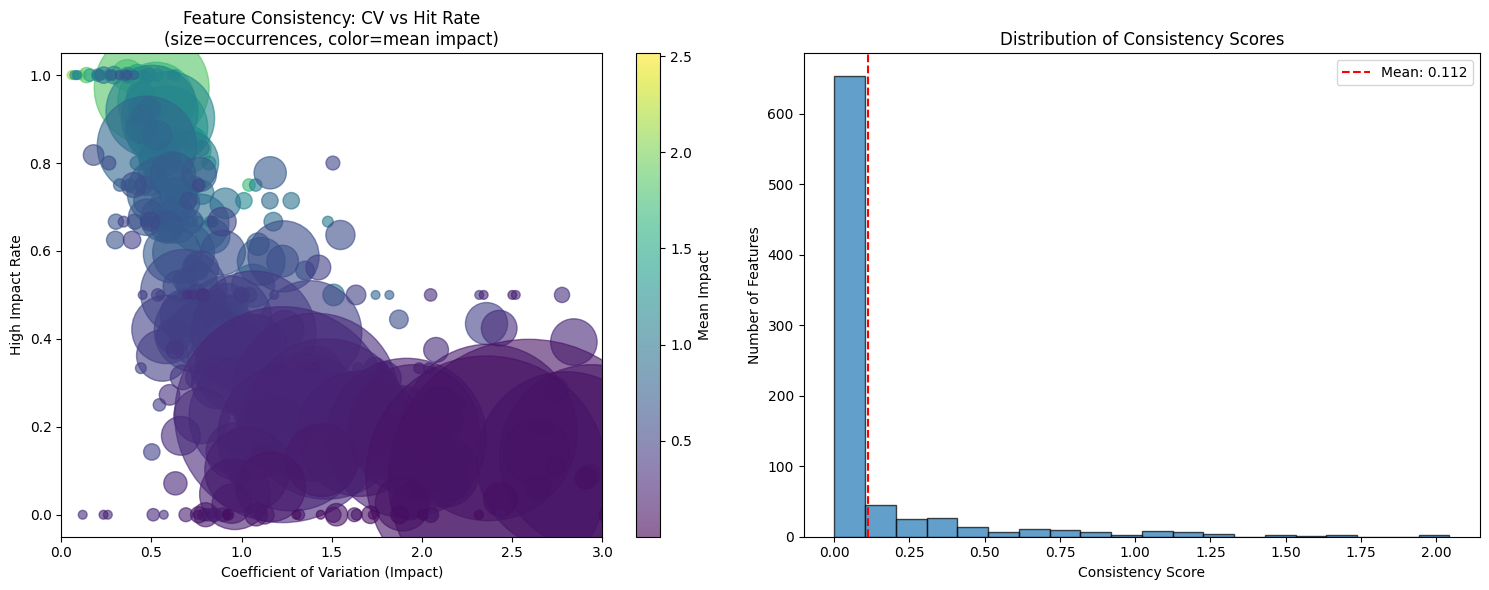


💾 Consistency analysis saved to: ./results/feature_consistency_analysis.csv

💾 Results saved to:
  - ./results/detailed_stealth_analysis.csv
  - ./results/promising_stealth_features.csv


In [25]:
# Cell 5: Enhanced Analysis with Detailed Numerical Insights
if all_results:
    results_df = pd.concat(all_results, ignore_index=True)
    
    print("="*80)
    print("STEALTH FEATURE ANALYSIS REPORT")
    print("="*80)
    
    print(f"\n📊 BASIC STATISTICS:")
    print(f"Total stealth features tested: {len(results_df)}")
    print(f"Images processed: {images_processed}")
    print(f"Images with stealth features: {images_with_stealth}")
    print(f"Average stealth features per image: {len(results_df)/images_with_stealth:.1f}")
    
    # Impact Distribution
    print(f"\n🎯 IMPACT DISTRIBUTION:")
    print(f"Mean logit change: {results_df['logit_change'].mean():.3f}")
    print(f"Median logit change: {results_df['logit_change'].median():.3f}")
    print(f"Max logit change: {results_df['logit_change'].max():.3f}")
    print(f"Features with >0.5 logit change: {(results_df['logit_change'] > 0.5).sum()}")
    print(f"Features with >1.0 logit change: {(results_df['logit_change'] > 1.0).sum()}")
    print(f"Features with >2.0 logit change: {(results_df['logit_change'] > 2.0).sum()}")
    
    # Create impact categories
    def categorize_impact(row):
        logit_change = row['logit_change']
        a_f = row['a_f']
        
        if logit_change > 1.0:
            impact = "High Impact"
        elif logit_change > 0.5:
            impact = "Medium Impact"
        else:
            impact = "Low Impact"
            
        if a_f < 0.1:
            attention = "Very Low Attention"
        elif a_f < 0.3:
            attention = "Low Attention"
        elif a_f < 0.6:
            attention = "Medium Attention"
        else:
            attention = "High Attention"
            
        return f"{impact} + {attention}"
    
    results_df['category'] = results_df.apply(categorize_impact, axis=1)
    
    print(f"\n🏷️  FEATURE CATEGORIES:")
    category_counts = results_df['category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(results_df)) * 100
        print(f"{category}: {count} features ({percentage:.1f}%)")
    
    # Top Features by Different Criteria
    print(f"\n🏆 TOP 10 FEATURES BY LOGIT CHANGE:")
    top_impact = results_df.nlargest(10, 'logit_change')[['feature_id', 'logit_change', 'a_f', 's_f', 'n_patches']]
    for idx, row in top_impact.iterrows():
        print(f"Feature {row['feature_id']:4}: Logit Δ={row['logit_change']:6.3f}, A_f={row['a_f']:6.3f}, S_f={row['s_f']:6.3f}, Patches={row['n_patches']}")
    
    print(f"\n🎭 TOP 10 'STEALTH' FEATURES (High Impact, Low Attention):")
    stealth_features = results_df[results_df['logit_change'] > 0.3].nsmallest(10, 'a_f')[['feature_id', 'logit_change', 'a_f', 's_f', 'n_patches']]
    for idx, row in stealth_features.iterrows():
        print(f"Feature {row['feature_id']:4}: Logit Δ={row['logit_change']:6.3f}, A_f={row['a_f']:6.3f}, S_f={row['s_f']:6.3f}, Patches={row['n_patches']}")
    
    # Feature Frequency Analysis
    print(f"\n🔄 MOST FREQUENT STEALTH FEATURES:")
    feature_frequency = results_df['feature_id'].value_counts().head(10)
    feature_stats = results_df.groupby('feature_id').agg({
        'logit_change': ['mean', 'std', 'max'],
        'a_f': 'mean',
        's_f': 'mean'
    }).round(3)
    
    for feat_id, count in feature_frequency.items():
        stats = feature_stats.loc[feat_id]
        mean_impact = stats[('logit_change', 'mean')]
        max_impact = stats[('logit_change', 'max')]
        mean_af = stats[('a_f', 'mean')]
        print(f"Feature {feat_id:4d}: Appears {count:2d}x, Mean Δ={mean_impact:5.3f}, Max Δ={max_impact:5.3f}, Mean A_f={mean_af:5.3f}")
    
    # Quantile Analysis
    print(f"\n📈 IMPACT QUANTILES:")
    quantiles = [0.5, 0.75, 0.9, 0.95, 0.99]
    for q in quantiles:
        threshold = results_df['logit_change'].quantile(q)
        count = (results_df['logit_change'] >= threshold).sum()
        print(f"{int(q*100)}th percentile: Logit change ≥ {threshold:.3f} ({count} features)")
    
    # A_f vs Impact Analysis
    print(f"\n🎯 ATTENTION vs IMPACT BREAKDOWN:")
    
    # Create bins for A_f
    results_df['a_f_bin'] = pd.cut(results_df['a_f'], 
                                   bins=[0, 0.1, 0.3, 0.6, 1.0], 
                                   labels=['Very Low (0-0.1)', 'Low (0.1-0.3)', 'Medium (0.3-0.6)', 'High (0.6+)'])
    
    # Create bins for logit change
    results_df['impact_bin'] = pd.cut(results_df['logit_change'], 
                                      bins=[0, 0.5, 1.0, 2.0, float('inf')], 
                                      labels=['Low (0-0.5)', 'Medium (0.5-1.0)', 'High (1.0-2.0)', 'Very High (2.0+)'])
    
    cross_tab = pd.crosstab(results_df['a_f_bin'], results_df['impact_bin'], margins=True)
    print(cross_tab)
    
    # Most Promising Stealth Features (Consistent High Impact, Low Attention)
    print(f"\n⭐ MOST PROMISING STEALTH FEATURES (Appear 2+ times with high impact):")
    promising = results_df[results_df['logit_change'] > 0.5].groupby('feature_id').agg({
        'logit_change': ['count', 'mean', 'min'],
        'a_f': 'mean',
        's_f': 'mean'
    }).round(3)
    
    promising = promising[promising[('logit_change', 'count')] >= 2]  # Appears at least twice
    promising = promising.sort_values(('logit_change', 'mean'), ascending=False)
    
    print(f"{'Feature':>7} {'Count':>5} {'Mean Δ':>7} {'Min Δ':>6} {'Mean A_f':>8} {'Mean S_f':>8}")
    print("-" * 50)
    for feat_id, row in promising.head(15).iterrows():
        count = int(row[('logit_change', 'count')])
        mean_delta = row[('logit_change', 'mean')]
        min_delta = row[('logit_change', 'min')]
        mean_af = row[('a_f', 'mean')]
        mean_sf = row[('s_f', 'mean')]
        print(f"{feat_id:7d} {count:5d} {mean_delta:7.3f} {min_delta:6.3f} {mean_af:8.3f} {mean_sf:8.3f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot with categories
    scatter = axes[0,0].scatter(results_df['a_f'], results_df['logit_change'], 
                               c=results_df['n_patches'], s=30, alpha=0.6, cmap='viridis')
    axes[0,0].set_xlabel('A_f (attention relevance)')
    axes[0,0].set_ylabel('Logit change from ablation')
    axes[0,0].set_title('Impact vs Attention (colored by # patches)')
    axes[0,0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Medium Impact Threshold')
    axes[0,0].axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Low Attention Threshold')
    axes[0,0].legend()
    plt.colorbar(scatter, ax=axes[0,0], label='Number of Patches')
    
    # 2. Impact distribution
    axes[0,1].hist(results_df['logit_change'], bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(results_df['logit_change'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["logit_change"].mean():.3f}')
    axes[0,1].set_xlabel('Logit Change')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Logit Changes')
    axes[0,1].legend()
    
    # 3. A_f distribution
    axes[1,0].hist(results_df['a_f'], bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(results_df['a_f'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["a_f"].mean():.3f}')
    axes[1,0].set_xlabel('A_f (Attention Relevance)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Attention Relevance')
    axes[1,0].legend()
    
    # 4. Feature frequency
    top_features = results_df['feature_id'].value_counts().head(10)
    axes[1,1].bar(range(len(top_features)), top_features.values)
    axes[1,1].set_xlabel('Feature Rank')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Top 10 Most Frequent Stealth Features')
    axes[1,1].set_xticks(range(len(top_features)))
    axes[1,1].set_xticklabels([f'F{fid}' for fid in top_features.index], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # BEHAVIORAL CONSISTENCY ANALYSIS
    print(f"\n🎯 BEHAVIORAL CONSISTENCY ANALYSIS:")
    print("="*50)
    
    # Only analyze features that appear multiple times
    feature_counts = results_df['feature_id'].value_counts()
    multi_occurrence_features = feature_counts[feature_counts >= 2].index
    
    if len(multi_occurrence_features) > 0:
        consistency_stats = []
        
        for feat_id in multi_occurrence_features:
            feat_data = results_df[results_df['feature_id'] == feat_id]
            
            # Basic stats
            count = len(feat_data)
            mean_impact = feat_data['logit_change'].mean()
            std_impact = feat_data['logit_change'].std()
            min_impact = feat_data['logit_change'].min()
            max_impact = feat_data['logit_change'].max()
            
            # Consistency metrics
            cv_impact = std_impact / mean_impact if mean_impact > 0 else float('inf')  # Coefficient of variation
            
            # Reliability: % of times it produces "significant" impact (>0.5)
            high_impact_rate = (feat_data['logit_change'] > 0.5).mean()
            
            # Consistency score: high mean, low CV, high reliability
            if cv_impact < float('inf') and mean_impact > 0:
                consistency_score = (mean_impact * high_impact_rate) / (1 + cv_impact)
            else:
                consistency_score = 0
            
            # Mean S_f and A_f to verify stealth characteristics
            mean_sf = feat_data['s_f'].mean()
            mean_af = feat_data['a_f'].mean()
            
            consistency_stats.append({
                'feature_id': feat_id,
                'count': count,
                'mean_impact': mean_impact,
                'std_impact': std_impact,
                'cv_impact': cv_impact,
                'min_impact': min_impact,
                'max_impact': max_impact,
                'high_impact_rate': high_impact_rate,
                'consistency_score': consistency_score,
                'mean_sf': mean_sf,
                'mean_af': mean_af
            })
        
        consistency_df = pd.DataFrame(consistency_stats)
        consistency_df = consistency_df.sort_values('consistency_score', ascending=False)
        
        print(f"\n🏅 MOST CONSISTENT STEALTH FEATURES:")
        print(f"{'Feature':>7} {'Count':>5} {'Mean Δ':>7} {'Std Δ':>6} {'CV':>6} {'Hit Rate':>8} {'Score':>6} {'Mean A_f':>8}")
        print("-" * 65)
        
        for _, row in consistency_df.head(15).iterrows():
            feat_id = int(row['feature_id'])
            count = int(row['count'])
            mean_impact = row['mean_impact']
            std_impact = row['std_impact']
            cv = row['cv_impact']
            hit_rate = row['high_impact_rate']
            score = row['consistency_score']
            mean_af = row['mean_af']
            
            cv_str = f"{cv:.2f}" if cv < 10 else ">10"
            print(f"{feat_id:7d} {count:5d} {mean_impact:7.3f} {std_impact:6.3f} {cv_str:>6} {hit_rate:8.1%} {score:6.3f} {mean_af:8.3f}")
        
        # Consistency categories
        print(f"\n📊 CONSISTENCY CATEGORIES:")
        
        def categorize_consistency(row):
            cv = row['cv_impact']
            hit_rate = row['high_impact_rate']
            mean_impact = row['mean_impact']
            
            if cv < 0.3 and hit_rate > 0.8 and mean_impact > 0.5:
                return "Highly Consistent"
            elif cv < 0.5 and hit_rate > 0.6 and mean_impact > 0.3:
                return "Moderately Consistent"
            elif cv < 1.0 and hit_rate > 0.4:
                return "Somewhat Consistent"
            else:
                return "Inconsistent"
        
        consistency_df['consistency_category'] = consistency_df.apply(categorize_consistency, axis=1)
        category_counts = consistency_df['consistency_category'].value_counts()
        
        for category, count in category_counts.items():
            percentage = (count / len(consistency_df)) * 100
            print(f"{category}: {count} features ({percentage:.1f}%)")
        
        # Reliability analysis
        print(f"\n🎲 RELIABILITY BREAKDOWN:")
        print(f"Features with >80% high-impact rate: {(consistency_df['high_impact_rate'] > 0.8).sum()}")
        print(f"Features with >60% high-impact rate: {(consistency_df['high_impact_rate'] > 0.6).sum()}")
        print(f"Features with CV < 0.5 (low variability): {(consistency_df['cv_impact'] < 0.5).sum()}")
        print(f"Features with CV < 0.3 (very low variability): {(consistency_df['cv_impact'] < 0.3).sum()}")
        
        # Most vs Least consistent
        print(f"\n⭐ TOP 5 MOST RELIABLE FEATURES (High impact rate, low CV):")
        reliable_features = consistency_df[
            (consistency_df['high_impact_rate'] > 0.6) & 
            (consistency_df['cv_impact'] < 0.8)
        ].sort_values('high_impact_rate', ascending=False)
        
        for _, row in reliable_features.head(5).iterrows():
            feat_id = int(row['feature_id'])
            hit_rate = row['high_impact_rate']
            cv = row['cv_impact']
            mean_impact = row['mean_impact']
            count = int(row['count'])
            print(f"Feature {feat_id}: {hit_rate:.1%} hit rate, CV={cv:.3f}, Mean Δ={mean_impact:.3f} ({count} occurrences)")
        
        print(f"\n⚠️  TOP 5 MOST UNRELIABLE FEATURES (High CV or low hit rate):")
        unreliable_features = consistency_df.sort_values(['cv_impact', 'high_impact_rate'], ascending=[False, True])
        
        for _, row in unreliable_features.head(5).iterrows():
            feat_id = int(row['feature_id'])
            hit_rate = row['high_impact_rate']
            cv = row['cv_impact']
            mean_impact = row['mean_impact']
            count = int(row['count'])
            cv_str = f"{cv:.3f}" if cv < 10 else ">10"
            print(f"Feature {feat_id}: {hit_rate:.1%} hit rate, CV={cv_str}, Mean Δ={mean_impact:.3f} ({count} occurrences)")
        
        # Add consistency visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # CV vs Hit Rate scatter
        scatter = axes[0].scatter(consistency_df['cv_impact'], consistency_df['high_impact_rate'], 
                                 s=consistency_df['count']*20, alpha=0.6, 
                                 c=consistency_df['mean_impact'], cmap='viridis')
        axes[0].set_xlabel('Coefficient of Variation (Impact)')
        axes[0].set_ylabel('High Impact Rate')
        axes[0].set_title('Feature Consistency: CV vs Hit Rate\n(size=occurrences, color=mean impact)')
        axes[0].set_xlim(0, min(3, consistency_df['cv_impact'].max()))
        plt.colorbar(scatter, ax=axes[0], label='Mean Impact')
        
        # Consistency score distribution
        axes[1].hist(consistency_df['consistency_score'], bins=20, alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('Consistency Score')
        axes[1].set_ylabel('Number of Features')
        axes[1].set_title('Distribution of Consistency Scores')
        axes[1].axvline(consistency_df['consistency_score'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {consistency_df["consistency_score"].mean():.3f}')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Save consistency results
        consistency_df.to_csv('./results/feature_consistency_analysis.csv', index=False)
        print(f"\n💾 Consistency analysis saved to: ./results/feature_consistency_analysis.csv")
        
    else:
        print("No features appear multiple times - cannot analyze consistency.")
    
    # Save detailed results
    results_df.to_csv('./results/detailed_stealth_analysis.csv', index=False)
    promising.to_csv('./results/promising_stealth_features.csv')
    
    print(f"\n💾 Results saved to:")
    print(f"  - ./results/detailed_stealth_analysis.csv")
    print(f"  - ./results/promising_stealth_features.csv")
    
else:
    print("No stealth features found! Try adjusting percentile thresholds.")
    
    # Debug: Check S_f and A_f distributions for a single image
    image, label, _ = next(iter(dataloader))
    S_f, A_f, _, _ = compute_image_sf_af(model, sae, image.squeeze(0), label.item())
    
    print(f"\nS_f stats: min={S_f.min():.3f}, max={S_f.max():.3f}, mean={S_f.mean():.3f}")
    print(f"A_f stats: min={A_f.min():.3f}, max={A_f.max():.3f}, mean={A_f.mean():.3f}")
    print(f"Active features: {(S_f.abs() > 0).sum()} out of {len(S_f)}")

In [2]:
from sfaf_dict import build_stealth_feature_dictionary
import torchvision
from transmm_sfaf import load_models, get_processor_for_precached_224_images, IDX2CLS
import torch


sae, model = load_models()
# Build new dictionary
label_map = {2: 3, 3: 2}

def custom_target_transform(target):
    return label_map.get(target, target)

train_path = "./hyper-kvasir_imagefolder/train"
train_dataset = torchvision.datasets.ImageFolder(
    train_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform
)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
layer_id = 9
stealth_dict = build_stealth_feature_dictionary(
    model, sae, dataloader, 
    n_samples=50000,
    min_logit_impact=0.01,        # Only features with real impact
    min_consistency_score=0.01,   # Only reliable features  
    layer_idx=layer_id,
    min_occurrences=3,           # Must appear 3+ times
    save_path=f"./sae_dictionaries/sfaf_stealth_l{layer_id}_logits.pt"
)

# Get the most reliable stealth features
reliable_feature_ids = stealth_dict['feature_ids']
consistency_scores = stealth_dict['metrics'][:, 3]  # consistency_score column

2025-07-06 19:38:54 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-06 19:38:54 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-07-06 19:38:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-06 19:38:55 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-06 19:38:56 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-06 19:38:56 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-06 19:38:56 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-06 19:38:56 INFO:root: Filling in 2 missing keys with default initialization
2025-07-06 19:38:56 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-06 19:38:56 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


Analyzing stealth features: 100%|██████████| 257/257 [52:38<00:00, 12.29s/it]


In [13]:
print(len(stealth_dict["feature_ids"]))

10


2025-07-07 11:07:40 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 128}
2025-07-07 11:07:40 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.


2025-07-07 11:07:41 DEBUG:urllib3.connectionpool: Resetting dropped connection: huggingface.co
2025-07-07 11:07:41 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/config.json HTTP/1.1" 307 0
2025-07-07 11:07:41 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /api/resolve-cache/models/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/063c6c38a5d8510b2e57df480445e94b231dad2c/config.json HTTP/1.1" 200 0


ln_pre not set


2025-07-07 11:07:42 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-07 11:07:42 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors HTTP/1.1" 302 0
2025-07-07 11:07:42 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-07 11:07:42 INFO:root: Filling in 2 missing keys with default initialization
2025-07-07 11:07:42 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-07 11:07:42 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT
Loading existing S_f/A_f dictionary from ./sae_dictionaries/sfaf_stealth_l9_logits.pt
CLASS-SPECIFIC STEALTH FEATURE ANALYSIS

OVERALL CLASS DISTRIBUTION:
   Class    Count   Percentage
--------------------------------
   cecum    12245        6.6%
   ileum      396        0.2%
retroflex-rectum    14336        7.7%
 pylorus    69680       37.4%
retroflex-stomach    18633       10.0%
  z-line    71065       38.1%

PER-CLASS IMPACT SUMMARY:
       Class Features   Mean Δ  Helpful  Harmful    Ratio
--------------------------------------------------------------------
       cecum      236    0.981      177        0     0.75
       ileum       77    0.106        8       14     0.10
retroflex-rectum      472    0.044        1       56     0.00
     pylorus      581    0.467      265       29     0.46
retroflex-stomach     

2025-07-07 11:07:42 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x7bd96aac4340>


Class cecum: Strategy='boost_positive', C-Power=205.70, D-Power=0.02
Class ileum: Strategy='boost_positive', C-Power=13.98, D-Power=4.05
Class retroflex-rectum: Strategy='boost_positive', C-Power=34.78, D-Power=15.12
Class pylorus: Strategy='boost_positive', C-Power=289.21, D-Power=8.95
Class retroflex-stomach: Strategy='boost_positive', C-Power=29.22, D-Power=22.63
Class z-line: Strategy='boost_positive', C-Power=312.22, D-Power=0.00


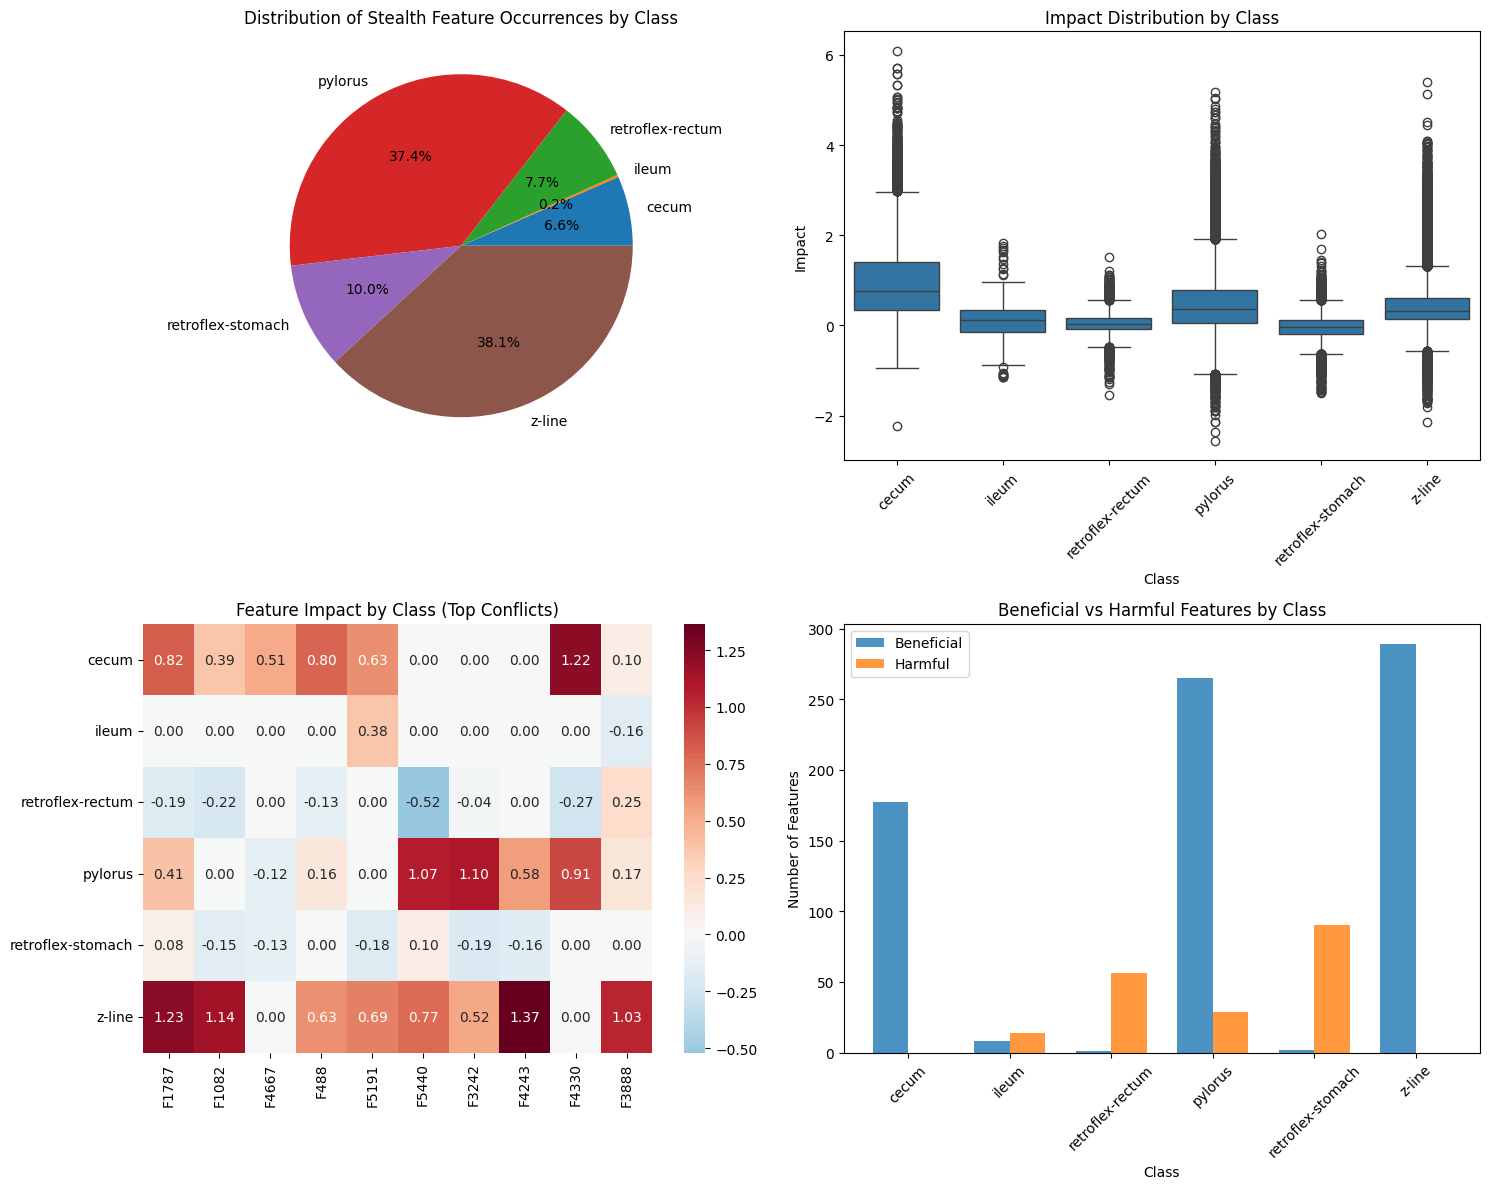

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple

def analyze_class_specific_stealth_behavior(
    stealth_dict: Dict,
    class_names: List[str] = None,
    min_occurrences_per_class: int = 2
) -> Dict:
    """
    Analyze how stealth features behave differently across classes.
    Identifies class-specific effects, conflicts, and distribution patterns.
    
    Args:
        stealth_dict: Dictionary from build_stealth_feature_dictionary
        class_names: Optional list of class names for better readability
        min_occurrences_per_class: Minimum occurrences per class to include in analysis
        
    Returns:
        Dictionary with detailed class-specific analysis results
    """
    
    if len(stealth_dict['feature_ids']) == 0:
        print("No stealth features found in dictionary.")
        return {}
    
    # Extract raw data for analysis
    raw_data = stealth_dict['raw_data']
    
    # Build class-specific feature behavior
    class_feature_stats = defaultdict(lambda: defaultdict(list))
    feature_class_matrix = defaultdict(lambda: defaultdict(float))
    
    for feat_id, data in raw_data.items():
        impacts = data['all_impacts']
        classes = data['all_classes']
        s_f_values = data['all_s_f']
        a_f_values = data['all_a_f']
        
        for impact, cls, sf, af in zip(impacts, classes, s_f_values, a_f_values):
            class_feature_stats[cls][feat_id].append({
                'impact': impact,
                's_f': sf,
                'a_f': af
            })
    
    # Calculate per-class statistics for each feature
    class_analysis_results = {}
    feature_class_summary = {}
    
    print("CLASS-SPECIFIC STEALTH FEATURE ANALYSIS")
    print("=" * 60)
    
    # 1. Overall class distribution
    total_class_counts = defaultdict(int)
    for feat_data in raw_data.values():
        for cls in feat_data['all_classes']:
            total_class_counts[cls] += 1
    
    print(f"\nOVERALL CLASS DISTRIBUTION:")
    print(f"{'Class':>8} {'Count':>8} {'Percentage':>12}")
    print("-" * 32)
    total_occurrences = sum(total_class_counts.values())
    for cls in sorted(total_class_counts.keys()):
        count = total_class_counts[cls]
        pct = (count / total_occurrences) * 100
        class_name = class_names[cls] if class_names and cls < len(class_names) else f"Class_{cls}"
        print(f"{class_name:>8} {count:>8} {pct:>10.1f}%")
    
    # 2. Per-class feature analysis
    class_stats = {}
    for cls in sorted(total_class_counts.keys()):
        class_name = class_names[cls] if class_names and cls < len(class_names) else f"Class_{cls}"
        
        class_impacts = []
        class_features = set()
        class_feature_details = {}
        
        for feat_id, occurrences in class_feature_stats[cls].items():
            if len(occurrences) >= min_occurrences_per_class:
                impacts = [occ['impact'] for occ in occurrences]
                mean_impact = np.mean(impacts)
                std_impact = np.std(impacts)
                
                class_impacts.extend(impacts)
                class_features.add(feat_id)
                class_feature_details[feat_id] = {
                    'mean_impact': mean_impact,
                    'std_impact': std_impact,
                    'count': len(impacts),
                    'beneficial': mean_impact > 0.5,
                    'harmful': mean_impact < -0.1  # Negative impact threshold
                }
        
        if class_impacts:
            class_stats[cls] = {
                'name': class_name,
                'total_impacts': len(class_impacts),
                'mean_impact': np.mean(class_impacts),
                'std_impact': np.std(class_impacts),
                'beneficial_features': sum(1 for f in class_feature_details.values() if f['beneficial']),
                'harmful_features': sum(1 for f in class_feature_details.values() if f['harmful']),
                'total_features': len(class_features),
                'feature_details': class_feature_details
            }
    
    # 3. Class-wise impact summary
    print(f"\nPER-CLASS IMPACT SUMMARY:")
    print(f"{'Class':>12} {'Features':>8} {'Mean Δ':>8} {'Helpful':>8} {'Harmful':>8} {'Ratio':>8}")
    print("-" * 68)
    
    for cls in sorted(class_stats.keys()):
        stats = class_stats[cls]
        helpful_ratio = stats['beneficial_features'] / max(stats['total_features'], 1)
        print(f"{stats['name']:>12} {stats['total_features']:>8} {stats['mean_impact']:>8.3f} "
              f"{stats['beneficial_features']:>8} {stats['harmful_features']:>8} {helpful_ratio:>8.2f}")
    
    # 4. Feature conflict analysis (features good for some classes, bad for others)
    print(f"\nFEATURE CONFLICT ANALYSIS:")
    print("-" * 40)
    
    feature_conflicts = {}
    for feat_id in stealth_dict['feature_ids']:
        feat_id = feat_id.item()
        
        beneficial_classes = []
        harmful_classes = []
        neutral_classes = []
        
        for cls, stats in class_stats.items():
            if feat_id in stats['feature_details']:
                feat_stats = stats['feature_details'][feat_id]
                if feat_stats['beneficial']:
                    beneficial_classes.append((cls, feat_stats['mean_impact']))
                elif feat_stats['harmful']:
                    harmful_classes.append((cls, feat_stats['mean_impact']))
                else:
                    neutral_classes.append((cls, feat_stats['mean_impact']))
        
        if len(beneficial_classes) > 0 and len(harmful_classes) > 0:
            feature_conflicts[feat_id] = {
                'beneficial': beneficial_classes,
                'harmful': harmful_classes,
                'neutral': neutral_classes,
                'conflict_score': len(beneficial_classes) * len(harmful_classes)
            }
    
    # Sort conflicts by severity
    sorted_conflicts = sorted(feature_conflicts.items(), 
                            key=lambda x: x[1]['conflict_score'], reverse=True)
    
    print(f"Found {len(sorted_conflicts)} features with class conflicts:")
    print(f"{'Feature':>8} {'Helpful':>8} {'Harmful':>8} {'Conflict':>8}")
    print("-" * 36)
    
    for feat_id, conflict in sorted_conflicts[:10]:  # Top 10 conflicts
        n_helpful = len(conflict['beneficial'])
        n_harmful = len(conflict['harmful'])
        conflict_score = conflict['conflict_score']
        print(f"{feat_id:>8} {n_helpful:>8} {n_harmful:>8} {conflict_score:>8}")
    
    # 5. Detailed conflict breakdown
    if sorted_conflicts:
        print(f"\nTOP 5 MOST CONFLICTED FEATURES:")
        for feat_id, conflict in sorted_conflicts[:5]:
            print(f"\nFeature {feat_id}:")
            print("  Beneficial for:")
            for cls, impact in conflict['beneficial']:
                class_name = class_names[cls] if class_names and cls < len(class_names) else f"Class_{cls}"
                print(f"    {class_name}: {impact:.3f}")
            print("  Harmful for:")
            for cls, impact in conflict['harmful']:
                class_name = class_names[cls] if class_names and cls < len(class_names) else f"Class_{cls}"
                print(f"    {class_name}: {impact:.3f}")
    
    # 6. Class-specific feature recommendations
    print(f"\nCLASS-SPECIFIC RECOMMENDATIONS:")
    print("=" * 40)
    
    for cls in sorted(class_stats.keys()):
        stats = class_stats[cls]
        class_name = stats['name']
        
        # Get best features for this class
        best_features = [(feat_id, details['mean_impact']) 
                        for feat_id, details in stats['feature_details'].items() 
                        if details['beneficial']]
        best_features.sort(key=lambda x: x[1], reverse=True)
        
        # Get worst features for this class
        worst_features = [(feat_id, details['mean_impact']) 
                         for feat_id, details in stats['feature_details'].items() 
                         if details['harmful']]
        worst_features.sort(key=lambda x: x[1])
        
        print(f"\n{class_name}:")
        if best_features:
            print(f"  Best features: {[f[0] for f in best_features[:50]]}")
        if worst_features:
            print(f"  Avoid features: {[f[0] for f in worst_features[:50]]}")
    
    # 7. Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Class distribution pie chart
    class_counts = [total_class_counts[cls] for cls in sorted(total_class_counts.keys())]
    class_labels = [class_names[cls] if class_names and cls < len(class_names) else f"Class_{cls}" 
                   for cls in sorted(total_class_counts.keys())]
    
    axes[0,0].pie(class_counts, labels=class_labels, autopct='%1.1f%%')
    axes[0,0].set_title('Distribution of Stealth Feature Occurrences by Class')
    
    # Per-class impact distribution
    class_impacts_for_plot = []
    class_labels_for_plot = []
    for cls in sorted(class_stats.keys()):
        stats = class_stats[cls]
        all_impacts = []
        for feat_details in stats['feature_details'].values():
            # Reconstruct impacts from class_feature_stats
            feat_id = None
            for fid, details in stats['feature_details'].items():
                if details == feat_details:
                    feat_id = fid
                    break
            if feat_id and feat_id in class_feature_stats[cls]:
                impacts = [occ['impact'] for occ in class_feature_stats[cls][feat_id]]
                all_impacts.extend(impacts)
        
        if all_impacts:
            class_impacts_for_plot.extend(all_impacts)
            class_labels_for_plot.extend([stats['name']] * len(all_impacts))
    
    if class_impacts_for_plot:
        impact_df = pd.DataFrame({
            'Impact': class_impacts_for_plot,
            'Class': class_labels_for_plot
        })
        sns.boxplot(data=impact_df, x='Class', y='Impact', ax=axes[0,1])
        axes[0,1].set_title('Impact Distribution by Class')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Feature conflict heatmap
    if sorted_conflicts:
        conflict_matrix_data = []
        conflict_features = [conf[0] for conf in sorted_conflicts[:10]]
        
        for cls in sorted(class_stats.keys()):
            row = []
            for feat_id in conflict_features:
                if feat_id in class_stats[cls]['feature_details']:
                    impact = class_stats[cls]['feature_details'][feat_id]['mean_impact']
                    row.append(impact)
                else:
                    row.append(0)
            conflict_matrix_data.append(row)
        
        conflict_df = pd.DataFrame(
            conflict_matrix_data,
            index=[class_names[cls] if class_names and cls < len(class_names) else f"Class_{cls}" 
                  for cls in sorted(class_stats.keys())],
            columns=[f"F{fid}" for fid in conflict_features]
        )
        
        sns.heatmap(conflict_df, annot=True, cmap='RdBu_r', center=0, 
                   fmt='.2f', ax=axes[1,0])
        axes[1,0].set_title('Feature Impact by Class (Top Conflicts)')
    
    # Class-wise beneficial vs harmful features
    helpful_counts = []
    harmful_counts = []
    class_names_plot = []
    
    for cls in sorted(class_stats.keys()):
        stats = class_stats[cls]
        helpful_counts.append(stats['beneficial_features'])
        harmful_counts.append(stats['harmful_features'])
        class_names_plot.append(stats['name'])

        constructive_power = 0
        destructive_power = 0

        if 'feature_details' in stats:
            for feat_details in stats['feature_details'].values():
                if feat_details['mean_impact'] > 0:
                    # Sum of positive impacts
                    constructive_power += feat_details['mean_impact'] 
                else:
                    # Sum of absolute negative impacts
                    # print(feat_details['mean_impact'])
                    destructive_power += abs(feat_details['mean_impact']) 

        # Store the strategy in your analysis results
        if constructive_power > destructive_power:
            class_strategy = 'boost_positive'
        else:
            class_strategy = 'deboost_negative'
            
        class_stats[cls]['preferred_strategy'] = class_strategy
        class_stats[cls]['constructive_power'] = constructive_power
        class_stats[cls]['destructive_power'] = destructive_power

        print(f"Class {stats['name']}: Strategy='{class_strategy}', C-Power={constructive_power:.2f}, D-Power={destructive_power:.2f}")
    
    x = np.arange(len(class_names_plot))
    width = 0.35
    
    axes[1,1].bar(x - width/2, helpful_counts, width, label='Beneficial', alpha=0.8)
    axes[1,1].bar(x + width/2, harmful_counts, width, label='Harmful', alpha=0.8)
    axes[1,1].set_xlabel('Class')
    axes[1,1].set_ylabel('Number of Features')
    axes[1,1].set_title('Beneficial vs Harmful Features by Class')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(class_names_plot, rotation=45)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()


    
    # Return comprehensive results
    return {
        'class_stats': class_stats,
        'feature_conflicts': feature_conflicts,
        'total_class_counts': dict(total_class_counts),
        'conflict_summary': {
            'total_conflicts': len(sorted_conflicts),
            'most_conflicted': sorted_conflicts[:5] if sorted_conflicts else []
        }
    }

from transmm_sfaf import load_or_build_sf_af_dictionary, load_models

sae, vit_model = load_models()
stealth_dict = load_or_build_sf_af_dictionary(
    vit_model, sae, n_samples=50000, layer_idx=9, dict_path=f"./sae_dictionaries/sfaf_stealth_l9_logits.pt", rebuild=False
)
class_analysis = analyze_class_specific_stealth_behavior(
stealth_dict, 
class_names=["cecum", "ileum", "retroflex-rectum", "pylorus", "retroflex-stomach", "z-line"],  # Your actual class names
min_occurrences_per_class=2
)

In [55]:
raw_data = stealth_dict['raw_data']

# Check data for the globally best feature for cecum
cecum_best_feat_data = raw_data.get(2712)
print("Data for Global Best Cecum Feature (3635):", cecum_best_feat_data)

# Now check data for a feature that *is* being selected at inference
cecum_selected_feat_data = raw_data.get(3759)
print("Data for Contextually Selected Cecum Feature (3759):", cecum_selected_feat_data)

# Check data for the globally best feature for cecum
cecum_best_feat_data = raw_data.get(2148)
print("Data for Global Best Cecum Feature ():", cecum_best_feat_data)

Data for Global Best Cecum Feature (3635): None
Data for Contextually Selected Cecum Feature (3759): None
Data for Global Best Cecum Feature (): None


In [3]:
import numpy as np
import pandas as pd

# --- 1. Define the Scoring Logic ---
# (This is the exact code you provided)

def sigmoid(x):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-x))

def calculate_feature_scores(feature_data, target_class, s_f_weight=5.0):
    """
    Calculates the combined usefulness scores for a feature for a specific class.
    """
    if not feature_data:
        return None

    class_impacts = [
        val for val, cls in zip(feature_data.get('all_impacts', []), feature_data.get('all_classes', []))
        if cls == target_class
    ]
    class_s_f_values = [
        val for val, cls in zip(feature_data.get('all_s_f', []), feature_data.get('all_classes', []))
        if cls == target_class
    ]

    if not class_impacts or not class_s_f_values:
        return None

    mean_impact = np.mean(class_impacts)
    mean_s_f = np.mean(class_s_f_values)
    
    s_f_multiplier_pos = sigmoid(mean_s_f * s_f_weight)
    s_f_multiplier_neg = 1 - s_f_multiplier_pos

    constructive_score = mean_impact * s_f_multiplier_pos
    destructive_score = -mean_impact * s_f_multiplier_neg

    return {
        'feature_id': feature_data.get('id', list(raw_data.keys())[list(raw_data.values()).index(feature_data)]), # Fallback to find key
        'target_class': target_class,
        'mean_impact': mean_impact,
        'mean_s_f': mean_s_f,
        'constructive_score': constructive_score,
        'destructive_score': destructive_score,
        'num_occurrences': len(class_impacts)
    }

# --- 2. Extract Data and Run Comparison ---

# Assuming 'stealth_dict' is loaded in the notebook's context
raw_data = stealth_dict['raw_data']
# Define the features to compare
feature_ids_to_compare = [3759, 2286, 850, 4882, 1133, 5026, 2712]
feature_names = {
    3759: "Feature 3759",
    2286: "Feature 2286",
    850: "Feature 850",
    4882: "Feature 4882",
    1133: "Feature 1133",
    # negative impact on faithfulness
    5026: "Feature 5026",
    2712: "Feature 2712",
}

# Define the target class for analysis (e.g., 'cecum' might be class 0, 'z-line' class 5)
# Let's analyze for class 5, as feature 3759 was prominent there.
target_class_id = 5

print("--- Raw Data Inspection ---")
for fid in feature_ids_to_compare:
    print(f"Data for {feature_names[fid]}: {raw_data.get(fid, 'Not Found')}\n")

# --- 3. Run the Comparison Calculation ---
results = []
for fid in feature_ids_to_compare:
    feat_data = raw_data.get(fid)
    # Add the feature ID to the dictionary if it's not already there, for our function
    if feat_data and 'id' not in feat_data:
        feat_data['id'] = fid
        
    scores = calculate_feature_scores(feat_data, target_class=target_class_id)
    if scores:
        results.append(scores)

# --- 4. Display Results in a Clean Table ---

df = pd.DataFrame(results)
pd.options.display.float_format = '{:,.4f}'.format

if not df.empty:
    df['feature_id'] = df['feature_id'].astype(int)
    df = df[[
        'feature_id',
        'target_class',
        'num_occurrences',
        'mean_impact',
        'mean_s_f',
        'constructive_score',
        'destructive_score'
    ]]
    
    print(f"\n--- Feature Comparison for Class: {target_class_id} ---")
    print("\nRanking by 'mean_impact' alone:")
    print(df.sort_values(by='mean_impact', ascending=False).to_string(index=False))
    print("\n" + "="*80 + "\n")
    print("Ranking by NEW 'constructive_score':")
    print(df.sort_values(by='constructive_score', ascending=False).to_string(index=False))
    print("\n" + "="*80 + "\n")
    print("Ranking by NEW 'destructive_score':")
    print(df.sort_values(by='destructive_score', ascending=False).to_string(index=False))
else:
    print(f"\nNo data found for any of the specified features for target class {target_class_id}.")

--- Raw Data Inspection ---
Data for Feature 3759: {'all_impacts': [0.21718502044677734, 0.4064903259277344, 1.9528837203979492, 0.07137584686279297, 1.8284950256347656, -0.09337043762207031, -0.008475780487060547, -0.6092033386230469, 0.9401769638061523, 0.7669601440429688, 4.0979509353637695], 'all_s_f': [-2.723095417022705, -3.3368663787841797, -3.2476017475128174, -1.5249521732330322, -3.572638988494873, -3.0135812759399414, 2.068195343017578, -3.3646295070648193, -3.13883113861084, -1.2665197849273682, -1.3590657711029053], 'all_a_f': [0.01603223755955696, 0.009697386994957924, 0.010705213993787766, 0.01528965774923563, 0.009890731424093246, 0.016774721443653107, 0.004929451271891594, 0.011888014152646065, 0.00765049085021019, 0.010191015899181366, 0.019186237826943398], 'all_classes': [5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5]}

Data for Feature 2286: {'all_impacts': [0.14862918853759766, 0.03608512878417969, 0.03222465515136719, 0.12871932983398438, 0.04515838623046875, -0.34011268615722

In [4]:
import numpy as np
import pandas as pd

# Assume 'stealth_dict' is loaded in the notebook's context
# For demonstration, let's create a plausible-looking mock stealth_dict if it doesn't exist.
raw_data = stealth_dict['raw_data']


# --- 1. Define the Scoring Logic ---
# (Slightly improved for clarity and efficiency)

def sigmoid(x):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-x))

def calculate_feature_scores(feature_id, feature_data, target_class, s_f_weight=5.0):
    """
    Calculates the combined usefulness scores for a feature for a specific class.
    Accepts feature_id directly for efficiency.
    """
    if not feature_data:
        return None

    # Filter data to only include instances relevant to the target class
    class_impacts = [
        val for val, cls in zip(feature_data.get('all_impacts', []), feature_data.get('all_classes', []))
        if cls == target_class
    ]
    class_s_f_values = [
        val for val, cls in zip(feature_data.get('all_s_f', []), feature_data.get('all_classes', []))
        if cls == target_class
    ]

    # If the feature never appeared for this class, we can't score it.
    if not class_impacts or not class_s_f_values:
        return None

    mean_impact = np.mean(class_impacts)
    mean_s_f = np.mean(class_s_f_values)
    
    # Sigmoid multiplier emphasizes features with high mean_s_f (confidence/frequency)
    s_f_multiplier_pos = sigmoid(mean_s_f * s_f_weight)
    s_f_multiplier_neg = 1 - s_f_multiplier_pos

    # Constructive score is high for features with high positive impact and high confidence
    constructive_score = mean_impact * s_f_multiplier_pos
    
    # Destructive score is high for features with high negative impact (anti-correlation)
    # The -mean_impact turns a negative impact into a positive score.
    destructive_score = -mean_impact * s_f_multiplier_neg

    return {
        'feature_id': feature_id,
        'target_class': target_class,
        'mean_impact': mean_impact,
        'mean_s_f': mean_s_f,
        'constructive_score': constructive_score,
        'destructive_score': destructive_score,
        'num_occurrences': len(class_impacts)
    }

# --- 2. Define Target and Process ALL Data ---

# Define the target class for analysis
target_class_id = 5

all_results = []
# Iterate through every feature in the raw_data dictionary
for fid, feat_data in raw_data.items():
    scores = calculate_feature_scores(
        feature_id=fid, 
        feature_data=feat_data, 
        target_class=target_class_id
    )
    if scores:
        all_results.append(scores)

# --- 3. Create DataFrame and Display Top 20 Results ---

if not all_results:
    print(f"\nAnalysis complete. No features were found to have occurred for target class {target_class_id}.")
else:
    df = pd.DataFrame(all_results)
    pd.options.display.float_format = '{:,.4f}'.format
    
    # Ensure correct data types for sorting
    df['feature_id'] = df['feature_id'].astype(int)
    
    # Reorder columns for clarity
    df = df[[
        'feature_id',
        'target_class',
        'num_occurrences',
        'mean_impact',
        'mean_s_f',
        'constructive_score',
        'destructive_score'
    ]]
    
    print(f"\n--- Analysis Complete for Target Class: {target_class_id} ({len(df)} features analyzed) ---")
    
    # --- Top 20 Constructive Features ---
    # These features, when present, most strongly contribute TO the prediction of this class.
    # They are ranked by a combination of positive impact and high confidence (s_f).
    top_20_constructive = df.sort_values(by='constructive_score', ascending=False).head(50)
    
    print("\n" + "="*85)
    print(f"                TOP 20 MOST CONSTRUCTIVE FEATURES for Class {target_class_id}")
    print("="*85)
    print(top_20_constructive.to_string(index=False))
    
    
    # --- Top 20 Destructive Features ---
    # These features, when present, most strongly contribute AGAINST the prediction of this class.
    # They are ranked by their negative impact (e.g., a feature for 'cecum' is destructive for a 'z-line' prediction).
    top_20_destructive = df.sort_values(by='mean_s_f', ascending=True).head(50)

    print("\n" + "="*85)
    print(f"                TOP 20 MOST DESTRUCTIVE FEATURES for Class {target_class_id}")
    print("="*85)
    print(top_20_destructive.to_string(index=False))


--- Analysis Complete for Target Class: 5 (513 features analyzed) ---

                TOP 20 MOST CONSTRUCTIVE FEATURES for Class 5
 feature_id  target_class  num_occurrences  mean_impact  mean_s_f  constructive_score  destructive_score
       4958             5                2       2.5502    0.2540              1.9911            -0.5591
       2687             5                1       2.1910    0.4441              1.9764            -0.2146
       2297             5                3       2.4866    0.2306              1.8899            -0.5967
        206             5                1       2.1728    0.2931              1.7652            -0.4076
        589             5                2       2.0102    0.3609              1.7261            -0.2841
       4549             5                1       2.1160    0.2425              1.6308            -0.4852
       1593             5                2       2.1289    0.2209              1.5990            -0.5299
       1052             5 